# FAIM Workflow - IMV Task

In [ ]:
! pip install git+"https://github.com/nliulab/ShapleyVIC#egg=ShapleyVIC&subdirectory=python"

In [ ]:
! pip install 'aif360[inFairness]'

In [ ]:
! pip install fairlearn

In [ ]:
! pip install patchworklib

In [ ]:
from datetime import timedelta
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import os
import math
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from pandas.io import gbq
from sklearn.model_selection import train_test_split
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import itertools
from scipy import stats
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import math
import plotnine as pn
from sklearn.metrics import (
    auc,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    recall_score,
    accuracy_score,
    confusion_matrix,
)
from collections import Counter
from itertools import combinations
from scipy.interpolate import CubicSpline
from scipy import integrate
from PIL import Image, ImageDraw, ImageFont
import copy
import statsmodels.api as sm
import ShapleyVIC
from ShapleyVIC import model, _util
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing.eq_odds_postprocessing import EqOddsPostprocessing
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import (
    CalibratedEqOddsPostprocessing,
)
from aif360.algorithms.postprocessing.reject_option_classification import (
    RejectOptionClassification,
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import (
    equalized_odds_difference,
    demographic_parity_difference,
    true_negative_rate,
    selection_rate,
    MetricFrame,
)
import warnings
import patchworklib as pw
import inspect
from tqdm.notebook import tqdm
import time
import shap
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import importlib.util

### ShapleyVIC modification

In [ ]:
print(ShapleyVIC.__file__)

In [ ]:
# see folders in ShapleyVIC
!ls /usr/local/lib/python3.12/dist-packages/ShapleyVIC

In [ ]:
!grep -r "sample_w" /usr/local/lib/python3.12/dist-packages/ShapleyVIC

In [ ]:
file_path = "/usr/local/lib/python3.12/dist-packages/ShapleyVIC/model.py"

# Read the file
with open(file_path, "r") as f:
    text = f.read()

# --- First replacement: add sample_w to __init__ ---
text = text.replace(
    'class models:\n    def __init__(self, x, y, output_dir, outcome_type="binary", ordinal_link="logit", criterion="loss", epsilon = 0.05, x_names_cat=None, save_data=True):',
    'class models:\n    def __init__(self, x, y, output_dir, outcome_type="binary", ordinal_link="logit",\n                 criterion="loss", epsilon=0.05, x_names_cat=None, save_data=True,\n                 sample_w=None):'
)

# --- Second replacement: add sample_w logic for binary/continuous ---
text = text.replace(
    '''if outcome_type == "binary":
            x_with_constant = sm.add_constant(x_dm)
            m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial())
            m = m0.fit()
        elif outcome_type == "continuous":
            x_with_constant = sm.add_constant(x_dm)
            m0 = sm.OLS(y, x_with_constant)
            m = m0.fit()''',
    '''if outcome_type == "binary":
            x_with_constant = sm.add_constant(x_dm)
            if sample_w is not None:
                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial(), freq_weights=sample_w)
            else:
                m0 = sm.GLM(y, x_with_constant, family=sm.families.Binomial())
            m = m0.fit()
        elif outcome_type == "continuous":
            x_with_constant = sm.add_constant(x_dm)
            if sample_w is not None:
                m0 = sm.WLS(y, x_with_constant, weights=sample_w)
            else:
                m0 = sm.OLS(y, x_with_constant)
            m = m0.fit()'''
)

# Save back to file
with open(file_path, "w") as f:
    f.write(text)

print("File updated successfully with sample_w support!")


In [ ]:
!grep -r "sample_w" /usr/local/lib/python3.12/dist-packages/ShapleyVIC

##functions and utils

In [ ]:
def rgb01_hex(col):
    col_hex = [round(i * 255) for i in col]
    col_hex = "#%02x%02x%02x" % tuple(col_hex)
    return col_hex


def compute_area(fairness_metrics):
    n_metric = len(fairness_metrics)
    tmp = fairness_metrics.values.flatten().tolist()
    tmp_1 = tmp[1:] + tmp[:1]

    if n_metric > 2:
        theta_c = 2 * np.pi / n_metric
        area = np.sum(np.array(tmp) * np.array(tmp_1) * np.sin(theta_c))
    elif n_metric == 2:
        area = np.sum(np.array(tmp) * np.array(tmp_1))
    else:
        area = np.abs(tmp[0])

    return area


def plot_perf_metric(
    perf_metric, eligible, x_range, select=None, plot_selected=False, x_breaks=None
):
    """ Plot performance metrics of sampled models

        Parameters
        ----------
        perf_metric : numpy.array or pandas.Series
            Numeric vector of performance metrics for all sampled models
        eligible : numpy.array or pandas.Series
            Boolean vector of the same length of 'perf_metric', indicating \
                whether each sample is eligible.
        x_range : list
            Numeric vector indicating the range of eligible values for \
                performance metrics.
            Will be indicated by dotted vertical lines in plots.
        select : list or numpy.array, optional (default: None)
            Numeric vector of indexes of 'perf_metric' to be selected
        plot_selected : bool, optional (default: False)
            Whether performance metrics of selected models should be plotted in \
                a secondary figure.
        x_breaks : list, optional (default: None)
            If selected models are to be plotted, the breaks to use in the \
                histogram

        Returns
        -------
        plot : plotnine.ggplot
            Histogram(s) of model performance made using ggplot
    """
    m = len(perf_metric)
    perf_df = pd.DataFrame(perf_metric, columns=["perf_metric"], index=None)
    plot = (
        pn.ggplot(perf_df, pn.aes(x="perf_metric"))
        + pn.geoms.geom_histogram(
            breaks=np.linspace(np.min(perf_metric), np.max(perf_metric), 40)
        )
        + pn.geoms.geom_vline(xintercept=x_range, linetype="dashed", size=0.7)
        + pn.labels.labs(
            x="Ratio of loss to minimum loss",
            title="""Loss of {m:d} sampled models
                \n{n_elg:d} ({per_elg:.1f}%) sampled models are eligible""".format(
                m=m, n_elg=np.sum(eligible), per_elg=np.sum(eligible) * 100 / m
            ),
        )
        + pn.themes.theme_bw()
        + pn.themes.theme(
            title=pn.themes.element_text(ha="left"),
            axis_title_x=pn.themes.element_text(ha="center"),
            axis_title_y=pn.themes.element_text(ha="center"),
        )
    )
    if plot_selected:
        if select is None:
            print("'select' vector is not specified!\nUsing all models instead")
            select = [i for i in range(len(perf_df))]
        try:
            perf_select = perf_df.iloc[select]
        except:
            print(
                "Invalid indexes detected in 'select' vector!\nUsing all models instead"
            )
            select = [i for i in range(len(perf_df))]
            perf_select = perf_df.iloc[select]
        plot2 = (
            pn.ggplot(perf_select, pn.aes(x="perf_metric"))
            + pn.geoms.geom_histogram(breaks=x_breaks)
            + pn.labels.labs(
                x="Ratio of loss to minimum loss",
                title="{n_select:d} selected models".format(n_select=len(select)),
            )
            + pn.themes.theme_bw()
            + pn.themes.theme(
                title=pn.themes.element_text(ha="left"),
                axis_title_x=pn.themes.element_text(ha="center"),
                axis_title_y=pn.themes.element_text(ha="center"),
            )
        )
        return (plot, plot2)
    else:
        return plot


def plot_distribution(df, s=4):
    num_metrics = df.shape[1] - 2
    labels = df.sen_var_exclusion.unique()
    for i in range(len(labels)):
        if labels[i] == "":
            labels[i] = "No exclusion"
        elif len(labels[i].split("_")) == 2:
            labels[i] = f"Exclusion of {' and '.join(labels[i].split('_'))}"
        elif len(labels[i].split("_")) > 2:
            sens = labels[i].split("_")
            labels[i] = f"Exclusion of {', '.join(sens[:-1])} and {sens[-1]}"
        else:
            labels[i] = f"Exclusion of {labels[i]}"

    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(s * num_metrics, s))
    for i, x in enumerate(df.columns[:-2]):
        ax = axes[i]
        # sns.jointplot(data=df, x=x, y="auc", hue="sen_var_exclusion",  ax=ax, legend=False)
        sns.histplot(
            data=df, x=x, hue="sen_var_exclusion", bins=50, ax=ax, legend=False
        )  # layout=(1, num_metrics), figsize=(4, 4), color="#595959",
        ax.set_title(x)
        ax.set_xlabel("")
        ax.set_ylabel("Count" if i == 0 else "")

    plt.legend(
        loc="center left",
        title="",
        labels=labels[::-1],
        ncol=1,
        bbox_to_anchor=(1.04, 0.5),
        borderaxespad=0,
    )
    # plt.tight_layout() bbox_transform=fig.transFigure,
    plt.show()

    return fig


def plot_scatter(df, perf, sen_var_exclusion, title, c1=20, c2=0.15, **kwargs):
    ### basic settings ###
    np.random.seed(0)
    if "figsize" not in kwargs.keys():
        fig_h = 400
        figsize = [fig_h * df.shape[1] * 2.45 / 3, fig_h]
    else:
        figsize = kwargs["figsize"]
    caption_size = figsize[1] / c1  # control font size / figure size
    fig_caption_ratio = 0.8
    fig_font_size = caption_size * fig_caption_ratio

    font_family = "Arial"
    highlight_color = "#D4AF37"
    fig_font_unit = c2  # control the relative position of elements
    caption_font_unit = fig_font_unit * fig_caption_ratio
    d = fig_font_unit / 8
    legend_pos_y = 1 + fig_font_unit
    subtitle_pos = [legend_pos_y + d, legend_pos_y + d + caption_font_unit]
    xlab_pos_y = -fig_font_unit * 2

    area_list = []
    for i, id in enumerate(df.index):
        values = df.loc[id, :]
        area_list.append(1 / compute_area(values))
    ranking = np.argsort(np.argsort(area_list)[::-1])

    # jittering for display
    jitter_control = np.zeros(len(ranking))
    for idx in range(len(ranking)):
        if ranking[idx] == 0:
            jitter_control[idx] = 0
        elif ranking[idx] <= 10 and ranking[idx] != 0:
            jitter_control[idx] = 0.01 * np.random.uniform(0, 1)
        elif ranking[idx] <= 10**2 and ranking[idx] > 10:
            jitter_control[idx] = 0.015 * np.random.uniform(0, 1)
        elif ranking[idx] <= 10**3 and ranking[idx] > 10**2:
            jitter_control[idx] = 0.015 * np.random.uniform(0, 1)
        else:
            jitter_control[idx] = 0.02 * np.random.uniform(-1, 1)

    ### plot ###
    best_id = df.index[np.where(ranking == 0)][0]
    worst_id = df.index[np.argmin(area_list)]
    meduim_id = df.index[np.argsort(area_list)[int(len(area_list) / 2)]]

    num_metrics = df.shape[1]
    num_models = df.shape[0]

    fig = make_subplots(cols=num_metrics, rows=1, horizontal_spacing=0.13)
    cmap = sns.light_palette("steelblue", as_cmap=False, n_colors=df.shape[0])
    cmap = cmap[::-1]
    colors = [rgb01_hex(cmap[x]) if x != 0 else highlight_color for x in ranking]
    sizes = [10 if x != 0 else 20 for x in ranking]

    shapes = sen_var_exclusion.copy().tolist()
    cases = sen_var_exclusion.unique()
    shapes_candidates = ["square", "circle", "triangle-up", "star"][: len(cases)]
    for i, case in enumerate(cases):
        for j, v in enumerate(sen_var_exclusion):
            if v == case:
                shapes[j] = shapes_candidates[i]

        if cases[i] == "":
            cases[i] = "No exclusion"
        elif len(cases[i].split("_")) == 2:
            cases[i] = f"Exclusion of {' and '.join(cases[i].split('_'))}"
        elif len(cases[i].split("_")) > 2:
            sens = cases[i].split("_")
            cases[i] = f"Exclusion of {', '.join(sens[:-1])} and {sens[-1]}"
        else:
            cases[i] = f"Exclusion of {cases[i]}"

    fair_index_df = pd.DataFrame(
        {
            "model id": df.index,
            "fair_index": area_list,
            "ranking": ranking,
            "eod": df["Equalized Odds"],
            "colors": colors,
            "shapes": shapes,
            "sizes": sizes,
            "cases": sen_var_exclusion,
            "jitter": jitter_control,
        }
    )

    # Add scatter plots to the subplots
    for k, s in enumerate(shapes_candidates):
        for i in range(num_metrics):
            # index of sen_var_exclusion(shape) == s
            s_idx = [idx for idx, x in enumerate(shapes) if x == s]
            x = df.iloc[s_idx, i].values
            js = fair_index_df.loc[fair_index_df.shapes == s, "jitter"].values
            jittered_x = x + js

            col = fair_index_df.loc[fair_index_df.shapes == s, "colors"]
            size = fair_index_df.loc[fair_index_df.shapes == s, "sizes"]
            fair_index = fair_index_df.loc[fair_index_df.shapes == s, "fair_index"]
            ids = fair_index_df.loc[fair_index_df.shapes == s, "model id"]
            rank_text = fair_index_df.loc[fair_index_df.shapes == s, "ranking"]
            r = (
                fair_index_df.loc[fair_index_df.shapes == s, "ranking"]
                .apply(lambda x: math.log10(x + 1))
                .values
            )
            sen_case = fair_index_df.loc[fair_index_df.shapes == s, "cases"]

            hovertext = [
                f"Fairness index: {f:.3f}. Ranking: {x}. Model id: {i}"
                for f, x, i in zip(fair_index, rank_text, ids)
            ]
            fig.add_trace(
                go.Scatter(
                    x=r,
                    y=jittered_x,
                    customdata=hovertext,
                    mode="markers",
                    marker=dict(
                        color=col,
                        symbol=s,
                        size=size,
                        line=dict(color=col, width=1),
                        opacity=0.8,
                    ),
                    hovertemplate="%{customdata}.",
                    hoverlabel=None,
                    hoverinfo="name+z",
                    name=cases[k],
                ),
                col=i + 1,
                row=1,
            )

            if i == int((df.shape[1] + 0.5) / 2):
                fig.update_xaxes(
                    title_text=None,
                    tickvals=[0, 1, 2, 3],
                    ticktext=[1, 10, 100, 1000],
                    col=i + 1,
                    row=1,
                    tickangle=0,
                )
            else:
                fig.update_xaxes(
                    title_text=None,
                    tickvals=[0, 1, 2, 3],
                    ticktext=[1, 10, 100, 1000],
                    col=i + 1,
                    row=1,
                    tickangle=0,
                )
            fig.update_yaxes(
                title_text=df.columns[i],
                col=i + 1,
                row=1,
                showticksuffix="none",
                titlefont={"size": caption_size},
            )

            fig.add_vline(
                x=0,
                line_width=2,
                line_dash="dot",
                line_color=highlight_color,
                col=i + 1,
                row=1,
            )

            min_metric = df.loc[ranking == 0, df.columns[i]].values[0]
            max_metric = df.loc[ranking == num_models - 1, df.columns[i]].values[0]
            meduim_metric = df.loc[
                ranking == int(num_models / 2), df.columns[i]
            ].values[0]

            # add annotations
            anno_size = caption_size * 0.7
            if k == 0:
                fig.add_hline(
                    y=min_metric,
                    line_width=2,
                    line_dash="dot",
                    line_color=highlight_color,
                    col=i + 1,
                    row=1,
                )

                # position_y = np.mean(df.iloc[:, i])
                min_annotation = {
                    "x": 0,
                    "y": min_metric,
                    "text": f"Model ID {best_id}<br> Rank No.1",
                    "showarrow": True,
                    "arrowhead": 6,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "x",
                    "yref": "y",
                    "font": {"size": anno_size},
                    "ax": -10,
                    "ay": -10,
                    "xshift": 0,
                    "yshift": 0,
                }
                fig.add_annotation(min_annotation, col=i + 1, row=1)
            if meduim_id in ids:
                medium_annotation = {
                    "x": math.log10(int(num_models / 2) + 1),
                    "y": meduim_metric + jitter_control[meduim_id],
                    "text": f"Model ID {meduim_id}<br> Rank No.{int(num_models/2)}",
                    "showarrow": True,
                    "arrowhead": 6,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "x",
                    "yref": "y",
                    "font": {"size": anno_size},
                    "ax": -10,
                    "ay": -10,
                    "xshift": 0,
                    "yshift": 0,
                }
                fig.add_annotation(medium_annotation, col=i + 1, row=1)
            if worst_id in ids:
                max_annotation = {
                    "x": math.log10(num_models + 1),
                    "y": max_metric + jitter_control[worst_id],
                    "text": f"Model ID {worst_id}<br> Rank No.{num_models}",
                    "showarrow": True,
                    "arrowhead": 6,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "x",
                    "yref": "y",
                    "font": {"size": anno_size},
                    "ax": -10,
                    "ay": -10,
                    "xshift": 0,
                    "yshift": 0,
                    "align": "left",
                }
                fig.add_annotation(max_annotation, col=i + 1, row=1)

    colorbar_trace = go.Scatter(
        x=[None],
        y=[None],
        mode="markers",
        hoverinfo="none",
        marker=dict(
            colorscale=[
                rgb01_hex(np.array((243, 244, 245)) / 255),
                "steelblue",
            ],  # "magma",
            showscale=True,
            cmin=0,
            cmax=2,
            colorbar=dict(
                title=None,
                thickness=10,
                tickvals=[0, 2],
                ticktext=["Low", "High"],
                outlinewidth=0,
                orientation="v",
                x=1,
                y=0.5,
            ),
        ),
    )
    fig.add_trace(colorbar_trace)

    fig.update_layout(
        title=title,
        font=dict(family="Arial", size=fig_font_size),
        hovermode="closest",
        width=figsize[0],
        height=figsize[1],
        showlegend=True,
        template="simple_white",
        legend=dict(x=0, y=legend_pos_y, orientation="h"),
    )

    rectangle = {
        "type": "rect",
        "x0": -0.1,
        "y0": subtitle_pos[0],
        "x1": 1.1,
        "y1": subtitle_pos[1],
        "xref": "paper",
        "yref": "paper",
        "fillcolor": "steelblue",
        "opacity": 0.1,
    }  # 'line': {'color': 'red', 'width': 2},
    fig.add_shape(rectangle)
    subtitle_annotation = {
        "x": -0.1,
        "y": subtitle_pos[1],
        "text": f"<i> The FAIM model (i.e., fairness-aware model) is with model ID {best_id}, out of {num_models} nearly-optimal models.</i>",
        "showarrow": False,
        "xref": "paper",
        "yref": "paper",
        "font": {"size": caption_size * 1.1},
        "align": "left",
    }
    xaxis_annotation = {
        "x": 0.5,
        "y": xlab_pos_y,
        "text": "Model Rank",
        "showarrow": False,
        "xref": "paper",
        "yref": "paper",
        "font": {"size": caption_size},
    }
    colorbar_title = {
        "x": 1.05,
        "y": 0.5,
        "text": "Fairness Ranking Index (FRI)",
        "showarrow": False,
        "xref": "paper",
        "yref": "paper",
        "font": {"size": anno_size * 0.9},
        "textangle": 90,
    }
    fig.add_annotation(subtitle_annotation)
    fig.add_annotation(xaxis_annotation)
    fig.add_annotation(colorbar_title)

    for i, trace in enumerate(fig.data):
        if i % num_metrics == 1:
            trace.update(showlegend=True)
        else:
            trace.update(showlegend=False)
    # fig.show()

    return fig, fair_index_df


def plot_radar(df, thresh_show, title, **kwargs):
    fig = go.Figure()
    # fig = sp.make_subplots(rows=1, cols=2)
    cmap = sns.diverging_palette(200, 20, sep=10, s=50, as_cmap=False, n=df.shape[0])
    theta = df.columns.tolist()
    theta += theta[:1]
    area_list = []

    for i, id in enumerate(df.index):
        values = df.loc[id, :]
        area_list.append(compute_area(values))
        values = values.values.flatten().tolist()
        values += values[:1]
        info = [
            f"{theta[j]}: {v:.3f}" for j, v in enumerate(values) if j != len(values) - 1
        ]
        fig.add_trace(
            go.Scatterpolar(
                r=values,
                theta=theta,
                fill="toself" if id == "FAIReg" else "none",
                text="\n".join(info),
                name=f"{id}",
                line=dict(color=rgb01_hex(cmap[i]), dash="dot"),
            )
        )

    ranking = np.argsort(np.argsort(area_list))
    best_id = df.index[np.where(ranking == 0)][0]
    print(
        f"The best model is No.{best_id} with metrics on validation set:\n {df.loc[best_id, :]}"
    )
    values = df.loc[best_id, :].values.flatten().tolist()
    values += values[:1]
    info = [
        f"{theta[j]}: {v:.3f}" for j, v in enumerate(values) if j != len(values) - 1
    ]
    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=theta,
            fill="toself",
            text="\n".join(info),
            name=f"model {best_id}",
            line=dict(color="royalblue", dash="solid"),
        )
    )

    fig.update_layout(
        # title = title,
        font=dict(family="Arial", size=16),
        polar=dict(
            # bgcolor = "#1e2130",
            radialaxis=dict(
                showgrid=True,
                gridwidth=1,
                gridcolor="lightgray",
                visible=True,
                range=[0, thresh_show],
            )
        ),
        legend=dict(x=0.25, y=-0.1, orientation="h"),
        showlegend=False,
        **kwargs,
    )
    return fig


def plot_bar(
    shap_values, feature_names, original_feature_names, coef=None, title=None, **kwargs
):
    """Plot the bar chart of feature importance"""
    if "color" not in kwargs.keys():
        color = "steelblue"
    else:
        color = kwargs["color"]

    def get_prefix(v):
        if "_" in v and (v not in original_feature_names):
            tmp = ["_".join(v.split("_")[:i]) for i in range(len(v.split("_")))]
            return [s for s in tmp if s in original_feature_names][0]
        else:
            return v

    if shap_values is not None:

        grouped_df = pd.DataFrame({"values": shap_values}, index=feature_names).groupby(
            by=get_prefix, axis=0
        )
        df = {k: np.mean(np.abs(g.values)) for k, g in grouped_df}
        df = pd.DataFrame.from_dict(df, orient="index").reset_index()
        df.columns = ["Var", "Value"]

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "color": ["grey" if i < 0 else "steelblue" for i in df.Value],
                        "order": np.abs(df.Value),
                    }
                ),
            ],
            axis=1,
        )

    elif coef is not None:
        df = pd.DataFrame(
            {
                "Var": coef.index,
                "Value": coef.values,
                "color": ["grey" if i < 0 else "steelblue" for i in coef.values],
                "order": np.abs(coef.values),
            }
        )
    else:
        raise ValueError("Either shap_value or coef should be provided")

    df = df.loc[df["Var"] != "const", :]
    df = df.sort_values(by="order", ascending=True)
    df["Var"] = pd.Categorical(df["Var"], categories=df["Var"].tolist(), ordered=True)

    common_theme = theme(
        text=element_text(size=24),
        panel_grid_major_y=element_line(colour="lightgrey"),
        panel_grid_minor=element_blank(),
        panel_background=element_blank(),
        axis_line_x=element_line(colour="black"),
        axis_ticks_major_y=element_blank(),
    )

    x_lab = "Feature importance"

    p = (
        ggplot(data=df, mapping=aes(x="Var", y="Value", fill="color"))
        + geom_hline(yintercept=0, color="grey")
        + geom_bar(stat="identity")
        + common_theme
        + coord_flip()
        + labs(x="", y=x_lab, title=title)
        + theme(legend_position="none")
        + scale_fill_manual(values=[color])
    )
    return p



seed = 1234
np.random.seed(seed)
rng = np.random.RandomState(seed)


# metrics
def get_ci_auc(y_true, y_pred, alpha=0.05, type="auc"):
    """Calculate the confidence interval for the AUC (Area Under the Curve) score
    or PR (Precision-Recall) score using bootstrapping.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted scores or probabilities.
        alpha (float, optional): Significance level for the confidence interval. Default is 0.05.
        type (str, optional): Type of score to calculate: 'auc' (default) or 'pr' (precision-recall).

    Returns:
        tuple: Tuple containing the lower and upper bounds of the confidence interval.
    """

    n_bootstraps = 1000
    bootstrapped_scores = []

    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred) - 1, len(y_pred))

        if len(np.unique(y_true[indices])) < 2:
            continue

        if type == "pr":
            precision, recall, thresholds = precision_recall_curve(
                y_true[indices], y_pred[indices]
            )
            score = auc(recall, precision)
        else:
            score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # 95% c.i.
    confidence_lower = sorted_scores[int(alpha / 2 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(1 - alpha / 2 * len(sorted_scores))]

    return confidence_lower, np.median(sorted_scores), confidence_upper


def find_optimal_cutoff(target, predicted, method="auc"):
    """Find the optimal probability cutoff point for a classification model related to event rate.

    Args:
        target (array-like): True labels.
        predicted (array-like): Predicted scores or probabilities.
        method (str, optional): Method for finding the optimal cutoff. Default is 'auc'.

    Returns:
        list: List of optimal cutoff values.
    """
    if method == "auc":
        fpr, tpr, threshold = roc_curve(target, predicted)
        i = np.arange(len(tpr))
        roc = pd.DataFrame(
            {
                "tf": pd.Series(tpr + (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[::-1][:1]]
    elif method == "pr-auc":
        precision, recall, threshold = precision_recall_curve(target, predicted)
        i = np.arange(len(precision))
        prc = pd.DataFrame(
            {
                "tf": pd.Series(tpr - (1 - fpr), index=i),
                "threshold": pd.Series(threshold, index=i),
            }
        )
        prc_t = prc.iloc[(prc.tf - 0).abs().argsort()[:1]]

    return list(roc_t["threshold"])


def get_cal_fairness(df):
    def absolute_difference(x):
        return np.abs(spline1(x) - spline0(x))

    df.groupby("group").apply(lambda x: np.max(x["p_obs"]))
    # for g in df_calib.group.unique():

    gs = df.group.unique()
    pairs = list(combinations(gs, 2))

    x_min_thresh = np.min(df.groupby("group").apply(lambda x: np.min(x["p_pred"])))
    x_max_thresh = np.max(df.groupby("group").apply(lambda x: np.max(x["p_pred"])))
    num_points = 100
    diff_cal = []

    for p in pairs:
        p0 = df.loc[df.group == p[0], ["p_obs", "p_pred"]].sort_values(
            by="p_pred", ascending=True
        )
        p1 = df.loc[df.group == p[1], ["p_obs", "p_pred"]].sort_values(
            by="p_pred", ascending=True
        )

        x0 = p0["p_pred"]
        y0 = p0["p_obs"]
        spline0 = CubicSpline(x0, y0)

        x1 = p1["p_pred"]
        y1 = p1["p_obs"]
        spline1 = CubicSpline(x1, y1)

        x_sample = np.linspace(x_min_thresh, x_max_thresh, num_points)
        y_sample = absolute_difference(x_sample)
        area = integrate.simpson(y_sample, x_sample)
        diff_cal.append(area)

    cal_metric = np.mean(diff_cal)
    # print(f"Calibration metric: {cal_metric:.2f}")
    return cal_metric


## small functions
def col_gap(col_train, col_test, x_with_constant):
    if len(col_train) != len(col_test):
        col_gap = [i not in col_test for i in col_train]
        x_with_constant[col_train[col_gap]] = 0
        x_with_constant = x_with_constant.loc[:, col_train]

    return x_with_constant


def generate_subsets(input_list):
    subsets = []
    n = len(input_list)
    for subset_size in range(n + 1):
        for subset in itertools.combinations(input_list, subset_size):
            subsets.append(list(subset))
    return subsets

##fairness_base

In [ ]:
seed = 1234
np.random.seed(seed)
rng = np.random.RandomState(seed)


class FairBase:
    def __init__(
        self,
        dat_train,
        selected_vars,
        selected_vars_cat,
        y_name,
        sen_name,
        sen_var_ref,
        without_sen=False,
        weighted=True,
        weights={"tnr": 0.5, "tpr": 0.5},
        class_weight="balanced",
    ):
        """Initialize the fairness base class

        Args:
            dat_train (data frame): training data
            selected_vars (list): selected variables including sensitive variables
            selected_vars_cat (list): selected categorical variables
            y_name (str): the name of the label
            sen_name (list): the name of the sensitive variable
            sen_var_ref (dict): the reference level of the sensitive variables
            without_sen (bool, optional): directly exclude the sensitive variables. Defaults to False.
            weighted (bool, optional): compute the weighted version of metrics "tnr" and "tpr". Defaults to True.
            weights (dict, optional): the weightage for "tnr" and "tpr", summing up to 1. Defaults to {"tnr": 0.5, "tpr": 0.5}.
        """

        self.dat_train = dat_train
        self.vars = selected_vars
        self.vars_cat = selected_vars_cat
        self.y_name = y_name

        if not isinstance(sen_name, list):
            self.sen_name = [self.sen_name]
        for s in sen_name:
            if sen_var_ref[s] not in dat_train[s].unique():
                raise ValueError(
                    f"Please provide the right reference level of sensitive variables {s}!"
                )
            if s not in self.vars:
                self.vars.append(s)
        else:
            self.sen_name = sen_name
            self.sen_var_ref = sen_var_ref

        self.without_sen = without_sen
        self.weighted = weighted
        self.weights = weights
        self.class_weight = class_weight

    def compute_class_weights(self, y):
        """Compute class weights for balanced training

        Args:
            y: target labels

        Returns:
            array of weights for each sample
        """
        if self.class_weight == "balanced":
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            class_weights = n_samples / (n_classes * counts)
            weights = np.array([class_weights[c] for c in y])
            return weights
        else:
            return np.ones(len(y))

    def data_process(
        self, dat, selected_vars=None, selected_vars_cat=None, without_sen=None
    ):
        """Data preprocess

        Args:
            dat (data frame): data
            selected_vars (list, optional): selected variables (can include sensitive variables). This needs to be provided if the case considered is beyond completely inclusion or exclusion of sensitive variables. Defaults to None.
            selected_vars_cat (list, optional): selected categorical variables, subset of selected variables. Defaults to None.
            without_sen (bool, optional): directly exclude the sensitive variables. Defaults to None.

        Returns:
            x_1: predictors with one-coding and with constant
            sen_var: the vector of sensitive variable. combined by "_", if there are several sensitive variables
            y: the vector of the label

        """

        def combine_sen(dat, sen):
            new_sen = ["_".join(v) for v in zip(*[dat[s].astype("str") for s in sen])]
            return new_sen

        if selected_vars is None:
            selected_vars = self.vars
            selected_vars_cat = self.vars_cat

        x = dat.drop(
            columns=[
                c for c in dat.columns if c == self.y_name or c not in selected_vars
            ]
        )

        if (
            self.without_sen != "auto"
            and (without_sen is None and self.without_sen)
            or without_sen
        ):
            x = x.drop(columns=self.sen_name)

        if len(self.sen_name) > 1:
            sen_var = combine_sen(dat, self.sen_name)
        else:
            sen_var = dat[self.sen_name[0]]

        y = dat[self.y_name]

        x_dm, x_groups = _util.model_matrix(x=x, x_names_cat=selected_vars_cat)
        x_1 = sm.add_constant(x_dm).astype("float")
        return x_1, sen_var, y

    def data_prepare(self, dat_expl=None):
        """Shape the data to AIF360 format

        Args:
            dat_expl (_type_, optional): validation data needed for post-processing methods. Defaults to None.

        """
        if self.method == "Unawareness":
            x_with_constant, _, y_train = self.data_process(
                self.dat_train if dat_expl is None else dat_expl, without_sen=True
            )
            return x_with_constant

        if self.method_type == "pre":
            x_with_constant, _, y_train = self.data_process(self.dat_train)
            x_with_constant_sen_bin = copy.deepcopy(x_with_constant)
            for s in self.sen_name:
                x_with_constant_sen_bin[s] = [
                    0 if i == self.sen_var_ref[s] else 1 for i in self.dat_train[s]
                ]
            # print(x_with_constant_expl_sen_bin.columns.head(), flush=True)

            pre_train_df = pd.concat([x_with_constant_sen_bin, y_train], axis=1)
            pre_train = BinaryLabelDataset(
                favorable_label=1,
                df=pre_train_df,
                label_names=[self.y_name],
                protected_attribute_names=self.sen_name,
            )
            return pre_train

        elif self.method_type == "post":
            if dat_expl is None:
                raise ValueError("Please provide validation data.")
            else:
                x_with_constant_expl, sen_var, y_expl = self.data_process(dat_expl)
                x_with_constant_expl_sen_bin = copy.deepcopy(x_with_constant_expl)

                for s in self.sen_name:
                    x_with_constant_expl_sen_bin[s] = [
                        0 if i == self.sen_var_ref[s] else 1 for i in dat_expl[s]
                    ]

                prob_expl_ori = self.lr_results.predict(x_with_constant_expl)
                ori_thresh = find_optimal_cutoff(y_expl, prob_expl_ori)[0]
                pred_expl_ori = prob_expl_ori > ori_thresh

                post_expl_df = pd.concat([x_with_constant_expl_sen_bin, y_expl], axis=1)
                post_expl = BinaryLabelDataset(
                    favorable_label=1,
                    df=post_expl_df,
                    label_names=[self.y_name],
                    protected_attribute_names=self.sen_name,
                )
                post_expl_pred = post_expl.copy(deepcopy=True)
                post_expl_pred.scores = prob_expl_ori.values.reshape(-1, 1)
                post_expl_pred.labels = pred_expl_ori.values.reshape(-1, 1)
                return post_expl, post_expl_pred

    def model(self, method_type=None, method=None, dat_expl=None, **kwargs):
        """Fit the model

        Args:
            method_type (str, optional): the type of bias mitigation method (pre/in/post). Defaults to None.
            method (str, optional): the name of bias mitigation method. Defaults to None.
            dat_expl (_type_, optional): validation data needed for post-processing methods. Defaults to None.

            Methods:
            +------------------+--------------------------------+
            | Method type      | Specific methods               |
            +==================+================================+
            | None             | "OriginalLR", "Unawareness"   |
            +------------------+--------------------------------+
            | "pre"            | "Reweigh"                      |
            +------------------+--------------------------------+
            | "in"             | "Reductions"                   |
            +------------------+--------------------------------+
            | "post"           | "EqOdds", "CalEqOdds", "ROC"  |
            +------------------+--------------------------------+

        Returns:
            model results that can be used for prediction
        """
        self.method = method
        self.method_type = method_type

        if isinstance(self.sen_name, list):
            privileged_groups = [{s: 0 for s in self.sen_name}]
            unprivileged_groups = [{s: 1 for s in self.sen_name}]
        else:
            privileged_groups = [{self.sen_name: 0}]
            unprivileged_groups = [{self.sen_name: 1}]

        x_with_constant_nosen, _, y_train = self.data_process(
            self.dat_train, without_sen=True
        )
        x_with_constant, _, y_train = self.data_process(self.dat_train)

        # original LR
        if self.class_weight == "balanced":
            sample_weights = self.compute_class_weights(self.dat_train[self.y_name])
            lr_model = sm.GLM(
                self.dat_train[self.y_name], x_with_constant, family=sm.families.Binomial(),
                freq_weights=sample_weights
            )
        else:
            lr_model = sm.GLM(
                self.dat_train[self.y_name], x_with_constant, family=sm.families.Binomial()
            )
        self.lr_results = lr_model.fit()

        if method_type == None:
            if method == "OriginalLR":
                return self.lr_results

            elif method == "Unawareness":
                un_model = sm.GLM(
                    self.dat_train[self.y_name],
                    x_with_constant_nosen,
                    family=sm.families.Binomial(),
                )
                un_results = un_model.fit()
                return un_results
            else:
                raise ValueError(
                    "Please confirm the method: 'OriginalLR' if no bias mitigation is needed; 'Unawareness' if simply excluding the sensitive variabl is enough."
                )

        elif method_type == "pre":
            pre_train = self.data_prepare()

            if method == "Reweigh":
                reweigh_model = Reweighing(
                    privileged_groups=privileged_groups,
                    unprivileged_groups=unprivileged_groups,
                )
                rw_train = reweigh_model.fit_transform(pre_train)
                rw_model = sm.GLM(
                    self.dat_train[self.y_name],
                    x_with_constant,
                    family=sm.families.Binomial(),
                    freq_weights=rw_train.instance_weights,
                )
                plt.hist(rw_train.instance_weights)
                rw_results = rw_model.fit()
                return rw_model, rw_results, rw_train.instance_weights
            else:
                raise ValueError(
                    "Please specify the type of pre-process bias mitigation method among ['Reweigh']!"
                )

        elif method_type == "in":
            if method == "Reductions":

                constraint = EqualizedOdds(difference_bound=0.01)
                np.random.seed(
                    0
                )  # set seed for consistent results with ExponentiatedGradient
                lr_model_sk = LogisticRegression(max_iter=5000, penalty=None)
                mitigator = ExponentiatedGradient(lr_model_sk, constraint)

                mitigator.fit(
                    x_with_constant,
                    y_train,
                    sensitive_features=self.dat_train[self.sen_name],
                )
                return mitigator
            else:
                raise ValueError(
                    "Please specify the type of in-process bias mitigation method among ['Reductions']!"
                )

        elif method_type == "post":
            post_expl, post_expl_pred = self.data_prepare(dat_expl=dat_expl)

            if method == "EqOdds":
                eq_model = EqOddsPostprocessing(
                    privileged_groups=privileged_groups,
                    unprivileged_groups=unprivileged_groups,
                    seed=seed,
                )
                eq_results = eq_model.fit(post_expl, post_expl_pred)
                return eq_results

            elif method == "CalEqOdds":
                if "cost_constraint" in kwargs:
                    cost_constraint = kwargs["cost_constraint"]
                else:
                    cost_constraint = "weighted"  # "fnr", "fpr", "weighted"
                cal_eq_model = CalibratedEqOddsPostprocessing(
                    privileged_groups=privileged_groups,
                    unprivileged_groups=unprivileged_groups,
                    cost_constraint=cost_constraint,
                    seed=seed,
                )
                cal_eq_results = cal_eq_model.fit(post_expl, post_expl_pred)
                return cal_eq_results

            elif method == "ROC":
                ub = 0.05 if "ub" not in kwargs else kwargs["ub"]
                lb = -0.05 if "lb" not in kwargs else kwargs["lb"]
                metric_name = (
                    "Equal opportunity difference"
                    if "metric_name" not in kwargs
                    else kwargs["metric_name"]
                )
                # allowed_metrics = ["Statistical parity difference", "Average odds difference", "Equal opportunity difference"]
                ROC_model = RejectOptionClassification(
                    privileged_groups=privileged_groups,
                    unprivileged_groups=unprivileged_groups,
                    low_class_thresh=0.01,
                    high_class_thresh=0.99,
                    num_class_thresh=100,
                    num_ROC_margin=50,
                    metric_name=metric_name,
                    metric_ub=ub,
                    metric_lb=lb,
                )
                ROC_results = ROC_model.fit(post_expl, post_expl_pred)
                return ROC_results

            else:
                raise ValueError(
                    "Please specify the type of post-process bias mitigation method among ['EqOdds', 'CalEqOdds', 'ROC']!"
                )

        else:
            raise ValueError(
                "Please specify the type of bias mitigation method (pre/in/post)!"
            )

    def test(self, dat_test, model=None, params=None, thresh=None, **kwargs):
        """Test the fairness of the model

        Args:
            dat_test (data frame): test data
            model (_type_, optional): the fitted model. Defaults to None.
            params (_type_, optional): coefficients for the model. Defaults to None.
            thresh (_type_, optional): threshold for the predictions. Defaults to None.

        Returns:
            pred_test / prob_test (array): predicted labels / predicted probabilities
            fairmetrics (data frame): fairness metrics
            fairsummary (data frame): fairness summary for each subgroup
        """
        if "without_sen" in kwargs.keys():
            without_sen = kwargs["without_sen"]
        else:
            without_sen = self.without_sen
        x_with_constant_test, sen_var, y_test = self.data_process(dat_test)
        prob_test = None
        thresh = None

        if model is not None:
            if self.method_type == "post":
                _, post_test_pred = self.data_prepare(dat_expl=dat_test)
                pred_test = model.predict(post_test_pred).labels.reshape(-1)
            else:
                if self.method_type == None and self.method == "Unawareness":
                    x_with_constant_test = self.data_prepare(dat_expl=dat_test)

                if self.method == "Reductions":
                    pred_test = model.predict(x_with_constant_test)
                else:
                    prob_test = model.predict(x_with_constant_test)
                    thresh = find_optimal_cutoff(y_test, prob_test)[0]
                    pred_test = prob_test > thresh
                    # print(prob_test)
        else:
            raise ValueError("Please provide the right model!")

        fe = FAIMEvaluator(
            y_true=y_test,
            y_pred=prob_test,
            y_pred_bin=pred_test,
            sen_var=sen_var,
            weighted=self.weighted,
            weights=self.weights,
        )
        fairmetrics = fe.fairmetrics
        fairsummary = fe.fairsummary
        clametrics = fe.clametrics

        return pred_test if prob_test is None else prob_test, fairmetrics, clametrics


##fairness_evaluation

In [ ]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

my_fairness_bases = {
    "tpr": recall_score,
    "tnr": true_negative_rate,
    "sr": selection_rate,
    "acc": accuracy_score,
    "conf_mat": confusion_matrix,
}
# the situation for each group should not be bad; tnr -> fpr
my_bases_bound = {"tpr": 0.6, "tnr": 0.6, "sr": 0, "acc": 0.6, "conf_mat": pd.NA}


def fairarea(fairness_metrics):
    n_metric = len(fairness_metrics)
    tmp = fairness_metrics.values.flatten().tolist()
    tmp_1 = tmp[1:] + tmp[:1]

    if n_metric > 2:
        theta_c = 2 * np.pi / n_metric
        area = np.sum(np.array(tmp) * np.array(tmp_1) * np.sin(theta_c))
    elif n_metric == 2:
        area = np.sum(np.array(tmp) * np.array(tmp_1))
    else:
        area = np.abs(tmp[0])

    return area


class FAIMEvaluator:
    def __init__(
        self,
        y_true,
        y_pred,
        y_pred_bin,
        sen_var,
        fair_only=False,
        cla_metrics=["auc"],
        weighted=False,
        weights=None,
        bases=my_fairness_bases,
        bound=my_bases_bound,
    ):
        """Initialize the fairness evaluator.

        Args:
            y_true: true labels
            y_pred: predicted scores or probabilities
            y_pred_bin: predicted binary labels
            sen_var: the vector of sensitive variables
            fair_only (bool, optional): whether to compute fairness metrics only. Defaults to False.
            cla_metrics (list, optional): classification metrics. Defaults to ["auc"].
            weighted (bool, optional): whether to create a customized fairness metric based on weighted combining of 'tnr' and 'tpr'. Defaults to False.
            weights (_type_, optional): the weights for weighted combining of 'tnr' and 'tpr'. Required when `weighted` is True. Defaults to None.
            bases (_type_, optional): the bases for fairness metrics. Defaults to my_fairness_bases (see above).
            bound (_type_, optional): the bound for base metrics. Defaults to my_bases_bound.
        """
        # super().__init__(y_obs=y_true, y_pred=y_pred, y_pred_bin=y_pred_bin, sens_var=pd.Series(sen_var), y_pos=True)

        self.y_true = y_true
        self.y_pred = y_pred
        self.y_pred_bin = pd.Series(y_pred_bin)
        self.sen_var = pd.Series(sen_var)
        self.cla_metrics = cla_metrics

        self.my_fairness_bases = bases
        self.my_bases_bound = bound

        if weighted:
            if weights is None or not isinstance(weights, dict):
                raise TypeError(
                    "The weights need to be specified and the type should be dict!"
                )
            elif len(weights) != 2 or np.sum(list(weights.values())) != 1:
                raise ValueError(
                    "The weights should be a dict containing two values respectively for 'tpr' and 'tnr'. In addition, the sum of weights should be equal to 1!"
                )
            else:
                self.weighted = weighted
                self.weights = weights

        self._fairsummary_generation()
        self._fairmetrics_generation()
        if not fair_only:
            if cla_metrics is None:
                raise ValueError("The classification metrics should be specified!")
            self._clametric_generation()

    @staticmethod
    def _check_sen(y_obs, sen_var, sens_var_ref):
        # print("Checking the sensitive variable...")
        return {"sens_var": sen_var, "sens_var_ref": pd.unique(sen_var)[0]}

    def _fairsummary_generation(self):
        """Computation primary metrics (e.g., TPR, TNR, etc.) among subgroups

        Returns:
            _type_: _description_
        """
        self.fairsummary = MetricFrame(
            y_true=self.y_true,
            y_pred=self.y_pred_bin,
            metrics=self.my_fairness_bases,
            sensitive_features=self.sen_var,
        )

        # Create performance metrics table with additional metrics
        by_group = self.fairsummary.by_group

        tpr = by_group["tpr"]
        tnr = by_group["tnr"]
        sr = by_group["sr"]
        acc = by_group["acc"]

        # Calculate FPR, FNR, and BER
        fpr = 1 - tnr
        fnr = 1 - tpr
        ber = (fpr + fnr) / 2

        # Create comprehensive performance table
        self.performance_table = pd.DataFrame({
            "TPR": tpr,
            "FPR": fpr,
            "TNR": tnr,
            "FNR": fnr,
            "SR": sr,
            "Accuracy": acc,
            "BER": ber
        })

    def _fairmetrics_generation(self):
        """Generate fairness metrics and disparity tables."""

        # ----- machine learning performance-based fairness metrics -----
        bases = self.my_fairness_bases.keys()
        fairmetrics = {}
        qc = {}
        diff_ = self.fairsummary.difference()
        for b in list(bases)[:-1]:
            qc[b] = self.fairsummary.overall[b] > self.my_bases_bound[b]

        fairmetrics["Equal Opportunity"] = diff_["tpr"]
        fairmetrics["Equalized Odds"] = np.max([diff_["tpr"], diff_["tnr"]])
        fairmetrics["Statistical Parity"] = diff_["sr"]
        fairmetrics["Accuracy Equality"] = diff_["acc"]

        # MODIFIED: Calculate true BER Equality as Range(BER)
        by_group = self.fairsummary.by_group
        fpr_values = 1 - by_group["tnr"]
        fnr_values = 1 - by_group["tpr"]
        ber_values = 0.5 * (fpr_values + fnr_values)

        if self.weighted:
            # True BER Equality = Range of BER across groups
            fairmetrics["BER Equality"] = ber_values.max() - ber_values.min()
        else:
            fairmetrics["BER Equality"] = ber_values.max() - ber_values.min()

        self.fairmetrics = pd.DataFrame([fairmetrics])

        # Create fairness disparity summary table
        diff_ = self.fairsummary.difference()

        # Get TPR, FPR disparities
        tpr_diff = diff_["tpr"]
        fpr_diff = abs(diff_["tnr"])  # FPR diff = TNR diff

        # Equalized Odds = max of TPR and FPR differences
        equalized_odds = max(tpr_diff, fpr_diff)

        # Equal Opportunity = TPR difference
        equal_opportunity = tpr_diff

        # BER Equality (now correctly calculated)
        ber_equality = fairmetrics["BER Equality"]

        # Helper function to determine if we're looking at intersectional groups
        def is_intersectional(group_name):
            """Check if group contains multiple attributes (e.g., 'Male_White')"""
            return '_' in str(group_name)

        # MODIFIED: Helper function to check if reference group exists
        def get_reference_group(groups):
            """Find reference group based on sensitive variable type"""
            # For intersectional (Sex_Race)
            for group in groups:
                if '@Male_@White' in str(group):
                    return group

            # For race only
            for group in groups:
                if '@White' in str(group) and '@Male' not in str(group):
                    return group

            # For sex only
            for group in groups:
                if '@Male' in str(group) and '@White' not in str(group):
                    return group

            return None

        # Determine min type for Equalized Odds (which metric drives the disparity)
        if tpr_diff >= fpr_diff:
            eq_odds_min_type = "TPR"
            eq_odds_values = by_group["tpr"]
        else:
            eq_odds_min_type = "FPR"
            eq_odds_values = 1 - by_group["tnr"]

        # Build disparity table with 3 rows
        disparity_data = []

        # Determine the appropriate column name based on group structure
        groups = by_group.index.tolist()
        is_intersect = is_intersectional(groups[0]) if len(groups) > 0 else False
        group_col_name = "Intersection" if is_intersect else "Group"

        # Check if reference group exists
        reference_group = get_reference_group(groups)

        # Row 1: Equalized Odds (max of TPR/FPR)
        row1 = {
            "Metric": "Equalized Odds (max of TPR/FPR)",
            "Min Value": eq_odds_values.min(),
            f"Min {group_col_name}": eq_odds_values.idxmin(),
            "Min Type": eq_odds_min_type,
            "Max Value": eq_odds_values.max(),
            f"Max {group_col_name}": eq_odds_values.idxmax(),
            "Gap": equalized_odds
        }

        # Add reference group if it exists and is not already min/max
        if reference_group and reference_group not in [eq_odds_values.idxmin(), eq_odds_values.idxmax()]:
            row1[f"Reference {group_col_name}"] = reference_group
            row1["Reference Value"] = eq_odds_values[reference_group]
            row1["Reference Gap"] = abs(eq_odds_values[reference_group] - eq_odds_values.min())
        else:
            row1[f"Reference {group_col_name}"] = None
            row1["Reference Value"] = None
            row1["Reference Gap"] = None

        disparity_data.append(row1)

        # Row 2: Equal Opportunity (TPR)
        tpr_values = by_group["tpr"]
        row2 = {
            "Metric": "Equal Opportunity (TPR)",
            "Min Value": tpr_values.min(),
            f"Min {group_col_name}": tpr_values.idxmin(),
            "Min Type": "TPR",
            "Max Value": tpr_values.max(),
            f"Max {group_col_name}": tpr_values.idxmax(),
            "Gap": equal_opportunity
        }

        # Add reference group if it exists and is not already min/max
        if reference_group and reference_group not in [tpr_values.idxmin(), tpr_values.idxmax()]:
            row2[f"Reference {group_col_name}"] = reference_group
            row2["Reference Value"] = tpr_values[reference_group]
            row2["Reference Gap"] = abs(tpr_values[reference_group] - tpr_values.min())
        else:
            row2[f"Reference {group_col_name}"] = None
            row2["Reference Value"] = None
            row2["Reference Gap"] = None

        disparity_data.append(row2)

        # Row 3: BER Equality (CORRECTED)
        row3 = {
            "Metric": "BER Equality",
            "Min Value": ber_values.min(),
            f"Min {group_col_name}": ber_values.idxmin(),
            "Min Type": "BER",
            "Max Value": ber_values.max(),
            f"Max {group_col_name}": ber_values.idxmax(),
            "Gap": ber_equality
        }

        # Add reference group if it exists and is not already min/max
        if reference_group and reference_group not in [ber_values.idxmin(), ber_values.idxmax()]:
            row3[f"Reference {group_col_name}"] = reference_group
            row3["Reference Value"] = ber_values[reference_group]
            row3["Reference Gap"] = abs(ber_values[reference_group] - ber_values.min())
        else:
            row3[f"Reference {group_col_name}"] = None
            row3["Reference Value"] = None
            row3["Reference Gap"] = None

        disparity_data.append(row3)

        self.disparity_table = pd.DataFrame(disparity_data)

        # Round numeric columns to 4 decimals
        numeric_cols = ["Min Value", "Max Value", "Gap"]
        if "Reference Value" in self.disparity_table.columns:
            numeric_cols.append("Reference Value")
        if "Reference Gap" in self.disparity_table.columns:
            numeric_cols.append("Reference Gap")

        for col in numeric_cols:
            if col in self.disparity_table.columns:
                self.disparity_table[col] = self.disparity_table[col].round(4)

        self.qc = pd.DataFrame([qc])

    def _clametric_generation(self):
        clametrics = {}
        pred = self.y_pred if self.y_pred is not None else self.y_pred_bin

        # Add sensitivity (TPR) and specificity (TNR)
        clametrics["sensitivity"] = recall_score(self.y_true, self.y_pred_bin)
        clametrics["specificity"] = true_negative_rate(self.y_true, self.y_pred_bin)

        if "auc" in self.cla_metrics:
            # clametrics["auc"] = roc_auc_score(self.y_true, self.y_pred)
            clametrics["auc_low"], clametrics["auc"], clametrics["auc_high"] = (
                get_ci_auc(self.y_true, pred, alpha=0.05, type="auc")
            )

        self.clametrics = pd.DataFrame([clametrics])

##fairness_modelling

In [ ]:
class FAIMGenerator(FairBase):
    def __init__(
        self,
        dat_train,
        selected_vars,
        selected_vars_cat,
        y_name,
        sen_name,
        sen_var_ref,
        output_dir,
        criterion="loss",
        epsilon=0.05,
        m=800,
        n_final=350,
        without_sen=False,
        pre=False,
        pre_method="Reweigh",
        post=False,
        post_method="equalizedodds",
        class_weight="balanced",
    ):
        """Initialize the class of FAIM

        Args:
            dat_train (data frame): the training data
            selected_vars (list): the selected variables that include sensitive variables
            selected_vars_cat (list): the selected categorical variables that include sensitive variables
            y_name (str): the name of the label, e.g. "y", "label", etc.
            sen_name (list): the name of the sensitive variables
            sen_var_ref (dict): the reference values of the sensitive variables e.g. {"gender": "F"}
            output_dir: the output directory to store the nearly optimal models results
            criterion (str, optional): the criterion to generate nearly optimal models. Defaults to "loss".
            epsilon (float, optional): the control factor of "nearly optimality", i.e. the gap to the optimal model. Defaults to 0.05.
            without_sen (bool, optional): directly exclude the sensitive variables. Defaults to False.
            pre (bool, optional): whether to use pre-process bias mitigation methods before FAIM. Defaults to False.
            pre_method (str, optional): specific pre-process method. Defaults to "Reweigh".
            post (bool, optional): whether to use post-process bias mitigation methods after FAIM. Defaults to False.
            post_method (str, optional): specific post-process method. Defaults to "EqOdds".
        """

        super().__init__(
            dat_train,
            selected_vars,
            selected_vars_cat,
            y_name,
            sen_name,
            sen_var_ref,
            without_sen,
            class_weight=class_weight,
        )

        self.criterion = criterion
        self.output_dir = output_dir
        self.epsilon = epsilon
        self.m = m
        self.n_final = n_final

        self.pre = pre
        if pre:
            self.pre_method = pre_method
            self.rw_model, self.rw_results, self.rw_weights = self.pre_mitigate()
            plt.hist(self.rw_weights)
        if post:
            self.post = post
            self.post_method = post_method

        self.optim_obj = self.optimal_model(selected_vars, selected_vars_cat)
        self.optim_results = self.optim_obj.model_optim
        self.optim_model = self.optim_obj.model_optim.model

        self.dat_expl = None
        self.dat_test = None

    # def __reduce__(self):
    #     return (self.__class__, (self.coefs, self.best_coef, self.best_optim_base_obj, self.best_sen_exclusion, self.fairmetrics_df))

    def pre_mitigate(self):
        """Pre-process bias mitigation methods"""
        rw_model, rw_results, instance_weights = self.model(
            method_type="pre", method=self.pre_method
        )

        return rw_model, rw_results, instance_weights

    def optimal_model(self, selected_vars, selected_vars_cat):
        """Generate the optimal model"""
        x = self.dat_train.drop(
            columns=[
                c
                for c in self.dat_train.columns
                if c == self.y_name or c not in selected_vars
            ]
        )

        # ===== HANDLE THREE CASES =====

        # Case 1: Using pre-processing fairness intervention (Reweighing)
        if self.pre and self.pre_method == "Reweigh":
            sample_weights = self.rw_weights  # Use Reweighing weights
            print("✓ Using Reweighing pre-processing weights (fairness intervention)")

        # Case 2: Using balanced class weights (for imbalance, not fairness)
        elif self.class_weight == "balanced":
            y_train = self.dat_train[self.y_name]
            n_samples = len(y_train)
            classes, counts = np.unique(y_train, return_counts=True)
            class_weight_dict = {
                cls: n_samples / (len(classes) * cnt)
                for cls, cnt in zip(classes, counts)
            }
            sample_weights = np.array([class_weight_dict[cls] for cls in y_train])
            print(f"✓ Using balanced class weights (for imbalance): {class_weight_dict}")

        # Case 3: No weighting
        else:
            sample_weights = None
            print("✓ No sample weighting")

        model_object = model.models(
            x=x,
            y=self.dat_train[self.y_name],
            x_names_cat=selected_vars_cat,
            output_dir=self.output_dir,
            criterion=self.criterion,
            sample_w=sample_weights
        )

        return model_object

    def nearly_optimal_model(self, optim_base_obj, m=200, n_final=50, epsilon=None):
        """Generate the nearly optimal models

        Args:
            optim_base_obj (object): the object of the optimal model
            m (int, optional): the number of models to be generated. Defaults to 800.
            n_final (int, optional): the number of nearly optimal models to be generated. Defaults to 350.

        Returns:
            coefs (data frame): the coefficients of the nearly optimal models
            plots (plot): the plot of the status nearly optimal models
        """
        if epsilon is None:
            epsilon = self.epsilon

        u1, u2 = optim_base_obj.init_hyper_params(m=m)
        optim_base_obj.draw_models(
            u1=u1,
            u2=u2,
            m=self.m,
            n_final=self.n_final,
            random_state=1234
        )
        coefs = pd.read_csv(
            os.path.join(self.output_dir, "models_near_optim.csv"), index_col=0
        )
        return coefs, optim_base_obj.models_plot

    def fairness_compute(
        self,
        dat_expl,
        optim_base_obj,
        coefs,
        weighted=True,
        weights={"tnr": 0.5, "tpr": 0.5},
        **kwargs,
    ):
        """Compute the fairness metrics of the nearly optimal models

        Args:
            dat_expl (data frame): the data frame of the validation data
            optim_base_obj (object): the object of the optimal model
            coefs (data frame): the coefficients of the nearly optimal models
            weighted (bool, optional): whether to use weighted fairness metrics. Defaults to True.
            weights (dict, optional): the weights of the weighted fairness metrics. Defaults to {"tnr": 0.5, "tpr": 0.5}.
            **kwargs: the other parameters of the fairness computation

        Returns:
            fairmetrics_df (data frame): the fairness metrics of the nearly optimal models
            qc_df (data frame): the quality control results of the nearly optimal models
        """
        if weighted:
            self.weighted = weighted
            self.weights = weights
        self.dat_expl = dat_expl

        optim_base_results = optim_base_obj.model_optim
        optim_base_model = optim_base_obj.model_optim.model

        fairmetrics_df = []
        qc_df = []
        by_group_list = []

        for i in range(coefs.shape[0]):
            coef = coefs.drop(columns=["perf_metric"]).iloc[i, :]
            x_with_constant, sen_var, y_expl = self.data_process(dat_expl, **kwargs)

            # sen_var = dat_expl[self.sen_name]
            optim_base_results.params = coef

            col_train = optim_base_results.params.index
            col_test = x_with_constant.columns
            x_with_constant = col_gap(col_train, col_test, x_with_constant)

            prob_expl = optim_base_model.predict(params=coef, exog=x_with_constant)
            thresh = find_optimal_cutoff(y_expl, prob_expl)[0]
            pred_expl = prob_expl > thresh

            fe = FAIMEvaluator(
                y_true=y_expl,
                y_pred=prob_expl,
                y_pred_bin=pred_expl,
                sen_var=sen_var,
                fair_only=True,
                weighted=weighted,
                weights=weights,
            )
            fairmetrics = fe.fairmetrics
            qc = fe.qc

            fairmetrics_df.append(fairmetrics)
            qc_df.append(qc)
            by_group_list.append(fe.fairsummary)

        fairmetrics_df = pd.concat(fairmetrics_df).reset_index(drop=True)
        qc_df = pd.concat(qc_df)

        return fairmetrics_df, qc_df
        # self.thresh_list = thresh_list

    def compare(self, dat_expl, optim_base_results, selected_vars, selected_vars_cat):
        """Compare the cases of exclusion of sensitive variables with the original optimal model i.e. no exclusion of sensitive variables

        Args:
            dat_expl (data frame): the data frame of the validation data
            optim_base_results (object): the object of the optimal model regarding the specific case of exclusion of sensitive variables
            selected_vars (list): the selected variables that can include sensitive variables
            selected_vars_cat (list): the selected categorical variables that can include sensitive variables

        Returns:
            bool: whether the case of exclusion of sensitive variables will be expanded to the nearly optimal models

        """
        x_with_constant_ori, sen_var, y_expl = self.data_process(
            dat_expl, selected_vars=self.vars, selected_vars_cat=self.vars_cat
        )
        x_with_constant_base, sen_var, y_expl = self.data_process(
            dat_expl, selected_vars=selected_vars, selected_vars_cat=selected_vars_cat
        )
        pred_ori = self.optim_results.predict(x_with_constant_ori)
        pred_base = optim_base_results.predict(x_with_constant_base)

        if self.criterion == "auc":
            auc_ori = roc_auc_score(y_expl, pred_ori)
            auc_base = roc_auc_score(y_expl, pred_base)

            # return auc_base > auc_ori * (1-np.sqrt(self.epsilon))
            return auc_base > auc_ori * np.sqrt(1 - self.epsilon)
        if self.criterion == "loss":
            loss_ori = self.optim_model.loglike(self.optim_results.params)
            loss_base = optim_base_results.model.loglike(optim_base_results.params)
            ratio = loss_base / loss_ori
            print(f"loss_ori: {loss_ori}, loss_base: {loss_base}, ratio: {ratio}")
            return ratio < np.sqrt(1 + self.epsilon)

    def FAIM_model(self, dat_expl):
        """FAIM: Generate the nearly optimal models and compute the fairness metrics of the nearly optimal models

        Args:
            dat_expl (data frame): the data frame of the validation data
        """
        self.dat_expl = dat_expl

        self.coefs = {}
        self.plots = {}
        self.optim_base_obj_list = {}
        self.fairmetrics_df = pd.DataFrame()
        self.qc_df = pd.DataFrame()

        if self.without_sen == "auto":
            sen_senarios = generate_subsets(self.sen_name)
            pbar = tqdm(
                sen_senarios, desc="Generating nearly optimal models", postfix="*Start*"
            )
            for x in pbar:
                pbar.set_postfix(postfix=f"exclusion: {x}")

                selected_vars = [i for i in self.vars if i not in x]
                selected_vars_cat = [i for i in self.vars_cat if i not in x]
                optim_base_obj = self.optimal_model(selected_vars, selected_vars_cat)
                optim_base_results = optim_base_obj.model_optim

                if self.compare(
                    dat_expl, optim_base_results, selected_vars, selected_vars_cat
                ):
                    self.optim_base_obj_list["_".join(x)] = optim_base_obj

                    if self.criterion == "auc":
                        epsilon = 1 - np.sqrt(1 - self.epsilon)
                    elif self.criterion == "loss":
                        epsilon = np.sqrt(1 + self.epsilon) - 1

                    coefs, plots = self.nearly_optimal_model(
                        optim_base_obj, n_final=self.n_final, epsilon=epsilon
                    )
                    self.coefs["_".join(x)] = coefs
                    self.plots["_".join(x)] = plots
                    fairmetrics_df, qc_df = self.fairness_compute(
                        dat_expl,
                        optim_base_obj,
                        coefs,
                        selected_vars=selected_vars,
                        selected_vars_cat=selected_vars_cat,
                    )
                    fairmetrics_df["auc"] = coefs["perf_metric"]
                    qc_df["auc"] = coefs["perf_metric"]

                    fairmetrics_df["sen_var_exclusion"] = "_".join(x)
                    qc_df["sen_var_exclusion"] = "_".join(x)
                    self.fairmetrics_df = pd.concat(
                        [self.fairmetrics_df, fairmetrics_df]
                    )
                    self.qc_df = pd.concat([self.qc_df, qc_df])

                else:
                    print(f"Exclusion of {x} degrades the discrimination performance!")

            self.fairmetrics_df = self.fairmetrics_df.reset_index(drop=True)
            self.qc_df = self.qc_df.reset_index(drop=True)

            # return fairmetrics_df, qc_df

    def describe(self, selected_metrics=None):
        """Describe the distribution of fairness metrics for all nearly optimal models
        Args:
            selected_metrics (list, optional): the selected fairness metrics, e.g. ["Statistical Parity", "Equalized Odds", "Average Accuracy"]. Defaults to None.

        Returns:
            fig: the plot of the distribution of fairness metrics for all nearly optimal models
        """
        sen_var_exclusion = self.fairmetrics_df["sen_var_exclusion"]
        auc_var = self.fairmetrics_df["auc"]
        fairmetrics_df = self.fairmetrics_df.drop(columns=["sen_var_exclusion"])
        qc_df = self.qc_df.drop(columns=["sen_var_exclusion", "auc"])

        if selected_metrics is None:
            num_metrics = fairmetrics_df.shape[1]
        else:
            for m in selected_metrics:
                if m not in fairmetrics_df.columns:
                    raise ValueError(f"The metric {m} is not in the fairness metrics!")

            qc_df = qc_df[selected_metrics]
            fairmetrics_df = fairmetrics_df[selected_metrics]
            num_metrics = len(selected_metrics)

        ids_after_qc = np.arange(qc_df.shape[0])[
            (np.sum(qc_df, 1) == qc_df.shape[1]).tolist()
        ]
        print(f"{len(ids_after_qc)} are qualified after quality control")

        min_ones = fairmetrics_df.iloc[ids_after_qc, :].apply(axis=0, func=np.argmin)

        for m in min_ones.index:
            id = fairmetrics_df.iloc[ids_after_qc, :].index[min_ones[m]]
            print(
                f"the model with minimal {m}: No.{id} -- {fairmetrics_df.loc[id, m]:.3f}, with {sen_var_exclusion[id]} excluded from regression"
            )

        plot_df = self.fairmetrics_df.loc[ids_after_qc, :]
        fig = plot_distribution(plot_df)

        if len(ids_after_qc) < fairmetrics_df.shape[0]:
            return (
                fairmetrics_df.iloc[ids_after_qc, :],
                [sen_var_exclusion[i] for i in ids_after_qc],
                fig,
            )

        return fig

    def transmit(
        self,
        targeted_metrics=["Average Accuracy", "Statistical Parity", "Equalized Odds"],
        thresh_show=0.3,
        best_id=None,
        best_sen_exclusion=None,
        **kwargs,
    ):
        """Select the best model regarding fairness

        Args:
            targeted_metrics (list, optional): the targeted fairness metrics. Defaults to ["Average Accuracy", "Statistical Parity", "Equalized Odds"].
            thresh_show (float, optional): the threshold to filter the models. Defaults to 0.3.

        Returns:
            best_coef: the coefficients of the best model
            best_sen_exclusion: the sensitive variables excluded from the best model
            best_optim_base_obj: the object of the best model
            p: the radar plot of the distribution of fairness metrics for all nearly optimal models
        """
        FAIM_area_list = []
        ids = np.sum(
            self.fairmetrics_df[targeted_metrics] < thresh_show, axis=1
        ) == len(targeted_metrics)
        if len(ids) == 0:
            raise ValueError("The thresh is too low!")
        fairmetrics_df = self.fairmetrics_df.loc[ids, :]

        sen_var_exclusion = fairmetrics_df["sen_var_exclusion"]
        perf = fairmetrics_df["auc"]
        df = fairmetrics_df.drop(columns=["sen_var_exclusion"])
        df = df[targeted_metrics]

        print(f"There are {df.shape[0]} models for final fairness selection.")

        if "title" in kwargs.keys():
            title = kwargs["title"]
        else:
            title = None
        p_radar = plot_radar(df, thresh_show=thresh_show, title=title)
        # p_radar.show()
        p, fair_idx_df = plot_scatter(df, perf, sen_var_exclusion, title=title)
        self.p = p
        p.show()

        for i, id in enumerate(df.index):
            values = df.loc[id, :]
            FAIM_area_list.append(fairarea(values))
        ranking = np.argsort(np.argsort(FAIM_area_list))

        if best_id is not None:
            assert best_sen_exclusion is not None
            self.best_id = best_id
            self.best_sen_exclusion = best_sen_exclusion
        else:
            self.best_id = df.index[np.where(ranking == 0)][0]
            self.best_sen_exclusion = sen_var_exclusion.iloc[np.argmin(FAIM_area_list)]

        id_senario = [
            index
            for index, item in enumerate(list(self.coefs.keys()))
            if item == self.best_sen_exclusion
        ][0]

        self.best_coef = (
            self.coefs[self.best_sen_exclusion]
            .drop(columns=["perf_metric"])
            .loc[self.best_id - self.n_final * id_senario, :]
        )
        self.best_optim_base_obj = self.optim_base_obj_list[self.best_sen_exclusion]

        # confidence interval
        dat_uncertainty = self.dat_train.sample(
            n=np.min([50000, self.dat_train.shape[0]]), random_state=42
        )
        excluded_vars = self.best_sen_exclusion.split("_")
        selected_vars = [i for i in self.vars if i not in excluded_vars]
        selected_vars_cat = [i for i in self.vars_cat if i not in excluded_vars]
        x_with_constant = self.data_process(
            dat_uncertainty,
            selected_vars=selected_vars,
            selected_vars_cat=selected_vars_cat,
        )[0].values

        prob_train, _, _ = self.test(dat_uncertainty)
        best_se = None
        fisher_information = (
            x_with_constant.T @ np.diag(prob_train * (1 - prob_train)) @ x_with_constant
        )
        print("multiplication successed!")
        cov = np.linalg.pinv(fisher_information)
        best_se = [np.sqrt(cov[i, i]) for i in range(cov.shape[0])]

        # self.best_thresh = self.thresh_list[self.best_id]
        best_results = {
            "best_coef": self.best_coef,
            "best_sen_exclusion": self.best_sen_exclusion,
            "best_se": best_se,
            "best_optim_base_obj": self.best_optim_base_obj,
        }

        return best_results, fair_idx_df

    def post_mitigate(self):
        pass

    def test(self, dat_test, model=None, params=None, thresh=None):
        """Test the best model regarding fairness

        Args:
            dat_test (data frame): the data frame of the test data
            model (object, optional): the object of the model to be tested. Defaults to None.
            params (optional): the parameters of the model to be tested. Defaults to None.
            thresh (optional): the threshold of the predictions. Defaults to None.

        Methods:
        +--------------+------------+----------------------------------------+
        | Model        | Params     | Description                            |
        +--------------+------------+----------------------------------------+
        | None         | None       | Test the best model produced by FAIM.  |
        +--------------+------------+----------------------------------------+
        | model results| None       | Test the provided model with parameters|
        |              |            | embedded.                              |
        +--------------+------------+----------------------------------------+
        | model results| as required| Test the provided model with the       |
        |              |            | parameters additionally provided.      |
        +--------------+------------+----------------------------------------+

        Returns:
            prob_test: the predicted probabilities of the test data
            fairmetrics: the fairness metrics of the test data
            fairsummary: the fairness summary of the test data for each subgroup

        """
        self.dat_test = dat_test
        excluded_vars = self.best_sen_exclusion.split("_")
        selected_vars = [i for i in self.vars if i not in excluded_vars]
        selected_vars_cat = [i for i in self.vars_cat if i not in excluded_vars]
        x_with_constant, sen_var, y_test = self.data_process(
            dat_test, selected_vars=selected_vars, selected_vars_cat=selected_vars_cat
        )

        if model is None:
            prob_test = self.best_optim_base_obj.model_optim.model.predict(
                params=self.best_coef, exog=x_with_constant
            )
        else:
            if isinstance(model, type(self.optim_results)) and params is None:
                prob_test = model.predict(exog=x_with_constant)
            elif isinstance(model, type(self.optim_model)) and params is not None:
                prob_test = model.predict(params=params, exog=x_with_constant)
            else:
                raise ValueError("Please provide the right model!")

        thresh = find_optimal_cutoff(y_test, prob_test)[0]
        pred_test = prob_test > thresh
        fe = FAIMEvaluator(
            y_true=np.array(y_test),
            y_pred_bin=pred_test,
            y_pred=prob_test,
            sen_var=sen_var,
            weighted=self.weighted,
            weights=self.weights,
        )
        fairmetrics = fe.fairmetrics
        clametrics = fe.clametrics

        return prob_test, fairmetrics, clametrics


    def explain(self, method="best"):
        """Compute SHAP values for FAIM (best) or baseline (ori) model."""

        import shap
        import pandas as pd
        import numpy as np
        import os

        # Choose model + coefficients
        if method == "best":
            coef = self.best_coef
            excluded = set(self.best_sen_exclusion.split("_"))
            used_vars = [v for v in self.vars if v not in excluded]
            used_vars_cat = [v for v in self.vars_cat if v not in excluded]
            model = self.best_optim_base_obj.model_optim.model  # 18 features
        else:  # method == "ori"
            coef = self.optim_results.params
            used_vars = self.vars
            used_vars_cat = self.vars_cat
            model = self.optim_model  # <-- FIX: Use the ORIGINAL model (23 features)

        model_cols = model.exog_names  # Get the correct columns for THIS model

        # ---- Build background data ----
        bg_full = self.data_process(
            self.dat_train,
            selected_vars=used_vars,
            selected_vars_cat=used_vars_cat,
        )[0]

        # IMPORTANT: reduce to model columns BEFORE kmeans
        bg_full = bg_full[model_cols]

        # Now safe to summarize
        bg_data = shap.kmeans(bg_full, k=50)

        # ---- Build explain data ----
        ex_full = self.data_process(
            self.dat_expl,
            selected_vars=used_vars,
            selected_vars_cat=used_vars_cat,
        )[0]

        # Also reduce ex_data to model columns
        ex_data = ex_full[model_cols].sample(n=200, random_state=42)

        # ---- Model function that ALWAYS uses correct columns ----
        def f(X):
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=model_cols)
            return model.predict(params=coef, exog=X)

        # ---- Run SHAP ----
        explainer = shap.KernelExplainer(f, bg_data)
        shap_vals = explainer.shap_values(ex_data)

        # KernelExplainer output may be list
        shap_vals = shap_vals[1] if isinstance(shap_vals, list) else shap_vals

        # ---- Save ----
        output_dir = os.path.join(self.output_dir, "explain")
        os.makedirs(output_dir, exist_ok=True)

        pd.DataFrame(shap_vals, columns=model_cols).to_csv(
            os.path.join(output_dir, f"{method}.csv")
        )

        return shap_vals

        def f(bg):
            model = self.best_optim_base_obj.model_optim.model
            if method == "best":
                return model.predict(params=self.best_coef, exog=bg)
            else:
                return model.predict(params=self.optim_results.params, exog=bg)

        output_dir = os.path.join(self.output_dir, "explain")
        if method == "best":
            excluded_vars = self.best_sen_exclusion.split("_")
            selected_vars = [i for i in self.vars if i not in excluded_vars]
            selected_vars_cat = [i for i in self.vars_cat if i not in excluded_vars]

        else:
            selected_vars = self.vars
            selected_vars_cat = self.vars_cat

        bg_data = self.data_process(
            self.dat_train,
            selected_vars=selected_vars,
            selected_vars_cat=selected_vars_cat,
        )[0].sample(n=1000, random_state=42)
        ex_data = self.data_process(
            self.dat_expl,
            selected_vars=selected_vars,
            selected_vars_cat=selected_vars_cat,
        )[0].sample(n=200, random_state=42)

        e = shap.KernelExplainer(f, bg_data)
        shap_values_train = e.shap_values(ex_data)
        shap_values_train_1 = shap_values_train[1].squeeze()
        pd.DataFrame(shap_values_train_1).to_csv(
            os.path.join(output_dir, f"{method}.csv")
        )

        return shap_values_train_1


    def compare_explain(self, overide=True, top_n=None):
        """Compare the SHAP values of the best model and original model"""

        import matplotlib.pyplot as plt
        import textwrap
        import os
        import pandas as pd
        import numpy as np

        def add_bar_labels(ax, values, fmt="{:.4f}", padding=3):
            """
            Add numeric labels to horizontal bar plots.
            """
            for i, v in enumerate(values):
                ax.text(
                    v,
                    i,
                    fmt.format(v),
                    va="center",
                    ha="left",
                    fontsize=16  # ← CHANGED from 10 to 16
                )
        def clean_spines(ax):
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.spines["left"].set_visible(True)
            ax.spines["bottom"].set_visible(True)

        output_dir = os.path.join(self.output_dir, "explain")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # ---------- LOAD SHAP VALUES ----------
        if (not os.path.exists(os.path.join(output_dir, "best.csv"))) or overide:
            shap_best = self.explain(method="best")
        else:
            shap_best = pd.read_csv(
                os.path.join(output_dir, "best.csv"), index_col=0
            ).values  # Don't reshape - keep as 2D

        if (not os.path.exists(os.path.join(output_dir, "ori.csv"))) or overide:
            shap_ori = self.explain(method="ori")
        else:
            shap_ori = pd.read_csv(
                os.path.join(output_dir, "ori.csv"), index_col=0
            ).values  # Don't reshape - keep as 2D

        # ---------- AGGREGATE SHAP VALUES (mean absolute) ----------
        # Take mean absolute SHAP value across all samples for each feature
        shap_best_agg = np.mean(np.abs(shap_best), axis=0)
        shap_ori_agg = np.mean(np.abs(shap_ori), axis=0)

        # ---------- SORT + SELECT TOP FEATURES ----------
        features_best = self.best_coef.index
        features_ori = self.optim_results.params.index

        # If top_n is None, use all features
        n_best = len(features_best) if top_n is None else top_n
        n_ori = len(features_ori) if top_n is None else top_n

        shap_best_df = (
            pd.DataFrame({"feature": features_best, "shap": shap_best_agg})
            .sort_values("shap", ascending=False)
            .head(n_best)
        )

        shap_ori_df = (
            pd.DataFrame({"feature": features_ori, "shap": shap_ori_agg})
            .sort_values("shap", ascending=False)
            .head(n_ori)
        )

        # ---------- CLEAN LABELS ----------
        def clean_label(lbl, max_len=40):
            lbl = lbl.replace("_", " ")
            if len(lbl) > max_len:
                return lbl[:max_len] + "..."
            return lbl

        shap_best_df["feature"] = shap_best_df["feature"].apply(clean_label)
        shap_ori_df["feature"] = shap_ori_df["feature"].apply(clean_label)

        # ---------- MAKE PLOTS WITH BIGGER SIZE ----------
        fig, axes = plt.subplots(
            1,
            2,
            figsize=(22, 12),  # ← INCREASED from (18, 10) to (22, 12)
            sharex=False
        )

        # BEST MODEL
        axes[0].barh(
            shap_best_df["feature"],
            shap_best_df["shap"]
        )
        axes[0].invert_yaxis()
        axes[0].set_title(
            "Fairness-aware model (FAIM) - Top SHAP features",
            fontsize=20,  # ← INCREASED from 16 to 20
            weight="bold"
        )
        axes[0].set_xlabel("Mean |SHAP value|", fontsize=18)  # ← INCREASED from 16 to 18
        add_bar_labels(axes[0], shap_best_df["shap"].values)
        axes[0].tick_params(axis="y", labelsize=16)
        axes[0].tick_params(axis="x", labelsize=14)  # ← ADDED for x-axis
        clean_spines(axes[0])

        # ORIGINAL MODEL
        axes[1].barh(
            shap_ori_df["feature"],
            shap_ori_df["shap"],
            color='darkorange'
        )
        axes[1].invert_yaxis()
        axes[1].set_title(
            "Fairness-unaware model (Baseline) - Top SHAP features",
            fontsize=20,  # ← INCREASED from 16 to 20
            weight="bold"
        )
        axes[1].set_xlabel("Mean |SHAP value|", fontsize=18)  # ← INCREASED from 16 to 18
        add_bar_labels(axes[1], shap_ori_df["shap"].values)
        axes[1].tick_params(axis="y", labelsize=16)
        axes[1].tick_params(axis="x", labelsize=14)  # ← ADDED for x-axis
        clean_spines(axes[1])

        # CLEAN LAYOUT
        plt.tight_layout(pad=4)
        plt.subplots_adjust(wspace=0.4)

        # SAVE TOO
        plt.savefig(os.path.join(output_dir, "shap_compare.png"), dpi=300)

        return fig

##fairness_plotting

In [ ]:
def rgb01_hex(col):
    col_hex = [round(i * 255) for i in col]
    col_hex = "#%02x%02x%02x" % tuple(col_hex)
    return col_hex


def compute_area(fairness_metrics):
    n_metric = len(fairness_metrics)
    tmp = fairness_metrics.values.flatten().tolist()
    tmp_1 = tmp[1:] + tmp[:1]

    if n_metric > 2:
        theta_c = 2 * np.pi / n_metric
        area = np.sum(np.array(tmp) * np.array(tmp_1) * np.sin(theta_c))
    elif n_metric == 2:
        area = np.sum(np.array(tmp) * np.array(tmp_1))
    else:
        area = np.abs(tmp[0])

    return area


def plot_perf_metric(
    perf_metric, eligible, x_range, select=None, plot_selected=False, x_breaks=None
):
    """ Plot performance metrics of sampled models

        Parameters
        ----------
        perf_metric : numpy.array or pandas.Series
            Numeric vector of performance metrics for all sampled models
        eligible : numpy.array or pandas.Series
            Boolean vector of the same length of 'perf_metric', indicating \
                whether each sample is eligible.
        x_range : list
            Numeric vector indicating the range of eligible values for \
                performance metrics.
            Will be indicated by dotted vertical lines in plots.
        select : list or numpy.array, optional (default: None)
            Numeric vector of indexes of 'perf_metric' to be selected
        plot_selected : bool, optional (default: False)
            Whether performance metrics of selected models should be plotted in \
                a secondary figure.
        x_breaks : list, optional (default: None)
            If selected models are to be plotted, the breaks to use in the \
                histogram

        Returns
        -------
        plot : plotnine.ggplot
            Histogram(s) of model performance made using ggplot
    """
    m = len(perf_metric)
    perf_df = pd.DataFrame(perf_metric, columns=["perf_metric"], index=None)
    plot = (
        pn.ggplot(perf_df, pn.aes(x="perf_metric"))
        + pn.geoms.geom_histogram(
            breaks=np.linspace(np.min(perf_metric), np.max(perf_metric), 40)
        )
        + pn.geoms.geom_vline(xintercept=x_range, linetype="dashed", size=0.7)
        + pn.labels.labs(
            x="Ratio of loss to minimum loss",
            title="""Loss of {m:d} sampled models
                \n{n_elg:d} ({per_elg:.1f}%) sampled models are eligible""".format(
                m=m, n_elg=np.sum(eligible), per_elg=np.sum(eligible) * 100 / m
            ),
        )
        + pn.themes.theme_bw()
        + pn.themes.theme(
            title=pn.themes.element_text(ha="left"),
            axis_title_x=pn.themes.element_text(ha="center"),
            axis_title_y=pn.themes.element_text(ha="center"),
        )
    )
    if plot_selected:
        if select is None:
            print("'select' vector is not specified!\nUsing all models instead")
            select = [i for i in range(len(perf_df))]
        try:
            perf_select = perf_df.iloc[select]
        except:
            print(
                "Invalid indexes detected in 'select' vector!\nUsing all models instead"
            )
            select = [i for i in range(len(perf_df))]
            perf_select = perf_df.iloc[select]
        plot2 = (
            pn.ggplot(perf_select, pn.aes(x="perf_metric"))
            + pn.geoms.geom_histogram(breaks=x_breaks)
            + pn.labels.labs(
                x="Ratio of loss to minimum loss",
                title="{n_select:d} selected models".format(n_select=len(select)),
            )
            + pn.themes.theme_bw()
            + pn.themes.theme(
                title=pn.themes.element_text(ha="left"),
                axis_title_x=pn.themes.element_text(ha="center"),
                axis_title_y=pn.themes.element_text(ha="center"),
            )
        )
        return (plot, plot2)
    else:
        return plot


def plot_distribution(df, s=4):
    num_metrics = df.shape[1] - 2
    labels = df.sen_var_exclusion.unique()
    for i in range(len(labels)):
        if labels[i] == "":
            labels[i] = "No exclusion"
        elif len(labels[i].split("_")) == 2:
            labels[i] = f"Exclusion of {' and '.join(labels[i].split('_'))}"
        elif len(labels[i].split("_")) > 2:
            sens = labels[i].split("_")
            labels[i] = f"Exclusion of {', '.join(sens[:-1])} and {sens[-1]}"
        else:
            labels[i] = f"Exclusion of {labels[i]}"

    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(s * num_metrics, s))
    for i, x in enumerate(df.columns[:-2]):
        ax = axes[i]
        # sns.jointplot(data=df, x=x, y="auc", hue="sen_var_exclusion",  ax=ax, legend=False)
        sns.histplot(
            data=df, x=x, hue="sen_var_exclusion", bins=50, ax=ax, legend=False
        )  # layout=(1, num_metrics), figsize=(4, 4), color="#595959",
        ax.set_title(x)
        ax.set_xlabel("")
        ax.set_ylabel("Count" if i == 0 else "")

    plt.legend(
        loc="center left",
        title="",
        labels=labels[::-1],
        ncol=1,
        bbox_to_anchor=(1.04, 0.5),
        borderaxespad=0,
    )
    # plt.tight_layout() bbox_transform=fig.transFigure,
    plt.show()

    return fig


def plot_scatter(df, perf, sen_var_exclusion, title, c1=20, c2=0.15, **kwargs):
    ### basic settings ###
    np.random.seed(0)
    if "figsize" not in kwargs.keys():
        fig_h = 400
        figsize = [fig_h * df.shape[1] * 2.45 / 3, fig_h]
    else:
        figsize = kwargs["figsize"]
    caption_size = figsize[1] / c1  # control font size / figure size
    fig_caption_ratio = 0.8
    fig_font_size = caption_size * fig_caption_ratio

    font_family = "Arial"
    highlight_color = "#D4AF37"
    fig_font_unit = c2  # control the relative position of elements
    caption_font_unit = fig_font_unit * fig_caption_ratio
    d = fig_font_unit / 8
    legend_pos_y = 1 + fig_font_unit
    subtitle_pos = [legend_pos_y + d, legend_pos_y + d + caption_font_unit]
    xlab_pos_y = -fig_font_unit * 2

    area_list = []
    for i, id in enumerate(df.index):
        values = df.loc[id, :]
        area_list.append(1 / compute_area(values))
    ranking = np.argsort(np.argsort(area_list)[::-1])

    # map model id to index position (SAFE indexing)
    id_to_pos = {df.index[i]: i for i in range(len(df))}

    # jittering for display
    jitter_control = np.zeros(len(ranking))
    for idx in range(len(ranking)):
        if ranking[idx] == 0:
            jitter_control[idx] = 0
        elif ranking[idx] <= 10 and ranking[idx] != 0:
            jitter_control[idx] = 0.01 * np.random.uniform(0, 1)
        elif ranking[idx] <= 10**2 and ranking[idx] > 10:
            jitter_control[idx] = 0.015 * np.random.uniform(0, 1)
        elif ranking[idx] <= 10**3 and ranking[idx] > 10**2:
            jitter_control[idx] = 0.015 * np.random.uniform(0, 1)
        else:
            jitter_control[idx] = 0.02 * np.random.uniform(-1, 1)

    ### plot ###
    best_id = df.index[np.where(ranking == 0)][0]
    worst_id = df.index[np.argmin(area_list)]
    meduim_id = df.index[np.argsort(area_list)[int(len(area_list) / 2)]]

    num_metrics = df.shape[1]
    num_models = df.shape[0]

    fig = make_subplots(cols=num_metrics, rows=1, horizontal_spacing=0.13)
    cmap = sns.light_palette("steelblue", as_cmap=False, n_colors=df.shape[0])
    cmap = cmap[::-1]
    colors = [rgb01_hex(cmap[x]) if x != 0 else highlight_color for x in ranking]
    sizes = [10 if x != 0 else 20 for x in ranking]

    shapes = sen_var_exclusion.copy().tolist()
    cases = sen_var_exclusion.unique()
    shapes_candidates = ["square", "circle", "triangle-up", "star"][: len(cases)]
    for i, case in enumerate(cases):
        for j, v in enumerate(sen_var_exclusion):
            if v == case:
                shapes[j] = shapes_candidates[i]

        if cases[i] == "":
            cases[i] = "No exclusion"
        elif len(cases[i].split("_")) == 2:
            cases[i] = f"Exclusion of {' and '.join(cases[i].split('_'))}"
        elif len(cases[i].split("_")) > 2:
            sens = cases[i].split("_")
            cases[i] = f"Exclusion of {', '.join(sens[:-1])} and {sens[-1]}"
        else:
            cases[i] = f"Exclusion of {cases[i]}"

    fair_index_df = pd.DataFrame(
        {
            "model id": df.index,
            "fair_index": area_list,
            "ranking": ranking,
            "eod": df["Equalized Odds"],
            "colors": colors,
            "shapes": shapes,
            "sizes": sizes,
            "cases": sen_var_exclusion,
            "jitter": jitter_control,
        }
    )

    # Add scatter plots to the subplots
    for k, s in enumerate(shapes_candidates):
        for i in range(num_metrics):
            # index of sen_var_exclusion(shape) == s
            s_idx = [idx for idx, x in enumerate(shapes) if x == s]
            x = df.iloc[s_idx, i].values
            js = fair_index_df.loc[fair_index_df.shapes == s, "jitter"].values
            jittered_x = x + js

            col = fair_index_df.loc[fair_index_df.shapes == s, "colors"]
            size = fair_index_df.loc[fair_index_df.shapes == s, "sizes"]
            fair_index = fair_index_df.loc[fair_index_df.shapes == s, "fair_index"]
            ids = fair_index_df.loc[fair_index_df.shapes == s, "model id"]
            rank_text = fair_index_df.loc[fair_index_df.shapes == s, "ranking"]
            r = (
                fair_index_df.loc[fair_index_df.shapes == s, "ranking"]
                .apply(lambda x: math.log10(x + 1))
                .values
            )
            sen_case = fair_index_df.loc[fair_index_df.shapes == s, "cases"]

            hovertext = [
                f"Fairness index: {f:.3f}. Ranking: {x}. Model id: {i}"
                for f, x, i in zip(fair_index, rank_text, ids)
            ]
            fig.add_trace(
                go.Scatter(
                    x=r,
                    y=jittered_x,
                    customdata=hovertext,
                    mode="markers",
                    marker=dict(
                        color=col,
                        symbol=s,
                        size=size,
                        line=dict(color=col, width=1),
                        opacity=0.8,
                    ),
                    hovertemplate="%{customdata}.",
                    hoverlabel=None,
                    hoverinfo="name+z",
                    name=cases[k],
                ),
                col=i + 1,
                row=1,
            )

            if i == int((df.shape[1] + 0.5) / 2):
                fig.update_xaxes(
                    title_text=None,
                    tickvals=[0, 1, 2, 3],
                    ticktext=[1, 10, 100, 1000],
                    col=i + 1,
                    row=1,
                    tickangle=0,
                )
            else:
                fig.update_xaxes(
                    title_text=None,
                    tickvals=[0, 1, 2, 3],
                    ticktext=[1, 10, 100, 1000],
                    col=i + 1,
                    row=1,
                    tickangle=0,
                )
            fig.update_yaxes(
                title_text=df.columns[i],
                col=i + 1,
                row=1,
                showticksuffix="none",
                titlefont={"size": caption_size},
            )

            fig.add_vline(
                x=0,
                line_width=2,
                line_dash="dot",
                line_color=highlight_color,
                col=i + 1,
                row=1,
            )

            min_metric = df.loc[ranking == 0, df.columns[i]].values[0]
            max_metric = df.loc[ranking == num_models - 1, df.columns[i]].values[0]
            meduim_metric = df.loc[
                ranking == int(num_models / 2), df.columns[i]
            ].values[0]

            # add annotations
            anno_size = caption_size * 0.7
            if k == 0:
                fig.add_hline(
                    y=min_metric,
                    line_width=2,
                    line_dash="dot",
                    line_color=highlight_color,
                    col=i + 1,
                    row=1,
                )

                # position_y = np.mean(df.iloc[:, i])
                min_annotation = {
                    "x": 0,
                    "y": min_metric,
                    "text": f"Model ID {best_id}<br> Rank No.1",
                    "showarrow": True,
                    "arrowhead": 6,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "x",
                    "yref": "y",
                    "font": {"size": anno_size},
                    "ax": -10,
                    "ay": -10,
                    "xshift": 0,
                    "yshift": 0,
                }
                fig.add_annotation(min_annotation, col=i + 1, row=1)
            if meduim_id in ids:
                medium_annotation = {
                    "x": math.log10(int(num_models / 2) + 1),
                    "y": meduim_metric + jitter_control[id_to_pos[meduim_id]],
                    "text": f"Model ID {meduim_id}<br> Rank No.{int(num_models/2)}",
                    "showarrow": True,
                    "arrowhead": 6,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "x",
                    "yref": "y",
                    "font": {"size": anno_size},
                    "ax": -10,
                    "ay": -10,
                    "xshift": 0,
                    "yshift": 0,
                }
                fig.add_annotation(medium_annotation, col=i + 1, row=1)
            if worst_id in ids:
                max_annotation = {
                    "x": math.log10(num_models + 1),
                    "y": max_metric + jitter_control[id_to_pos[worst_id]],
                    "text": f"Model ID {worst_id}<br> Rank No.{num_models}",
                    "showarrow": True,
                    "arrowhead": 6,
                    "xanchor": "left",
                    "yanchor": "bottom",
                    "xref": "x",
                    "yref": "y",
                    "font": {"size": anno_size},
                    "ax": -10,
                    "ay": -10,
                    "xshift": 0,
                    "yshift": 0,
                    "align": "left",
                }
                fig.add_annotation(max_annotation, col=i + 1, row=1)

    colorbar_trace = go.Scatter(
        x=[None],
        y=[None],
        mode="markers",
        hoverinfo="none",
        marker=dict(
            colorscale=[
                rgb01_hex(np.array((243, 244, 245)) / 255),
                "steelblue",
            ],  # "magma",
            showscale=True,
            cmin=0,
            cmax=2,
            colorbar=dict(
                title=None,
                thickness=10,
                tickvals=[0, 2],
                ticktext=["Low", "High"],
                outlinewidth=0,
                orientation="v",
                x=1,
                y=0.5,
            ),
        ),
    )
    fig.add_trace(colorbar_trace)

    fig.update_layout(
        title=title,
        font=dict(family="Arial", size=fig_font_size),
        hovermode="closest",
        width=figsize[0],
        height=figsize[1],
        showlegend=True,
        template="simple_white",
        legend=dict(x=0, y=legend_pos_y, orientation="h"),
    )

    rectangle = {
        "type": "rect",
        "x0": -0.1,
        "y0": subtitle_pos[0],
        "x1": 1.1,
        "y1": subtitle_pos[1],
        "xref": "paper",
        "yref": "paper",
        "fillcolor": "steelblue",
        "opacity": 0.1,
    }  # 'line': {'color': 'red', 'width': 2},
    fig.add_shape(rectangle)
    subtitle_annotation = {
        "x": -0.1,
        "y": subtitle_pos[1],
        "text": f"<i> The FAIM model (i.e., fairness-aware model) is with model ID {best_id}, out of {num_models} nearly-optimal models.</i>",
        "showarrow": False,
        "xref": "paper",
        "yref": "paper",
        "font": {"size": caption_size * 1.1},
        "align": "left",
    }
    xaxis_annotation = {
        "x": 0.5,
        "y": xlab_pos_y,
        "text": "Model Rank",
        "showarrow": False,
        "xref": "paper",
        "yref": "paper",
        "font": {"size": caption_size},
    }
    colorbar_title = {
        "x": 1.05,
        "y": 0.5,
        "text": "Fairness Ranking Index (FRI)",
        "showarrow": False,
        "xref": "paper",
        "yref": "paper",
        "font": {"size": anno_size * 0.9},
        "textangle": 90,
    }
    fig.add_annotation(subtitle_annotation)
    fig.add_annotation(xaxis_annotation)
    fig.add_annotation(colorbar_title)

    for i, trace in enumerate(fig.data):
        if i % num_metrics == 1:
            trace.update(showlegend=True)
        else:
            trace.update(showlegend=False)
    # fig.show()

    return fig, fair_index_df


def plot_radar(df, thresh_show, title, **kwargs):
    fig = go.Figure()
    # fig = sp.make_subplots(rows=1, cols=2)
    cmap = sns.diverging_palette(200, 20, sep=10, s=50, as_cmap=False, n=df.shape[0])
    theta = df.columns.tolist()
    theta += theta[:1]
    area_list = []

    for i, id in enumerate(df.index):
        values = df.loc[id, :]
        area_list.append(compute_area(values))
        values = values.values.flatten().tolist()
        values += values[:1]
        info = [
            f"{theta[j]}: {v:.3f}" for j, v in enumerate(values) if j != len(values) - 1
        ]
        fig.add_trace(
            go.Scatterpolar(
                r=values,
                theta=theta,
                fill="toself" if id == "FAIReg" else "none",
                text="\n".join(info),
                name=f"{id}",
                line=dict(color=rgb01_hex(cmap[i]), dash="dot"),
            )
        )

    ranking = np.argsort(np.argsort(area_list))
    best_id = df.index[np.where(ranking == 0)][0]
    print(
        f"The best model is No.{best_id} with metrics on validation set:\n {df.loc[best_id, :]}"
    )
    values = df.loc[best_id, :].values.flatten().tolist()
    values += values[:1]
    info = [
        f"{theta[j]}: {v:.3f}" for j, v in enumerate(values) if j != len(values) - 1
    ]
    fig.add_trace(
        go.Scatterpolar(
            r=values,
            theta=theta,
            fill="toself",
            text="\n".join(info),
            name=f"model {best_id}",
            line=dict(color="royalblue", dash="solid"),
        )
    )

    fig.update_layout(
        # title = title,
        font=dict(family="Arial", size=16),
        polar=dict(
            # bgcolor = "#1e2130",
            radialaxis=dict(
                showgrid=True,
                gridwidth=1,
                gridcolor="lightgray",
                visible=True,
                range=[0, thresh_show],
            )
        ),
        legend=dict(x=0.25, y=-0.1, orientation="h"),
        showlegend=False,
        **kwargs,
    )
    return fig


def plot_bar(
    shap_values, feature_names, original_feature_names, coef=None, title=None, **kwargs
):
    """Plot the bar chart of feature importance"""
    if "color" not in kwargs.keys():
        color = "steelblue"
    else:
        color = kwargs["color"]

    def get_prefix(v):
        if "_" in v and (v not in original_feature_names):
            tmp = ["_".join(v.split("_")[:i]) for i in range(len(v.split("_")))]
            return [s for s in tmp if s in original_feature_names][0]
        else:
            return v

    if shap_values is not None:

        grouped_df = pd.DataFrame({"values": shap_values}, index=feature_names).groupby(
            by=get_prefix, axis=0
        )
        df = {k: np.mean(np.abs(g.values)) for k, g in grouped_df}
        df = pd.DataFrame.from_dict(df, orient="index").reset_index()
        df.columns = ["Var", "Value"]

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    {
                        "color": ["grey" if i < 0 else "steelblue" for i in df.Value],
                        "order": np.abs(df.Value),
                    }
                ),
            ],
            axis=1,
        )

    elif coef is not None:
        df = pd.DataFrame(
            {
                "Var": coef.index,
                "Value": coef.values,
                "color": ["grey" if i < 0 else "steelblue" for i in coef.values],
                "order": np.abs(coef.values),
            }
        )
    else:
        raise ValueError("Either shap_value or coef should be provided")

    df = df.loc[df["Var"] != "const", :]
    df = df.sort_values(by="order", ascending=True)
    df["Var"] = pd.Categorical(df["Var"], categories=df["Var"].tolist(), ordered=True)

    common_theme = theme(
        text=element_text(size=24),
        panel_grid_major_y=element_line(colour="lightgrey"),
        panel_grid_minor=element_blank(),
        panel_background=element_blank(),
        axis_line_x=element_line(colour="black"),
        axis_ticks_major_y=element_blank(),
    )

    x_lab = "Feature importance"

    p = (
        ggplot(data=df, mapping=aes(x="Var", y="Value", fill="color"))
        + geom_hline(yintercept=0, color="grey")
        + geom_bar(stat="identity")
        + common_theme
        + coord_flip()
        + labs(x="", y=x_lab, title=title)
        + theme(legend_position="none")
        + scale_fill_manual(values=[color])
    )
    return p

#Load Dataset

In [ ]:
from datetime import timedelta
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from pandas.io import gbq
from sklearn.model_selection import train_test_split
import pickle
from sklearn.impute import SimpleImputer
import itertools
from scipy import stats


In [ ]:
cohort = pd.read_csv("cohort.csv")

# Train-val-test split

In [ ]:
# Create 70/10/20 split
dat_train, temp_df = train_test_split(cohort, test_size=0.3, random_state=42)
dat_expl, dat_test = train_test_split(temp_df, test_size=2/3, random_state=42)

print('Training dataset size = ', len(dat_train))
print('Validation dataset size = ', len(dat_expl))
print('Testing dataset size = ', len(dat_test))

Training dataset size =  39305
Validation dataset size =  5615
Testing dataset size =  11230


In [ ]:
print(len(dat_test), dat_test["imv"].sum())

11230 3732


# Missing Value Imputation

In [ ]:
vitals_cols = ['temperature','heart_rate','resp_rate','sbp','dbp','sofa_24hours']
imputer = SimpleImputer(strategy='median') #median for continuous and numeric

dat_train[vitals_cols] = imputer.fit_transform(dat_train[vitals_cols])
dat_expl[vitals_cols] = imputer.transform(dat_expl[vitals_cols])
dat_test[vitals_cols] = imputer.transform(dat_test[vitals_cols])

# FAIM-specific preprocessing

In [ ]:
conditions = {
    'hypertension': ['I10', 'I11', 'I12', 'I13'],
    'congestive_heart_failure': ['I50'],
    'copd': ['J44'],
    'asthma': ['J45'],
    'coronary_artery_disease': ['I25'],
    'chronic_kidney_disease': ['N18'],
    'diabetes': ['E10', 'E11'],
    'connective_tissue_disease': ['M05', 'M06']
}

In [ ]:
y_name = 'imv'
# these features are chosen because ???
colnames = ['age', 'sex', 'race', 'elective_admission',
            'sofa_24hours', 'charlson_comorbidity_index', 'heart_rate', 'sbp', 'dbp', 'resp_rate', 'temperature'] + list(conditions.keys())
x_names_cat = ["sex", "race"]
sen = ["sex", "race"]
sen_ref = {"sex":"@Male", "race":"@White"}


output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
cat_cols = ["sex", "race"]

for col in cat_cols:
    dat_train[col] = dat_train[col].fillna("Unknown").astype("category")
    dat_expl[col] = dat_expl[col].fillna("Unknown").astype("category")
    dat_test[col] = dat_test[col].fillna("Unknown").astype("category")

num_cols = dat_train.select_dtypes(include=["Int64", "float64"]).columns

for col in num_cols:
    if pd.api.types.is_integer_dtype(dat_train[col]):
        dat_train[col] = dat_train[col].astype("int64")
        dat_expl[col] = dat_expl[col].astype("int64")
        dat_test[col] = dat_test[col].astype("int64")
    else:
        dat_train[col] = dat_train[col].astype("float64")
        dat_expl[col] = dat_expl[col].astype("float64")
        dat_test[col] = dat_test[col].astype("float64")

In [ ]:
for col in x_names_cat:
    print(col, dat_train[col].unique())


sex ['Female', '@Male']
Categories (2, object): ['@Male', 'Female']
race ['@White', 'Hispanic', 'Black', 'Asian', 'Other']
Categories (5, object): ['@White', 'Asian', 'Black', 'Hispanic', 'Other']


# Step 1: Nearly-optimal model generation

In [ ]:
import importlib
import ShapleyVIC.model as model

# Force Python to reload the modified file
importlib.reload(model)

In [ ]:
faim_obj = FAIMGenerator(
  dat_train,
  selected_vars=colnames,
  selected_vars_cat=x_names_cat,
  y_name="imv",
  sen_name=sen,
  sen_var_ref = sen_ref,
  criterion="auc", m=800, n_final=200, output_dir=output_dir, without_sen="auto", pre=False, class_weight="balanced" )

# Step 2: Fairness transmission

In [ ]:
# takes around <20 minutes to run
faim_obj.FAIM_model(dat_expl)

In [ ]:
best_results, fair_idx_df = faim_obj.transmit(
  targeted_metrics = ["Equalized Odds", "Equal Opportunity", "BER Equality"]
  )
print(best_results['best_sen_exclusion'])
print(best_results['best_coef'])

There are 360 models for final fairness selection.
The best model is No.775 with metrics on validation set:
 Equalized Odds       0.156492
Equal Opportunity    0.156492
BER Equality         0.088610
Name: 775, dtype: float64


multiplication successed!
sex_race
const                        -10.753318
age                            0.006332
elective_admission             0.849298
hypertension                  -0.209415
congestive_heart_failure      -0.355378
copd                           0.293222
asthma                         0.186177
coronary_artery_disease        0.255578
chronic_kidney_disease        -0.309410
diabetes                       0.229209
connective_tissue_disease     -0.184528
sofa_24hours                   0.392305
charlson_comorbidity_index    -0.136827
heart_rate                     0.002762
sbp                           -0.002308
dbp                           -0.009261
resp_rate                     -0.065468
temperature                    0.297016
Name: 175, dtype: float64


In [ ]:
pred_test, fairmetrics_faim, fairsummary_faim = faim_obj.test(dat_test)

In [ ]:
pred_test

array([0.49453824, 0.35925375, 0.96570449, ..., 0.17183717, 0.73663883,
       0.32875226])

In [ ]:
fairmetrics_faim

,Equal Opportunity,Equalized Odds,Statistical Parity,Accuracy Equality,BER Equality
0,0.190151,0.190151,0.145732,0.074915,0.064302


In [ ]:
fairsummary_faim

,sensitivity,specificity,auc_low,auc,auc_high
0,0.787513,0.725794,0.820087,0.827863,0.836125


# Step 3: Shap-based model explanation

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

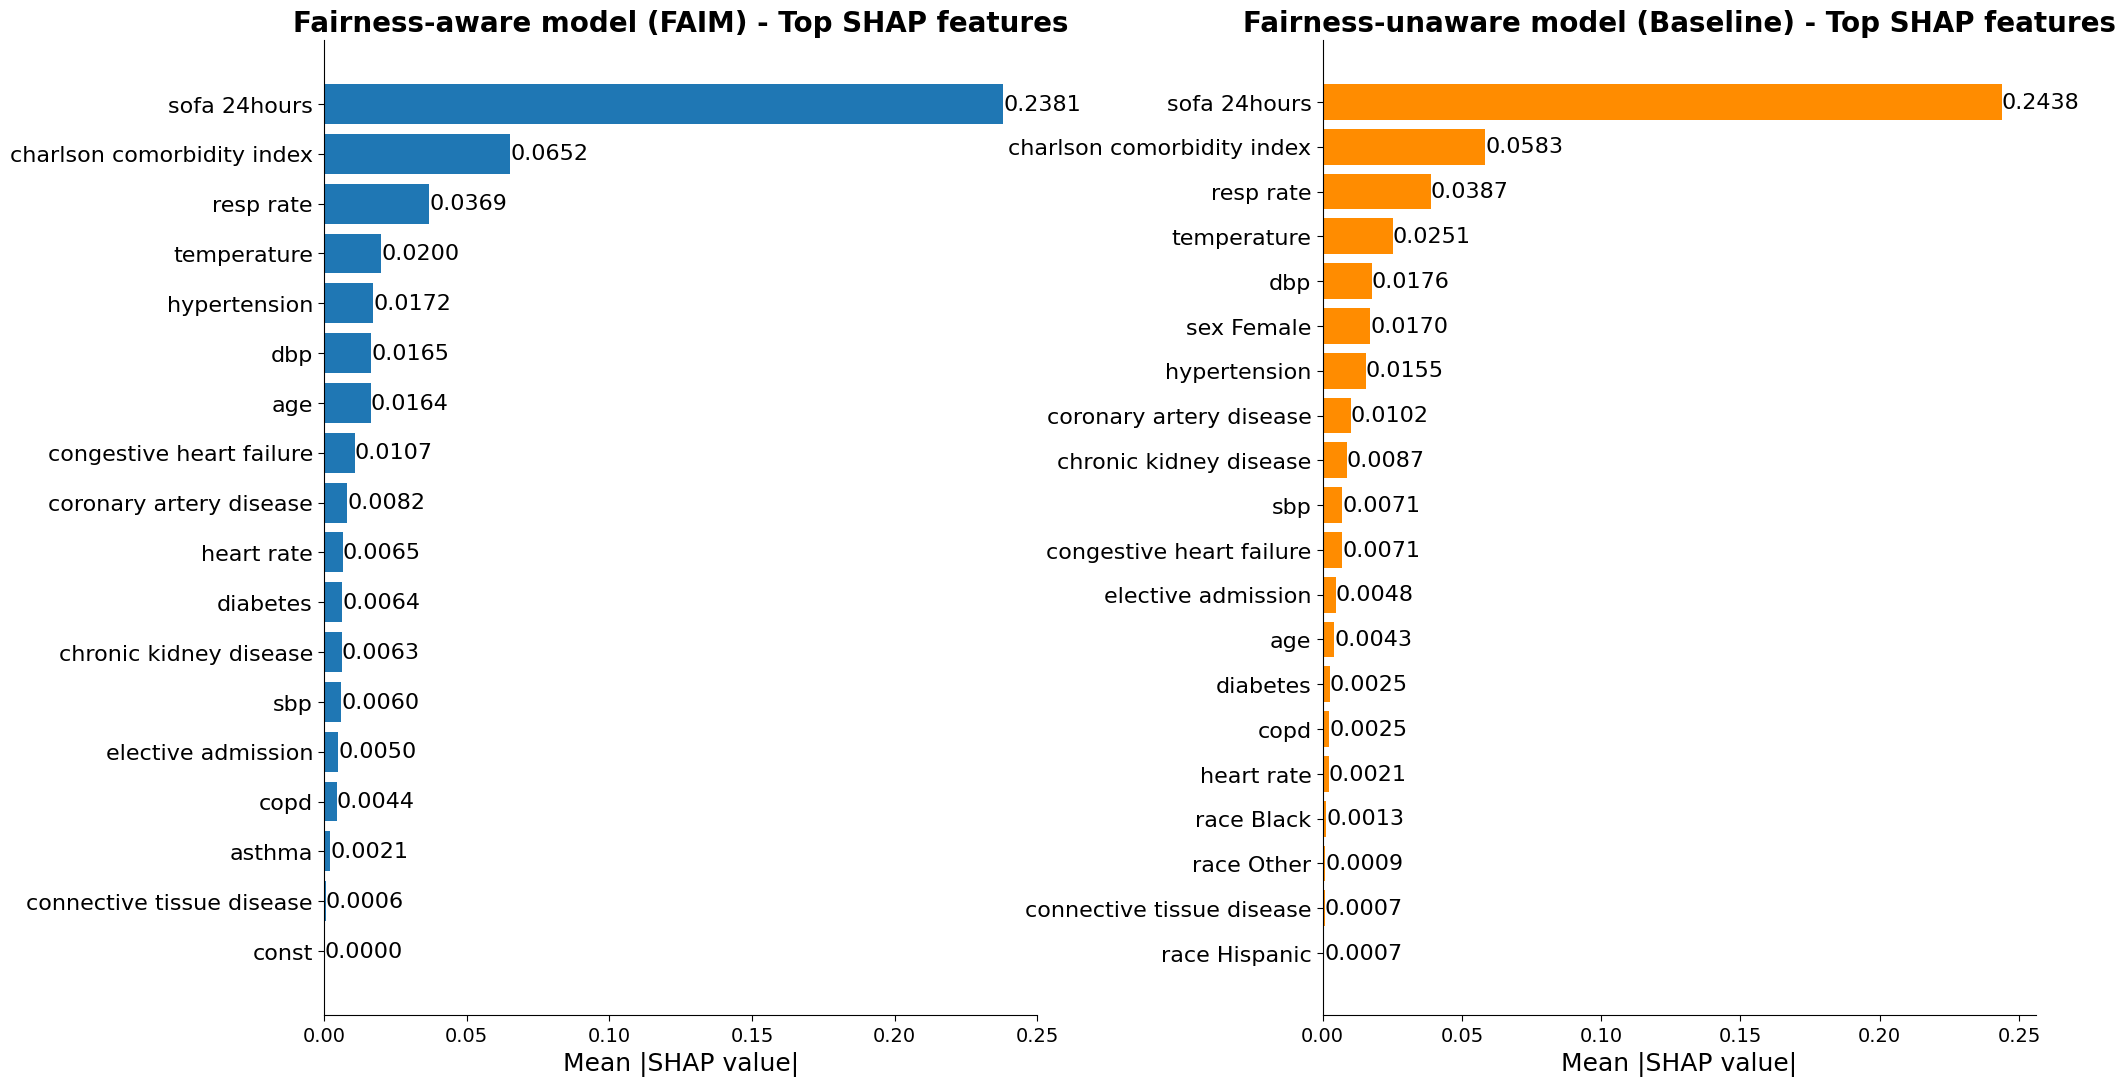

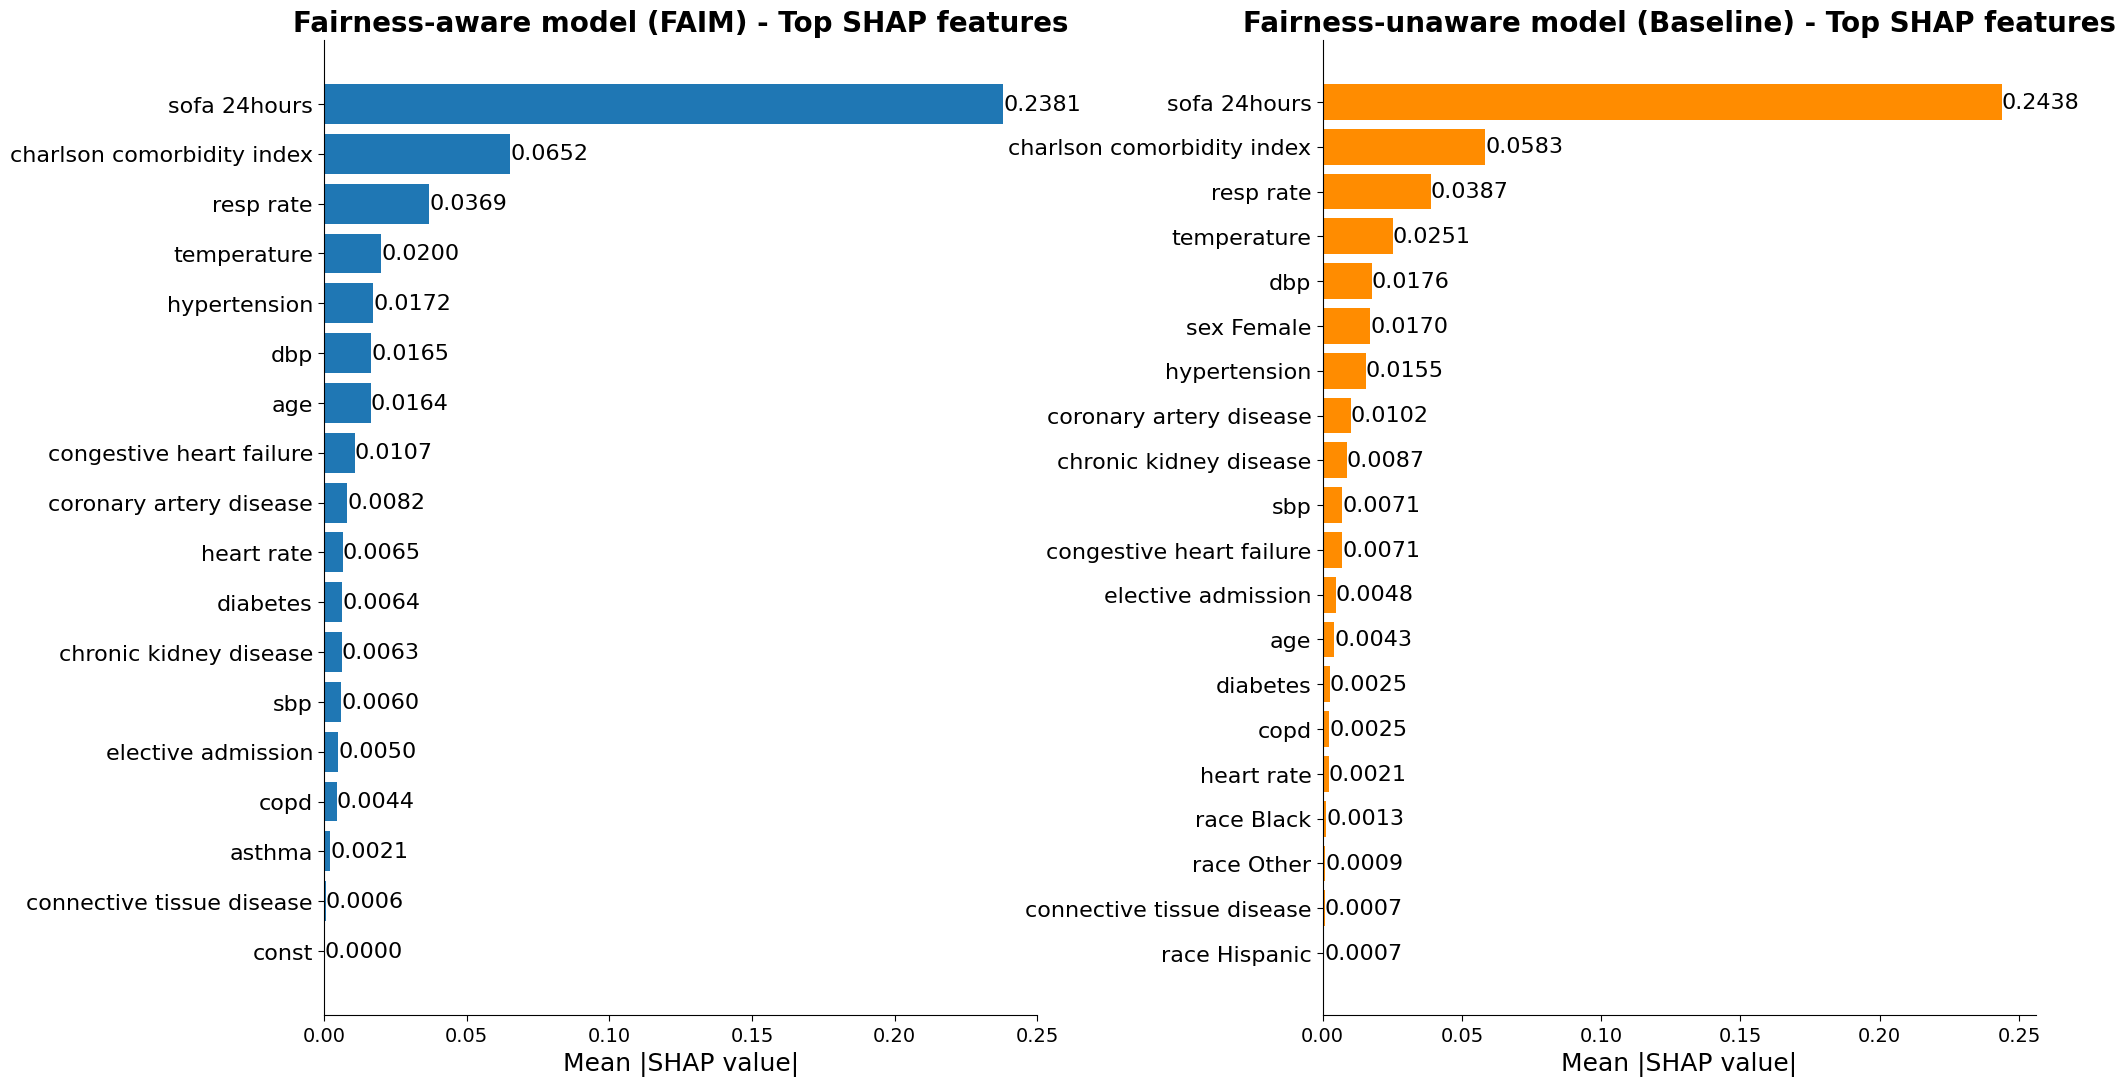

In [ ]:
shap_compare = faim_obj.compare_explain(overide=True, top_n=20)
shap_compare

# Comparison with other bias-mitigation methods


In [ ]:
fairbase = FairBase(
  dat_train,
  selected_vars=colnames,
  selected_vars_cat=x_names_cat,
  y_name="imv",
  sen_name=sen,
  sen_var_ref=sen_ref,
  weighted=True,
  weights={"tnr": 0.5, "tpr": 0.5},
  )

### Original LR

In [ ]:
lr_results = fairbase.model(method="OriginalLR")
dat_test = dat_test.reset_index(drop=True)
pred_ori, fairmetrics_ori, clametrics_ori = fairbase.test(dat_test, model=lr_results)
fairmetrics_ori

,Equal Opportunity,Equalized Odds,Statistical Parity,Accuracy Equality,BER Equality
0,0.211805,0.211805,0.239369,0.097973,0.074427


###Underblindness

In [ ]:
m_unaw = fairbase.model(method="Unawareness")
pred_unaw, fair_unaw, cla_unaw = fairbase.test(dat_test, model=m_unaw)


Training data shape: (39305, 17)
Test data shape: (11230, 17)
Model type: <class 'statsmodels.genmod.generalized_linear_model.GLMResultsWrapper'>
Model expects 18 parameters

Calculating SHAP values (this may take a few minutes)...
Using 200 test samples...


  0%|          | 0/200 [00:00<?, ?it/s]

✓ SHAP values calculated successfully!


✓ Plot saved to: output/shap_unawareness.png


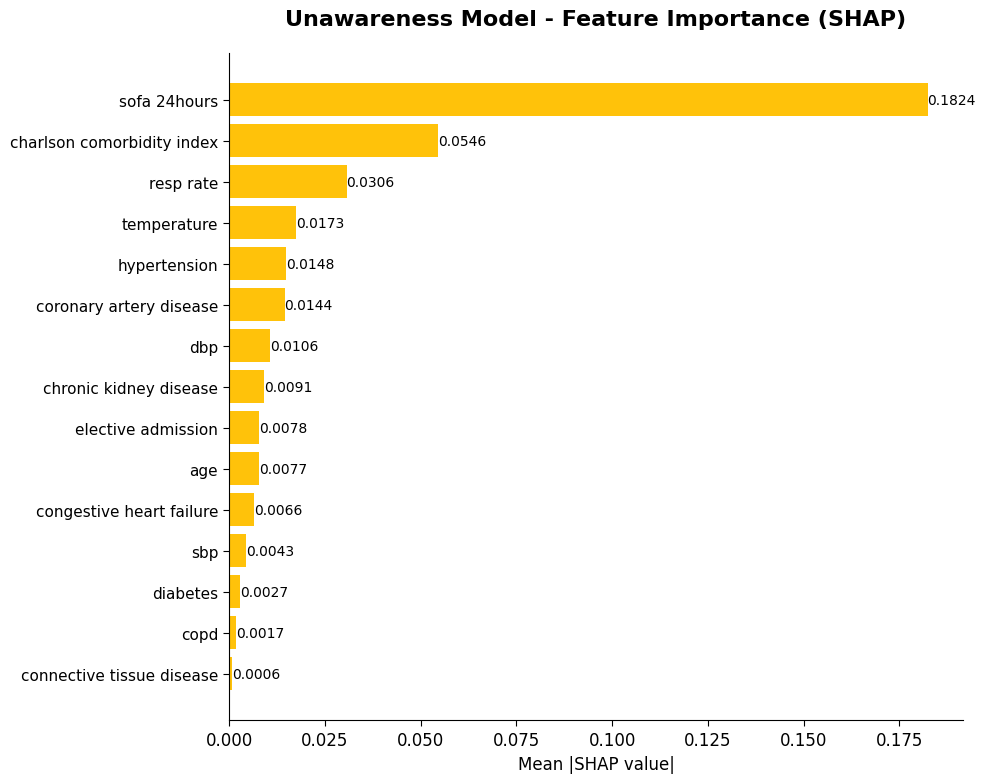


Top Feature Importances (Unawareness Model):
                   feature     shap
              sofa 24hours 0.182406
charlson comorbidity index 0.054558
                 resp rate 0.030609
               temperature 0.017334
              hypertension 0.014753
   coronary artery disease 0.014411
                       dbp 0.010580
    chronic kidney disease 0.009127
        elective admission 0.007782
                       age 0.007716
  congestive heart failure 0.006566
                       sbp 0.004294
                  diabetes 0.002707
                      copd 0.001714
 connective tissue disease 0.000643
                heart rate 0.000286
                    asthma 0.000021


In [ ]:
# Prepare Data for SHAP

# Prepare the data (exclude sensitive variables for unawareness)
X_test_for_shap = dat_test[colnames].copy()

# Remove sensitive variables
sen_vars_to_remove = sen  # ['sex', 'race']
X_test_features = X_test_for_shap.drop(columns=sen_vars_to_remove, errors='ignore')

# Get the training data (also without sensitive variables)
X_train_for_shap = dat_train[colnames].copy()
X_train_features = X_train_for_shap.drop(columns=sen_vars_to_remove, errors='ignore')

# Handle categorical variables - convert to numeric for SHAP
X_train_encoded = pd.get_dummies(X_train_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_features, drop_first=True)

# Ensure test set has same columns as training set
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]

print(f"Training data shape: {X_train_encoded.shape}")
print(f"Test data shape: {X_test_encoded.shape}")
print(f"Model type: {type(m_unaw)}")
print(f"Model expects {len(m_unaw.params)} parameters")

# ==========================================
# Create SHAP Explainer (FIXED)
# ==========================================

def predict_fn(X):
    """
    Fully robust prediction wrapper for statsmodels GLM + SHAP KernelExplainer
    """
    # Convert input to numpy array
    if isinstance(X, pd.DataFrame):
        X_arr = X.values
    else:
        X_arr = np.asarray(X)

    # FORCE 2D
    if X_arr.ndim == 1:
        X_arr = X_arr.reshape(1, -1)

    # Rebuild DataFrame with correct columns (WITHOUT constant)
    X_df = pd.DataFrame(X_arr, columns=X_train_encoded.columns)

    # Add constant
    X_df = sm.add_constant(X_df, has_constant="add")

    # ENSURE correct column order (CRITICAL!)
    X_df = X_df[m_unaw.model.exog_names]

    # FORCE numeric dtype
    X_df = X_df.astype(float)

    # Predict probabilities
    return m_unaw.predict(X_df)

# Use KernelExplainer for statsmodels
print("\nCalculating SHAP values (this may take a few minutes)...")
background = shap.sample(X_train_encoded, 50, random_state=42)
explainer = shap.KernelExplainer(predict_fn, background)

# Calculate SHAP values for a subset of test data
n_samples = min(200, len(X_test_encoded))
print(f"Using {n_samples} test samples...")
shap_values = explainer.shap_values(X_test_encoded[:n_samples], nsamples=100, random_state=42)
print("✓ SHAP values calculated successfully!\n")

# ==========================================
# Aggregate SHAP Values (mean absolute)
# ==========================================

# Take mean absolute SHAP value across all samples for each feature
shap_agg = np.mean(np.abs(shap_values), axis=0)

# Create DataFrame with features and their importance
feature_names = X_test_encoded.columns
shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap': shap_agg
}).sort_values('shap', ascending=False)

# ==========================================
# Clean Feature Labels
# ==========================================

def clean_label(lbl, max_len=40):
    """Clean feature names for better visualization"""
    lbl = lbl.replace("_", " ")
    if len(lbl) > max_len:
        return lbl[:max_len] + "..."
    return lbl

shap_df['feature'] = shap_df['feature'].apply(clean_label)

# ==========================================
# Create Bar Plot
# ==========================================

# Optional: Select top N features (set to None to show all)
top_n = 15  # Change this or set to None to show all features

def clean_spines(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

def add_bar_labels(ax, values, fmt="{:.4f}", padding=3):
    """Add numeric labels to horizontal bar plots."""
    for i, v in enumerate(values):
        ax.text(
            v,
            i,
            fmt.format(v),
            va="center",
            ha="left",
            fontsize=10
        )

if top_n is not None:
    shap_df_plot = shap_df.head(top_n)
else:
    shap_df_plot = shap_df

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

ax.barh(
    shap_df_plot['feature'],
    shap_df_plot['shap'],
    color="#FFC20A"
)

ax.invert_yaxis()  # Highest importance at top
ax.set_title(
    "Unawareness Model - Feature Importance (SHAP)",
    fontsize=16,
    weight="bold",
    pad=20
)
ax.set_xlabel("Mean |SHAP value|", fontsize=12)
ax.tick_params(axis='y', labelsize=11)
add_bar_labels(ax, shap_df_plot['shap'].values)
clean_spines(ax)

plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/shap_unawareness.png", dpi=300, bbox_inches='tight')
print(f"\n✓ Plot saved to: {output_dir}/shap_unawareness.png")

plt.show()

# ==========================================
# Display Feature Importance Table
# ==========================================

print("\nTop Feature Importances (Unawareness Model):")
print("=" * 60)
print(shap_df.to_string(index=False))
print("=" * 60)

### Reweigh

,Equal Opportunity,Equalized Odds,Statistical Parity,Accuracy Equality,BER Equality
0,0.169955,0.179479,0.191367,0.097049,0.081232


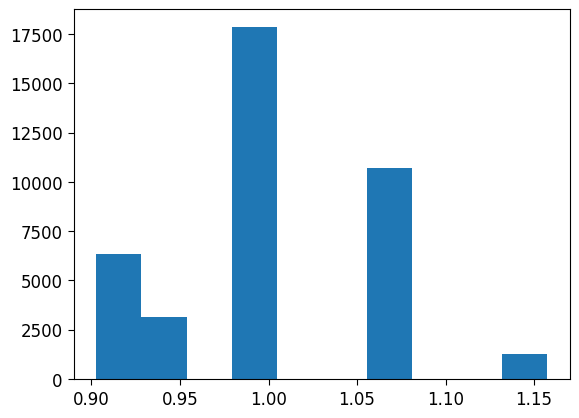

In [ ]:
_, rw_results, _ = fairbase.model(method_type="pre", method="Reweigh", label_names=["imv"])
pred_rw, fairmetrics_rw, clametrics_rw = fairbase.test(dat_test, model=rw_results)
fairmetrics_rw

###In-processing: Reductions

In [ ]:
m_red = fairbase.model(method_type="in", method="Reductions")
pred_red, fair_red, cla_red = fairbase.test(dat_test, model=m_red)

###Post-processing: Equalized Odds

In [ ]:
m_eq = fairbase.model(method_type="post", method="EqOdds", dat_expl=dat_expl)
pred_eq, fair_eq, cla_eq = fairbase.test(dat_test, model=m_eq)

###Post-processing: Calibrated Equalized Odds

In [ ]:
m_cal = fairbase.model(
    method_type="post",
    method="CalEqOdds",
    dat_expl=dat_expl,
    cost_constraint="weighted",
)
pred_cal, fair_cal, cla_cal = fairbase.test(dat_test, model=m_cal)


###Post-processing: Reject Option Classification

In [ ]:
m_roc = fairbase.model(
    method_type="post",
    method="ROC",
    dat_expl=dat_expl,
    metric_name="Equal opportunity difference",
    ub=0.05,
    lb=-0.05,
)
pred_roc, fair_roc, cla_roc = fairbase.test(dat_test, model=m_roc)


### Summary of results

In [ ]:
results = {
    "Original": (pred_ori, fairmetrics_ori, clametrics_ori),
    "Unawareness": (pred_unaw, fair_unaw, cla_unaw),
    "Reweighing": (pred_rw, fairmetrics_rw, clametrics_rw),
    "Reductions": (pred_red, fair_red, cla_red),
    "EqOdds": (pred_eq, fair_eq, cla_eq),
    "CalEqOdds": (pred_cal, fair_cal, cla_cal),
    "ROC": (pred_roc, fair_roc, cla_roc),
    "FAIM": (pred_test, fairmetrics_faim, fairsummary_faim),
}


In [ ]:
# Read the adversarial results CSV
adv_results = pd.read_csv("test_metrics_adv_imv.csv")

# Extract the fairness metrics you want (let's use the best performing row)
# You can choose based on which metric is most important to you
# For example, let's use the row with lowest equalized_odds_diff
best_adv_idx = adv_results['equalized_odds_diff'].abs().idxmin()
adv_metrics = adv_results.loc[best_adv_idx]

# Create a row for the adversarial method
# Match the column names to your fairmetrics format
# You'll need to map the adversarial metric names to your fairness metric names
adv_row = pd.Series({
    'Equal Opportunity': adv_metrics['equal_opportunity_diff'],
    'Equalized Odds': adv_metrics['equalized_odds_diff'],
    'BER Equality': adv_metrics['ber_equality_diff'],
    'Statistical Parity': adv_metrics['statistical_parity_diff'],
    'Accuracy Equality': adv_metrics['accuracy_equality_diff'],
})

# Add to your comparison dataframe
faircompare_df = pd.concat([
    fairmetrics_ori,
    fair_unaw,
    fairmetrics_rw,
    fair_red,
    fair_eq,
    fair_cal,
    fair_roc,
    fairmetrics_faim,
    adv_row.to_frame().T  # Convert series to dataframe row
])

faircompare_df.index = [
    "Original",
    "Unawareness",
    "Reweighing",
    "Reductions",
    "EqOdds",
    "CalEqOdds",
    "ROC",
    "FAIM",
    "Adnet"
]

faircompare_df

,Equal Opportunity,Equalized Odds,Statistical Parity,Accuracy Equality,BER Equality
Original,0.211805,0.211805,0.239369,0.097973,0.074427
Unawareness,0.195433,0.195433,0.151995,0.082708,0.062793
Reweighing,0.169955,0.179479,0.191367,0.097049,0.081232
Reductions,0.241569,0.241569,0.113930,0.111166,0.114205
EqOdds,0.853659,0.853659,0.467391,0.151583,0.267729
CalEqOdds,0.779633,0.779633,0.455892,0.202744,0.258896
ROC,0.187976,0.187976,0.189684,0.082880,0.069573
FAIM,0.190151,0.190151,0.145732,0.074915,0.064302
Adnet,0.256410,0.435675,0.250004,0.079148,0.073466


Equal Opportunity: max TPR gap between any two sensitive groups (within a sensitive attribute)\
Equalized Odds: worst-case fairness gap\
Statistical Parity: max SR gap\
Accuracy Equality: max accuracy diff \
BER Equality: weighed combination of worst TPR/TNR gaps\

In [ ]:
adv_row = pd.Series({
    'auc': adv_metrics['auc'],
    'auc_low': adv_metrics['auc_low'],
    'auc_high': adv_metrics['auc_high'],
    'sensitivity': adv_metrics['recall'],
    'specificity': adv_metrics['specificity'],
})

# Extract fairmetrics from each result
faircompare_df = pd.concat([
    clametrics_ori,
    cla_unaw,
    clametrics_rw,
    cla_red,
    cla_eq,
    cla_cal,
    cla_roc,
    fairsummary_faim,
    adv_row.to_frame().T
])

# Set descriptive index names
faircompare_df.index = [
    "Original",
    "Unawareness",
    "Reweighing",
    "Reductions",
    "EqOdds",
    "CalEqOdds",
    "ROC",
    "FAIM",
    "Adnet"
]

faircompare_df

,sensitivity,specificity,auc_low,auc,auc_high
Original,0.811897,0.704988,0.822275,0.830100,0.838474
Unawareness,0.806806,0.710723,0.820968,0.828955,0.836722
Reweighing,0.808146,0.706989,0.820239,0.828427,0.836218
Reductions,0.500268,0.896772,0.690290,0.698457,0.706875
EqOdds,0.367095,0.860630,0.605527,0.614064,0.622425
CalEqOdds,0.416667,0.878901,0.639187,0.647954,0.656905
ROC,0.784566,0.728728,0.748074,0.756595,0.765424
FAIM,0.787513,0.725794,0.820087,0.827863,0.836125
Adnet,0.771575,0.764642,0.840393,0.847577,0.854659


Adnet has highest accuracy

# Bias Analysis (Baseline) on Test set

In [ ]:
y_true = dat_test["imv"]

y_pred_prob_baseline = faim_obj.optim_model.predict(
    params=faim_obj.optim_results.params,
    exog=faim_obj.data_process(dat_test, faim_obj.vars, faim_obj.vars_cat)[0]
)

# USE OPTIMAL THRESHOLD (not 0.5!)
threshold_baseline = find_optimal_cutoff(y_true, y_pred_prob_baseline, method="auc")[0]
y_pred_bin_baseline = (y_pred_prob_baseline > threshold_baseline).astype(int)

In [ ]:
# Reset indices
y_true_reset = y_true.reset_index(drop=True)
y_pred_reset = pd.Series(y_pred_prob_baseline).reset_index(drop=True)
y_pred_bin_reset = pd.Series(y_pred_bin_baseline).reset_index(drop=True)

# Sex
fair_sex_baseline = FAIMEvaluator(
    y_true=y_true_reset,
    y_pred=y_pred_reset,
    y_pred_bin=y_pred_bin_reset,
    sen_var=dat_test["sex"],  # ← Reset here
    weighted=True,
    weights={"tpr": 0.5, "tnr": 0.5}
)

# Race
fair_race_baseline = FAIMEvaluator(
    y_true=y_true_reset,
    y_pred=y_pred_reset,
    y_pred_bin=y_pred_bin_reset,
    sen_var=dat_test["race"],  # ← Reset here
    weighted=True,
    weights={"tpr": 0.5, "tnr": 0.5}
)

# Intersectional
dat_test_reset = dat_test.reset_index(drop=True)
dat_test_reset["Sex_Race"] = dat_test_reset["sex"].astype(str) + "_" + dat_test_reset["race"].astype(str)
#dat_test["Sex_Race"] = dat_test["sex"].astype(str) + "_" + dat_test["race"].astype(str)

fair_sex_race_baseline = FAIMEvaluator(
    y_true=y_true_reset,
    y_pred=y_pred_reset,
    y_pred_bin=y_pred_bin_reset,
    sen_var=dat_test_reset["Sex_Race"],  # ← Already reset
    weighted=True,
    weights={"tpr": 0.5, "tnr": 0.5}
)

In [ ]:
fair_sex_baseline.fairsummary.by_group

,tpr,tnr,sr,acc,conf_mat
sex,,,,,
@Male,0.848273,0.659161,0.528168,0.728975,"[[2576, 1332], [347, 1940]]"
Female,0.754325,0.754875,0.391261,0.754717,"[[2710, 880], [355, 1090]]"


In [ ]:
fair_race_baseline.fairsummary.by_group

,tpr,tnr,sr,acc,conf_mat
race,,,,,
@White,0.818587,0.700792,0.475294,0.740728,"[[3984, 1701], [529, 2387]]"
Asian,0.879310,0.671186,0.484185,0.729927,"[[198, 97], [14, 102]]"
Black,0.735294,0.747017,0.392190,0.743633,"[[626, 212], [90, 250]]"
Hispanic,0.785235,0.760125,0.412766,0.768085,"[[244, 77], [32, 117]]"
Other,0.824645,0.651811,0.524561,0.715789,"[[234, 125], [37, 174]]"


In [ ]:
fair_sex_race_baseline.fairsummary.by_group

,tpr,tnr,sr,acc,conf_mat
Sex_Race,,,,,
@Male_@White,0.856427,0.652435,0.538269,0.728884,"[[1956, 1042], [258, 1539]]"
@Male_Asian,0.893333,0.671053,0.515419,0.744493,"[[102, 50], [8, 67]]"
@Male_Black,0.781421,0.717277,0.444248,0.738053,"[[274, 108], [40, 143]]"
@Male_Hispanic,0.806122,0.733728,0.464419,0.760300,"[[124, 45], [19, 79]]"
@Male_Other,0.835821,0.579710,0.583578,0.680352,"[[120, 87], [22, 112]]"
Female_@White,0.757819,0.754745,0.395954,0.755649,"[[2028, 659], [271, 848]]"
Female_Asian,0.853659,0.671329,0.445652,0.711957,"[[96, 47], [6, 35]]"
Female_Black,0.681529,0.771930,0.344209,0.748777,"[[352, 104], [50, 107]]"
Female_Hispanic,0.745098,0.789474,0.344828,0.778325,"[[120, 32], [13, 38]]"


In [ ]:
fair_sex_race_baseline.disparity_table

,Metric,Min Value,Min Intersection,Min Type,Max Value,Max Intersection,Gap,Reference Intersection,Reference Value,Reference Gap
0,Equalized Odds (max of TPR/FPR),0.6815,Female_Black,TPR,0.8933,@Male_Asian,0.2118,@Male_@White,0.8564,0.1749
1,Equal Opportunity (TPR),0.6815,Female_Black,TPR,0.8933,@Male_Asian,0.2118,@Male_@White,0.8564,0.1749
2,BER Equality,0.2178,@Male_Asian,BER,0.2922,@Male_Other,0.0744,@Male_@White,0.2456,0.0278


In [ ]:
fair_race_baseline.disparity_table

,Metric,Min Value,Min Group,Min Type,Max Value,Max Group,Gap,Reference Group,Reference Value,Reference Gap
0,Equalized Odds (max of TPR/FPR),0.7353,Black,TPR,0.8793,Asian,0.144,@White,0.8186,0.0833
1,Equal Opportunity (TPR),0.7353,Black,TPR,0.8793,Asian,0.144,@White,0.8186,0.0833
2,BER Equality,0.2248,Asian,BER,0.2618,Other,0.037,@White,0.2403,0.0156


In [ ]:
fair_sex_baseline.disparity_table

,Metric,Min Value,Min Group,Min Type,Max Value,Max Group,Gap,Reference Group,Reference Value,Reference Gap
0,Equalized Odds (max of TPR/FPR),0.2451,Female,FPR,0.3408,@Male,0.0957,None,None,None
1,Equal Opportunity (TPR),0.7543,Female,TPR,0.8483,@Male,0.0939,None,None,None
2,BER Equality,0.2454,Female,BER,0.2463,@Male,0.0009,None,None,None


#Bias Analysis (FAIM) on Test set

In [ ]:
excluded_vars = faim_obj.best_sen_exclusion.split("_")
selected_vars = [i for i in faim_obj.vars if i not in excluded_vars]
selected_vars_cat = [i for i in faim_obj.vars_cat if i not in excluded_vars]

y_pred_prob_faim = faim_obj.best_optim_base_obj.model_optim.model.predict(
    params=faim_obj.best_coef,
    exog=faim_obj.data_process(dat_test, selected_vars, selected_vars_cat)[0]
)

# USE OPTIMAL THRESHOLD
threshold_faim = find_optimal_cutoff(y_true, y_pred_prob_faim, method="auc")[0]
y_pred_bin_faim = (y_pred_prob_faim > threshold_faim).astype(int)

In [ ]:
# On test set only
dat_test_reset = dat_test.reset_index(drop=True)

# Reset indices
y_true_reset = dat_test_reset["imv"]                # target
y_pred_reset = pd.Series(y_pred_prob_faim).reset_index(drop=True)
y_pred_bin_reset = pd.Series(y_pred_bin_faim).reset_index(drop=True)


# Sensitive variables from the same reset df
sen_sex = dat_test_reset["sex"]
sen_race = dat_test_reset["race"]
dat_test_reset["Sex_Race"] = sen_sex.astype(str) + "_" + sen_race.astype(str)

fair_sex_faim = FAIMEvaluator(
    y_true=y_true_reset,
    y_pred=y_pred_reset,
    y_pred_bin=y_pred_bin_reset,
    sen_var=sen_sex,
    weighted=True,
    weights={"tpr": 0.5, "tnr": 0.5}
)

fair_race_faim = FAIMEvaluator(
    y_true=y_true_reset,
    y_pred=y_pred_reset,
    y_pred_bin=y_pred_bin_reset,
    sen_var=sen_race,
    weighted=True,
    weights={"tpr": 0.5, "tnr": 0.5}
)

fair_sex_race_faim = FAIMEvaluator(
    y_true=y_true_reset,
    y_pred=y_pred_reset,
    y_pred_bin=y_pred_bin_reset,
    sen_var=dat_test_reset["Sex_Race"],
    weighted=True,
    weights={"tpr": 0.5, "tnr": 0.5}
)


In [ ]:
fair_sex_race_faim.fairsummary.by_group

,tpr,tnr,sr,acc,conf_mat
Sex_Race,,,,,
@Male_@White,0.816361,0.701801,0.492388,0.744734,"[[2104, 894], [330, 1467]]"
@Male_Asian,0.826667,0.717105,0.462555,0.753304,"[[109, 43], [13, 62]]"
@Male_Black,0.765027,0.751309,0.415929,0.755752,"[[287, 95], [43, 140]]"
@Male_Hispanic,0.765306,0.757396,0.434457,0.760300,"[[128, 41], [23, 75]]"
@Male_Other,0.776119,0.661836,0.510264,0.706745,"[[137, 70], [30, 104]]"
Female_@White,0.759607,0.746930,0.401997,0.750657,"[[2007, 680], [269, 850]]"
Female_Asian,0.878049,0.671329,0.451087,0.717391,"[[96, 47], [5, 36]]"
Female_Black,0.687898,0.745614,0.365416,0.730832,"[[340, 116], [49, 108]]"
Female_Hispanic,0.725490,0.756579,0.364532,0.748768,"[[115, 37], [14, 37]]"


In [ ]:
fair_race_faim.fairsummary.by_group

,tpr,tnr,sr,acc,conf_mat
race,,,,,
@White,0.794582,0.723131,0.452389,0.747355,"[[4111, 1574], [599, 2317]]"
Asian,0.844828,0.694915,0.457421,0.737226,"[[205, 90], [18, 98]]"
Black,0.729412,0.748210,0.389643,0.742784,"[[627, 211], [92, 248]]"
Hispanic,0.751678,0.757009,0.404255,0.755319,"[[243, 78], [37, 112]]"
Other,0.777251,0.713092,0.468421,0.736842,"[[256, 103], [47, 164]]"


In [ ]:
fair_sex_faim.fairsummary.by_group

,tpr,tnr,sr,acc,conf_mat
sex,,,,,
@Male,0.808045,0.707523,0.482809,0.744633,"[[2765, 1143], [439, 1848]]"
Female,0.755017,0.745682,0.398014,0.748361,"[[2677, 913], [354, 1091]]"


In [ ]:
fair_sex_race_faim.disparity_table

,Metric,Min Value,Min Intersection,Min Type,Max Value,Max Intersection,Gap,Reference Intersection,Reference Value,Reference Gap
0,Equalized Odds (max of TPR/FPR),0.6879,Female_Black,TPR,0.8780,Female_Asian,0.1902,@Male_@White,0.8164,0.1285
1,Equal Opportunity (TPR),0.6879,Female_Black,TPR,0.8780,Female_Asian,0.1902,@Male_@White,0.8164,0.1285
2,BER Equality,0.2189,Female_Other,BER,0.2832,Female_Black,0.0643,@Male_@White,0.2409,0.0220


In [ ]:
fair_race_faim.disparity_table

,Metric,Min Value,Min Group,Min Type,Max Value,Max Group,Gap,Reference Group,Reference Value,Reference Gap
0,Equalized Odds (max of TPR/FPR),0.7294,Black,TPR,0.8448,Asian,0.1154,@White,0.7946,0.0652
1,Equal Opportunity (TPR),0.7294,Black,TPR,0.8448,Asian,0.1154,@White,0.7946,0.0652
2,BER Equality,0.2301,Asian,BER,0.2612,Black,0.0311,@White,0.2411,0.0110


In [ ]:
fair_sex_faim.disparity_table

,Metric,Min Value,Min Group,Min Type,Max Value,Max Group,Gap,Reference Group,Reference Value,Reference Gap
0,Equalized Odds (max of TPR/FPR),0.7550,Female,TPR,0.8080,@Male,0.0530,None,None,None
1,Equal Opportunity (TPR),0.7550,Female,TPR,0.8080,@Male,0.0530,None,None,None
2,BER Equality,0.2422,@Male,BER,0.2497,Female,0.0074,None,None,None


# Tables and Figures

In [ ]:
# ===== DEFINE PREDICTIONS AND TRUE LABELS =====
# Get FAIM's fairness-aware model predictions
excluded_vars = faim_obj.best_sen_exclusion.split("_")
selected_vars = [i for i in faim_obj.vars if i not in excluded_vars]
selected_vars_cat = [i for i in faim_obj.vars_cat if i not in excluded_vars]

# Get predictions
X_test_faim, _, _ = faim_obj.data_process(dat_test, selected_vars, selected_vars_cat)
y_pred_prob_faim = faim_obj.best_optim_base_obj.model_optim.model.predict(
    params=faim_obj.best_coef,
    exog=X_test_faim
)

# Use optimal threshold
optimal_threshold = find_optimal_cutoff(dat_test["imv"], y_pred_prob_faim, method="auc")[0]
y_pred_bin_test = (y_pred_prob_faim > optimal_threshold).astype(int)

# TRUE LABELS (this is what you're missing!)
y_true_test = dat_test["imv"].values

print(f"✓ Optimal threshold: {optimal_threshold:.4f}")
print(f"✓ y_true_test shape: {y_true_test.shape}")
print(f"✓ y_pred_bin_test shape: {y_pred_bin_test.shape}")

# ===== CREATE SUBGROUP COLUMN =====
dat_test["Sex_Race"] = dat_test["sex"].astype(str) + "_" + dat_test["race"].astype(str)

# ===== COMPUTE TPR WITH CI =====
def compute_tpr_ci(y_true, y_pred_bin, subgroup_mask):
    """Compute 95% CI for TPR in a subgroup"""
    y_true_sub = y_true[subgroup_mask.values]
    y_pred_sub = y_pred_bin[subgroup_mask.values]

    # TPR = TP / (TP + FN)
    positives = y_true_sub == 1
    n_pos = positives.sum()

    if n_pos == 0:
        return None, None, None, 0

    tp = ((y_true_sub == 1) & (y_pred_sub == 1)).sum()
    tpr = tp / n_pos

    # Wilson score interval for binomial proportion
    if n_pos < 5:  # Too small for reliable CI
        return tpr, np.nan, np.nan, n_pos

    ci = stats.binom.interval(0.95, n_pos, tpr)
    ci_lower, ci_upper = ci[0] / n_pos, ci[1] / n_pos

    return tpr, ci_lower, ci_upper, n_pos

# Get ALL unique subgroups from test set
all_subgroups = dat_test['Sex_Race'].unique()

print(f"\nFound {len(all_subgroups)} unique subgroups in test set:")
print(sorted(all_subgroups))
print("\n" + "="*80)
print("Test Set TPR with 95% Confidence Intervals (FAIM Model):")
print("="*80)

results = []
for subgroup in sorted(all_subgroups):
    mask = dat_test['Sex_Race'] == subgroup
    n_subgroup = mask.sum()

    tpr, ci_low, ci_high, n_pos = compute_tpr_ci(
        y_true_test,
        y_pred_bin_test,
        mask
    )

    if tpr is not None:
        results.append({
            'Subgroup': subgroup,
            'N_Total': n_subgroup,
            'N_Positive': n_pos,
            'TPR': tpr,
            'CI_Lower': ci_low,
            'CI_Upper': ci_high,
            'CI_Width': ci_high - ci_low if not np.isnan(ci_high) else np.nan
        })

        if not np.isnan(ci_low):
            print(f"{subgroup:25s} (n={n_subgroup:4d}, pos={n_pos:3d}): TPR={tpr:.3f} [{ci_low:.3f}, {ci_high:.3f}]")
        else:
            print(f"{subgroup:25s} (n={n_subgroup:4d}, pos={n_pos:3d}): TPR={tpr:.3f} [insufficient sample]")

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('TPR', ascending=False)

# ... rest of your analysis code ...

✓ Optimal threshold: 0.4367
✓ y_true_test shape: (11230,)
✓ y_pred_bin_test shape: (11230,)

Found 10 unique subgroups in test set:
['@Male_@White', '@Male_Asian', '@Male_Black', '@Male_Hispanic', '@Male_Other', 'Female_@White', 'Female_Asian', 'Female_Black', 'Female_Hispanic', 'Female_Other']

Test Set TPR with 95% Confidence Intervals (FAIM Model):
@Male_@White              (n=4795, pos=1797): TPR=0.816 [0.799, 0.834]
@Male_Asian               (n= 227, pos= 75): TPR=0.827 [0.733, 0.907]
@Male_Black               (n= 565, pos=183): TPR=0.765 [0.705, 0.825]
@Male_Hispanic            (n= 267, pos= 98): TPR=0.765 [0.684, 0.847]
@Male_Other               (n= 341, pos=134): TPR=0.776 [0.701, 0.843]
Female_@White             (n=3806, pos=1119): TPR=0.760 [0.735, 0.785]
Female_Asian              (n= 184, pos= 41): TPR=0.878 [0.780, 0.976]
Female_Black              (n= 613, pos=157): TPR=0.688 [0.611, 0.758]
Female_Hispanic           (n= 203, pos= 51): TPR=0.725 [0.608, 0.843]
Female_Other  

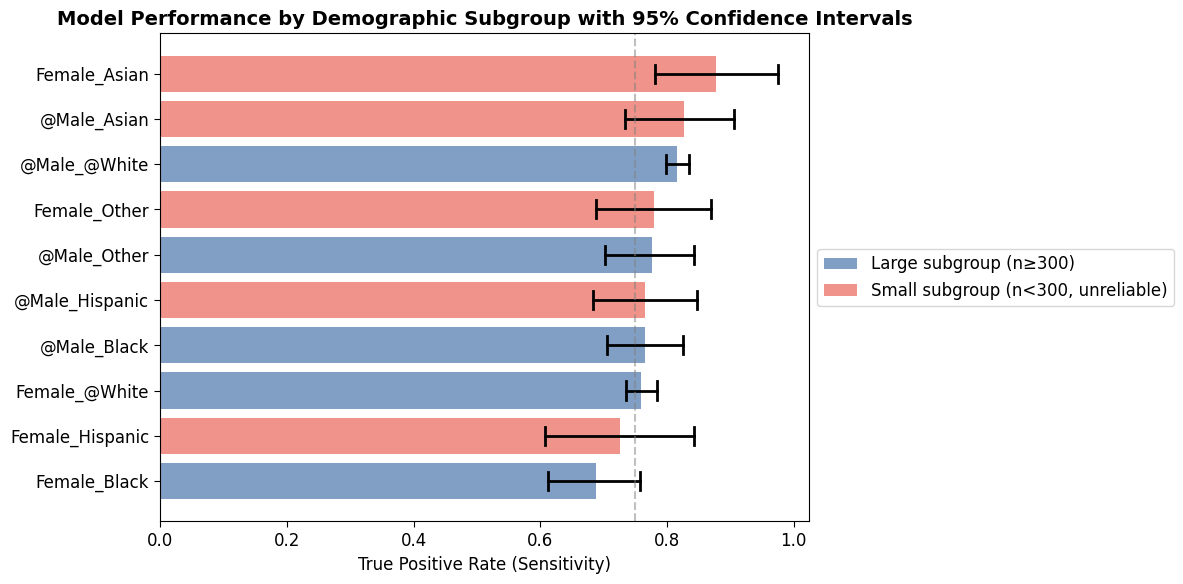


✓ Figure saved as 'subgroup_performance_with_ci.png'


In [ ]:
# Prepare data
results_df_sorted = results_df.sort_values('TPR', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))  # Made wider to accommodate legend

# Color code by sample size
colors = ['#E74C3C' if n < 300 else '#2E5F9E' for n in results_df_sorted['N_Total']]

# Plot with error bars
y_pos = np.arange(len(results_df_sorted))
ax.barh(y_pos, results_df_sorted['TPR'], color=colors, alpha=0.6)

# Add confidence intervals
for i, row in enumerate(results_df_sorted.itertuples()):
    ax.plot([row.CI_Lower, row.CI_Upper], [i, i], 'k-', linewidth=2)
    ax.plot([row.CI_Lower, row.CI_Lower], [i-0.2, i+0.2], 'k-', linewidth=2)
    ax.plot([row.CI_Upper, row.CI_Upper], [i-0.2, i+0.2], 'k-', linewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(results_df_sorted['Subgroup'])
ax.set_xlabel('True Positive Rate (Sensitivity)', fontsize=12)
ax.set_title('Model Performance by Demographic Subgroup with 95% Confidence Intervals', fontsize=14, weight='bold')
ax.axvline(x=0.75, color='gray', linestyle='--', alpha=0.5, label='Target threshold')

# Legend - placed outside plot area on the right
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2E5F9E', alpha=0.6, label='Large subgroup (n≥300)'),
    Patch(facecolor='#E74C3C', alpha=0.6, label='Small subgroup (n<300, unreliable)')
]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('subgroup_performance_with_ci.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as 'subgroup_performance_with_ci.png'")

In [ ]:
print("="*80)
print("INTERSECTIONAL FAIRNESS: BASELINE vs FAIM COMPARISON")
print("="*80)

# ===== GET ALL INTERSECTIONAL TPRs =====
def get_all_group_tprs(y_true_arr, y_pred_bin_arr, sensitive_var):
    """Get TPR for every group in a sensitive variable"""
    from sklearn.metrics import confusion_matrix

    groups = dat_test_copy[sensitive_var].unique()
    results = []

    for group in groups:
        mask = (dat_test_copy[sensitive_var] == group).values
        y_true_group = y_true_arr[mask]
        y_pred_group = y_pred_bin_arr[mask]

        if len(y_true_group) == 0 or y_true_group.sum() == 0:
            continue

        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0,1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan

        if not np.isnan(tpr):
            results.append({
                'Intersection': group,
                'TPR': tpr,
                'N_Total': len(y_true_group),
                'N_Positive': int(y_true_group.sum())
            })

    return pd.DataFrame(results)

# Get TPRs for baseline and FAIM
baseline_tprs = get_all_group_tprs(y_true_arr, y_pred_bin_baseline_arr, 'Sex_Race')
faim_tprs = get_all_group_tprs(y_true_arr, y_pred_bin_faim_arr, 'Sex_Race')

# Merge
comparison = baseline_tprs.merge(
    faim_tprs,
    on='Intersection',
    suffixes=('_Baseline', '_FAIM')
)

comparison['TPR_Change'] = comparison['TPR_FAIM'] - comparison['TPR_Baseline']
comparison['TPR_Change_Pct'] = (comparison['TPR_Change'] / comparison['TPR_Baseline'] * 100)

# Sort by baseline TPR (worst to best)
comparison = comparison.sort_values('TPR_Baseline', ascending=True).reset_index(drop=True)

# Round for cleaner output
comparison_display = comparison.copy()
comparison_display['TPR_Baseline'] = comparison_display['TPR_Baseline'].round(4)
comparison_display['TPR_FAIM'] = comparison_display['TPR_FAIM'].round(4)
comparison_display['TPR_Change'] = comparison_display['TPR_Change'].round(4)
comparison_display['TPR_Change_Pct'] = comparison_display['TPR_Change_Pct'].round(1)

# ===== CREATE COPY-PASTE FRIENDLY TABLE =====
print("\n" + "="*80)
print("TABLE 1: INTERSECTIONAL PERFORMANCE COMPARISON")
print("="*80)
print("\nTab-delimited (copy-paste into Word/Excel):\n")

# Tab-delimited version (best for Word/Excel)
print("Intersection\tN\tBaseline TPR\tFAIM TPR\tChange\tChange (%)")
for _, row in comparison_display.iterrows():
    print(f"{row['Intersection']}\t{row['N_Total_Baseline']}\t{row['TPR_Baseline']:.4f}\t{row['TPR_FAIM']:.4f}\t{row['TPR_Change']:+.4f}\t{row['TPR_Change_Pct']:+.1f}%")

# ===== FORMATTED TABLE FOR LATEX =====
print("\n" + "="*80)
print("LATEX FORMAT:")
print("="*80)
print("""
\\begin{table}[h]
\\centering
\\caption{Intersectional Performance: Baseline vs FAIM}
\\begin{tabular}{lrrrrc}
\\hline
Intersection & N & Baseline TPR & FAIM TPR & Change & Change (\\%) \\\\
\\hline
""")

for _, row in comparison_display.iterrows():
    print(f"{row['Intersection']} & {row['N_Total_Baseline']} & {row['TPR_Baseline']:.4f} & {row['TPR_FAIM']:.4f} & {row['TPR_Change']:+.4f} & {row['TPR_Change_Pct']:+.1f}\\% \\\\")

print("""\\hline
\\end{tabular}
\\end{table}
""")

# ===== MARKDOWN TABLE =====
print("\n" + "="*80)
print("MARKDOWN FORMAT:")
print("="*80)
print("\n| Intersection | N | Baseline TPR | FAIM TPR | Change | Change (%) |")
print("|-------------|---:|-------------:|---------:|-------:|-----------:|")

for _, row in comparison_display.iterrows():
    print(f"| {row['Intersection']} | {row['N_Total_Baseline']} | {row['TPR_Baseline']:.4f} | {row['TPR_FAIM']:.4f} | {row['TPR_Change']:+.4f} | {row['TPR_Change_Pct']:+.1f}% |")

# ===== SUMMARY STATISTICS TABLE =====
print("\n" + "="*80)
print("TABLE 2: SUMMARY STATISTICS")
print("="*80)

# Calculate summary stats
baseline_min = comparison['TPR_Baseline'].min()
baseline_max = comparison['TPR_Baseline'].max()
baseline_gap = baseline_max - baseline_min
baseline_mean = comparison['TPR_Baseline'].mean()
baseline_std = comparison['TPR_Baseline'].std()

faim_min = comparison['TPR_FAIM'].min()
faim_max = comparison['TPR_FAIM'].max()
faim_gap = faim_max - faim_min
faim_mean = comparison['TPR_FAIM'].mean()
faim_std = comparison['TPR_FAIM'].std()

gap_reduction = baseline_gap - faim_gap
gap_reduction_pct = (gap_reduction / baseline_gap) * 100

worst_baseline = comparison.loc[comparison['TPR_Baseline'].idxmin(), 'Intersection']
best_baseline = comparison.loc[comparison['TPR_Baseline'].idxmax(), 'Intersection']
worst_faim = comparison.loc[comparison['TPR_FAIM'].idxmin(), 'Intersection']
best_faim = comparison.loc[comparison['TPR_FAIM'].idxmax(), 'Intersection']

print("\nTab-delimited:\n")
print("Metric\tBaseline\tFAIM\tChange")
print(f"Minimum TPR\t{baseline_min:.4f}\t{faim_min:.4f}\t{faim_min-baseline_min:+.4f}")
print(f"Maximum TPR\t{baseline_max:.4f}\t{faim_max:.4f}\t{faim_max-baseline_max:+.4f}")
print(f"Gap (Max-Min)\t{baseline_gap:.4f}\t{faim_gap:.4f}\t{gap_reduction:+.4f} ({gap_reduction_pct:+.1f}%)")
print(f"Mean TPR\t{baseline_mean:.4f}\t{faim_mean:.4f}\t{faim_mean-baseline_mean:+.4f}")
print(f"Std Dev\t{baseline_std:.4f}\t{faim_std:.4f}\t{faim_std-baseline_std:+.4f}")
print(f"Worst Group\t{worst_baseline}\t{worst_faim}\t")
print(f"Best Group\t{best_baseline}\t{best_faim}\t")

# ===== SAVE TO CSV =====
comparison_display.to_csv('intersectional_comparison.csv', index=False)
print(f"\n✓ Full table saved to: intersectional_comparison.csv")

# Summary table
summary_df = pd.DataFrame({
    'Metric': ['Minimum TPR', 'Maximum TPR', 'Gap (Max-Min)', 'Mean TPR', 'Std Dev', 'Worst Group', 'Best Group'],
    'Baseline': [f"{baseline_min:.4f}", f"{baseline_max:.4f}", f"{baseline_gap:.4f}",
                 f"{baseline_mean:.4f}", f"{baseline_std:.4f}", worst_baseline, best_baseline],
    'FAIM': [f"{faim_min:.4f}", f"{faim_max:.4f}", f"{faim_gap:.4f}",
             f"{faim_mean:.4f}", f"{faim_std:.4f}", worst_faim, best_faim],
    'Change': [f"{faim_min-baseline_min:+.4f}", f"{faim_max-baseline_max:+.4f}",
               f"{gap_reduction:+.4f} ({gap_reduction_pct:+.1f}%)",
               f"{faim_mean-baseline_mean:+.4f}", f"{faim_std-baseline_std:+.4f}", "", ""]
})

summary_df.to_csv('intersectional_summary.csv', index=False)
print(f"✓ Summary table saved to: intersectional_summary.csv")

# ===== KEY FINDINGS =====
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

n_improved = (comparison['TPR_Change'] > 0.001).sum()
n_declined = (comparison['TPR_Change'] < -0.001).sum()
n_unchanged = len(comparison) - n_improved - n_declined

print(f"\n✓ Gap reduced from {baseline_gap:.4f} to {faim_gap:.4f} (reduction: {gap_reduction:.4f}, {gap_reduction_pct:.1f}%)")
print(f"\n✓ Group changes:")
print(f"   - Improved: {n_improved}/{len(comparison)} groups")
print(f"   - Declined: {n_declined}/{len(comparison)} groups")
print(f"   - Unchanged: {n_unchanged}/{len(comparison)} groups")

if worst_baseline == worst_faim:
    print(f"\n✓ Same worst-performing group: {worst_baseline}")
    print(f"   TPR improved: {baseline_min:.4f} → {faim_min:.4f} ({((faim_min/baseline_min - 1)*100):+.1f}%)")
else:
    print(f"\n⚠️  Worst-performing group changed:")
    print(f"   Baseline: {worst_baseline} (TPR={baseline_min:.4f})")
    print(f"   FAIM: {worst_faim} (TPR={faim_min:.4f})")

if best_baseline == best_faim:
    print(f"\n✓ Same best-performing group: {best_baseline}")
    print(f"   TPR changed: {baseline_max:.4f} → {faim_max:.4f} ({((faim_max/baseline_max - 1)*100):+.1f}%)")
else:
    print(f"\n⚠️  Best-performing group changed:")
    print(f"   Baseline: {best_baseline} (TPR={baseline_max:.4f})")
    print(f"   FAIM: {best_faim} (TPR={faim_max:.4f})")
    print(f"   → Performance was redistributed more equitably")

print("\n" + "="*80)

INTERSECTIONAL FAIRNESS: BASELINE vs FAIM COMPARISON

TABLE 1: INTERSECTIONAL PERFORMANCE COMPARISON

Tab-delimited (copy-paste into Word/Excel):

Intersection	N	Baseline TPR	FAIM TPR	Change	Change (%)
Female_Black	613	0.6815	0.6879	+0.0064	+0.9%
Female_Hispanic	203	0.7451	0.7255	-0.0196	-2.6%
Female_@White	3806	0.7578	0.7596	+0.0018	+0.2%
@Male_Black	565	0.7814	0.7650	-0.0164	-2.1%
Female_Other	229	0.8052	0.7792	-0.0260	-3.2%
@Male_Hispanic	267	0.8061	0.7653	-0.0408	-5.1%
@Male_Other	341	0.8358	0.7761	-0.0597	-7.1%
Female_Asian	184	0.8537	0.8780	+0.0244	+2.9%
@Male_@White	4795	0.8564	0.8164	-0.0401	-4.7%
@Male_Asian	227	0.8933	0.8267	-0.0667	-7.5%

LATEX FORMAT:

\begin{table}[h]
\centering
\caption{Intersectional Performance: Baseline vs FAIM}
\begin{tabular}{lrrrrc}
\hline
Intersection & N & Baseline TPR & FAIM TPR & Change & Change (\%) \\
\hline

Female_Black & 613 & 0.6815 & 0.6879 & +0.0064 & +0.9\% \\
Female_Hispanic & 203 & 0.7451 & 0.7255 & -0.0196 & -2.6\% \\
Female_@White &

Found fairmetrics_df with shape: (800, 7)
Columns: ['Equal Opportunity', 'Equalized Odds', 'Statistical Parity', 'Accuracy Equality', 'BER Equality', 'auc', 'sen_var_exclusion']

EXCLUSION OF SENSITIVE VARIABLES ON FAIRNESS RANKINGS
           Exclusion cases  1-10\n("most fair")  11-700  701-800\n("least fair") Highest\nranking
Exclusion of\nsex and race                    7     193                        0             No.1
        Exclusion of\nrace                    2     181                       17             No.2
         Exclusion of\nsex                    1     183                       16             No.6
              No exclusion                    0     133                       67            No.83


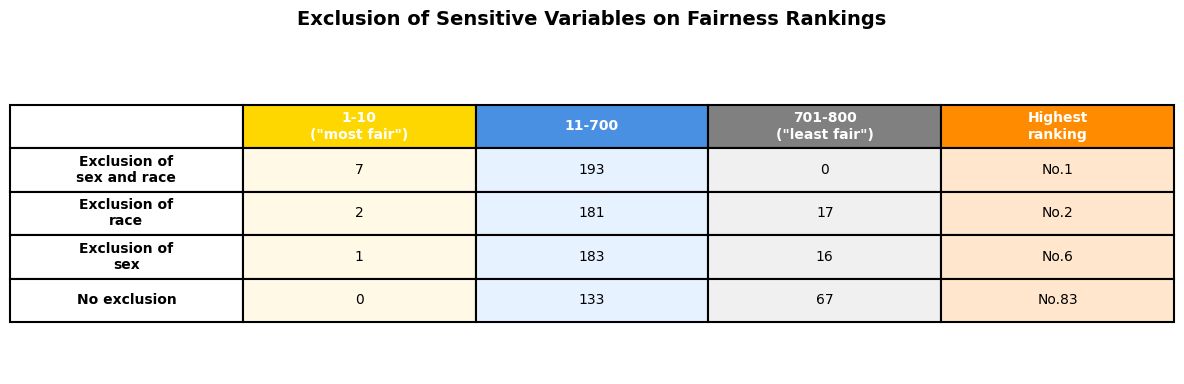


✓ Figure saved as 'exclusion_fairness_rankings.png'
✓ Table saved as 'exclusion_fairness_rankings.csv'


In [ ]:
# Create table showing exclusion scenarios and their fairness rankings

# Access the fairness metrics dataframe stored in faim_obj
# This was created during FAIM_model() execution
fairmetrics_df = faim_obj.fairmetrics_df.copy()

print(f"Found fairmetrics_df with shape: {fairmetrics_df.shape}")
print(f"Columns: {fairmetrics_df.columns.tolist()}")

# Calculate fairness ranking for each model
def compute_area(row):
    """Compute fairness area metric (smaller = more fair)"""
    metrics = ['Equal Opportunity', 'Equalized Odds', 'BER Equality']
    values = [row[m] for m in metrics if m in row]

    n_metric = len(values)
    if n_metric == 0:
        return np.inf

    tmp = values
    tmp_1 = values[1:] + values[:1]

    if n_metric > 2:
        theta_c = 2 * np.pi / n_metric
        area = np.sum(np.array(tmp) * np.array(tmp_1) * np.sin(theta_c))
    elif n_metric == 2:
        area = np.sum(np.array(tmp) * np.array(tmp_1))
    else:
        area = np.abs(tmp[0])

    return area

# Calculate fairness area for each model
fairmetrics_df['fairness_area'] = fairmetrics_df.apply(compute_area, axis=1)

# Rank models (lower area = better fairness = lower rank number)
fairmetrics_df['ranking'] = fairmetrics_df['fairness_area'].rank(method='min').astype(int)

# Create ranking bins
def create_exclusion_ranking_table(df):
    """
    Create a table showing how different exclusion scenarios
    perform across fairness ranking bins
    """

    # Define ranking bins
    bins = [
        (1, 10, "1-10\n(\"most fair\")"),
        (11, 700, "11-700"),
        (701, 800, "701-800\n(\"least fair\")"),
    ]

    # Get unique exclusion cases
    exclusion_cases = df['sen_var_exclusion'].unique()

    # Map cases to readable labels
    case_labels = {}
    for case in exclusion_cases:
        if case == "":
            case_labels[case] = "No exclusion"
        elif len(case.split("_")) == 2:
            case_labels[case] = f"Exclusion of\n{' and '.join(case.split('_'))}"
        elif len(case.split("_")) > 2:
            sens = case.split("_")
            case_labels[case] = f"Exclusion of\n{', '.join(sens[:-1])} and {sens[-1]}"
        else:
            case_labels[case] = f"Exclusion of\n{case}"

    # Initialize results dictionary
    results = []

    for case in exclusion_cases:
        case_data = df[df['sen_var_exclusion'] == case]

        row = {'Exclusion cases': case_labels[case]}

        # Count models in each bin
        for bin_start, bin_end, bin_label in bins:
            count = ((case_data['ranking'] >= bin_start) &
                    (case_data['ranking'] <= bin_end)).sum()
            row[bin_label] = count

        # Find the best (lowest) ranking for this case
        best_ranking = case_data['ranking'].min()
        row['Highest\nranking'] = f"No.{int(best_ranking)}"

        results.append(row)

    # Create DataFrame
    results_df = pd.DataFrame(results)

    # Sort by highest ranking (extract number from "No.X")
    results_df['_sort_key'] = results_df['Highest\nranking'].str.extract(r'(\d+)').astype(int)
    results_df = results_df.sort_values('_sort_key').drop('_sort_key', axis=1)

    return results_df

# Generate table
exclusion_table = create_exclusion_ranking_table(fairmetrics_df)

# Display
print("\n" + "="*80)
print("EXCLUSION OF SENSITIVE VARIABLES ON FAIRNESS RANKINGS")
print("="*80)
print(exclusion_table.to_string(index=False))
print("="*80)

In [ ]:
def safe_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if cm.shape == (1,1):
        if y_true.unique()[0] == 0:
            cm = np.array([[cm[0,0],0],[0,0]])
        else:
            cm = np.array([[0,0],[0,cm[0,0]]])
    return cm.ravel()

def intersectional_metrics(df, cat_vars, y_true_col, y_pred_col, min_group_size=20, max_intersection=3):
    results = []

    for r in range(1, max_intersection + 1):
        for comb in itertools.combinations(cat_vars, r):
            grouped = df.groupby(list(comb))
            for vals, g in grouped:
                if len(g) < min_group_size:
                    continue
                y_true = g[y_true_col]
                y_pred = g[y_pred_col]
                tn, fp, fn, tp = safe_confusion_matrix(y_true, y_pred)
                sr = y_pred.mean()
                acc = (tp + tn) / (tp + tn + fp + fn)
                fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
                fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
                results.append({
                    'intersection': " × ".join(f"{v}={val}" for v,val in zip(comb, vals)) if r>1 else f"{comb[0]}={vals}",
                    'n_samples': len(g),
                    'TPR': tp / (tp + fn) if (tp + fn) > 0 else np.nan,
                    'FPR': fp / (fp + tn) if (fp + tn) > 0 else np.nan,
                    'TNR': tn / (tn + fp) if (tn + fp) > 0 else np.nan,
                    'FNR': fn / (fn + tp) if (fn + tp) > 0 else np.nan,
                    'SR': sr,
                    'Accuracy': acc,
                    'BER': 0.5 * (fpr + fnr)
                })

    return pd.DataFrame(results).round(4).sort_values('n_samples', ascending=False)



FAIRNESS GAP REDUCTION: BASELINE vs FAIM
✓ Baseline threshold: 0.4192
✓ FAIM threshold: 0.4367

SUMMARY: TPR GAP REDUCTION
Sensitive Attribute  Baseline Gap  FAIM Gap  Gap Reduction  Gap Reduction %
                Sex        0.0939    0.0530         0.0409             43.6
               Race        0.1440    0.1154         0.0286             19.9
         Sex × Race        0.2118    0.1902         0.0217             10.2

DETAILED: MIN/MAX GROUPS AND TPR VALUES
Sensitive Attribute Baseline Min Group  Baseline Min TPR Baseline Max Group  Baseline Max TPR  Baseline Gap FAIM Min Group  FAIM Min TPR FAIM Max Group  FAIM Max TPR  FAIM Gap  Gap Reduction  Gap Reduction %
                Sex             Female            0.7543              @Male            0.8483        0.0939         Female        0.7550          @Male        0.8080    0.0530         0.0409             43.6
               Race              Black            0.7353              Asian            0.8793        0.1440         

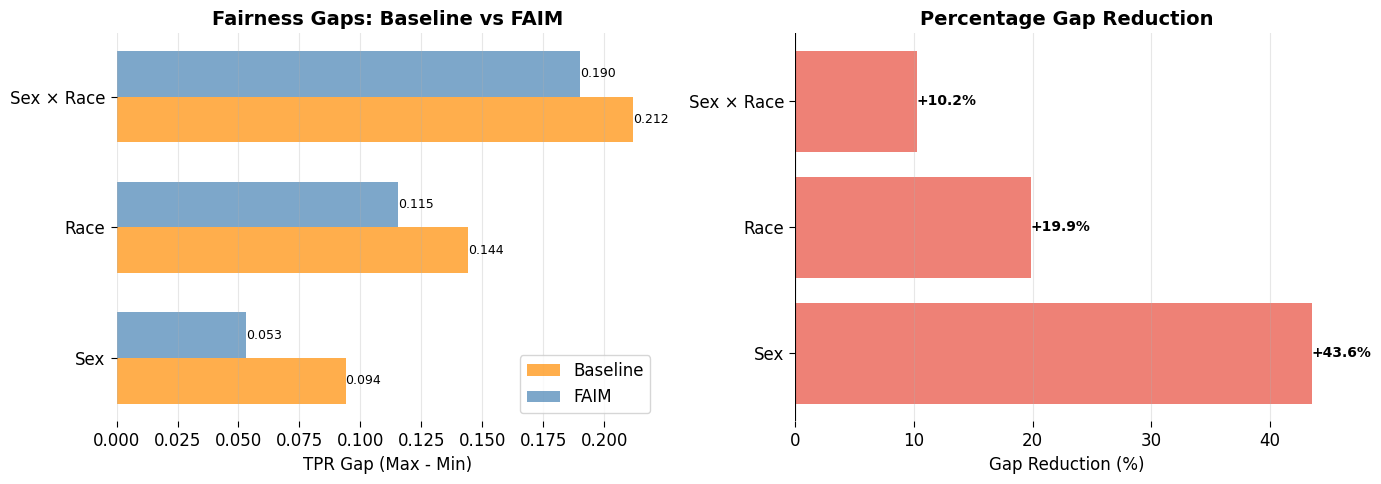


✓ Figure saved as 'fairness_gap_reduction.png'
✓ Tables saved to CSV files

KEY FINDINGS

✓ Sex:
  Gap reduced from 0.0939 to 0.0530
  Reduction: 0.0409 (43.6%)
  Worst group improved: Female (TPR: 0.754 → 0.755)

✓ Race:
  Gap reduced from 0.1440 to 0.1154
  Reduction: 0.0286 (19.9%)
  Worst group improved: Black (TPR: 0.735 → 0.729)

✓ Sex × Race:
  Gap reduced from 0.2118 to 0.1902
  Reduction: 0.0217 (10.2%)
  Worst group improved: Female_Black (TPR: 0.682 → 0.688)

OVERALL: Average gap reduction = 24.5%
✓ FAIM successfully reduced fairness gaps across sensitive attributes


In [ ]:
print("="*80)
print("FAIRNESS GAP REDUCTION: BASELINE vs FAIM")
print("="*80)

# ===== GET BASELINE PREDICTIONS =====
X_test_baseline, _, y_true = faim_obj.data_process(dat_test)
y_pred_prob_baseline = faim_obj.optim_model.predict(
    params=faim_obj.optim_results.params,
    exog=X_test_baseline
)
threshold_baseline = find_optimal_cutoff(y_true, y_pred_prob_baseline, method="auc")[0]
y_pred_bin_baseline = (y_pred_prob_baseline > threshold_baseline).astype(int)

# ===== GET FAIM PREDICTIONS =====
excluded_vars = faim_obj.best_sen_exclusion.split("_")
selected_vars = [i for i in faim_obj.vars if i not in excluded_vars]
selected_vars_cat = [i for i in faim_obj.vars_cat if i not in excluded_vars]

X_test_faim, _, _ = faim_obj.data_process(dat_test, selected_vars, selected_vars_cat)
y_pred_prob_faim = faim_obj.best_optim_base_obj.model_optim.model.predict(
    params=faim_obj.best_coef,
    exog=X_test_faim
)
threshold_faim = find_optimal_cutoff(y_true, y_pred_prob_faim, method="auc")[0]
y_pred_bin_faim = (y_pred_prob_faim > threshold_faim).astype(int)

print(f"✓ Baseline threshold: {threshold_baseline:.4f}")
print(f"✓ FAIM threshold: {threshold_faim:.4f}")

# ===== CONVERT TO NUMPY ARRAYS (FIX INDEX ISSUE) =====
y_true_arr = y_true.values if hasattr(y_true, 'values') else np.array(y_true)
y_pred_bin_baseline_arr = y_pred_bin_baseline.values if hasattr(y_pred_bin_baseline, 'values') else np.array(y_pred_bin_baseline)
y_pred_bin_faim_arr = y_pred_bin_faim.values if hasattr(y_pred_bin_faim, 'values') else np.array(y_pred_bin_faim)

# ===== PREPARE DATA =====
dat_test_copy = dat_test.copy().reset_index(drop=True)
dat_test_copy["Sex_Race"] = dat_test_copy["sex"].astype(str) + "_" + dat_test_copy["race"].astype(str)

def compute_gaps(y_true_arr, y_pred_bin_arr, sensitive_var, var_name):
    """
    Compute min/max TPR gap for a sensitive variable
    """
    from sklearn.metrics import confusion_matrix

    groups = dat_test_copy[sensitive_var].unique()
    tprs = []

    for group in groups:
        mask = (dat_test_copy[sensitive_var] == group).values  # Convert to numpy array
        y_true_group = y_true_arr[mask]
        y_pred_group = y_pred_bin_arr[mask]

        if len(y_true_group) == 0 or y_true_group.sum() == 0:
            continue

        # Compute TPR
        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0,1]).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan

        if not np.isnan(tpr):
            tprs.append({
                'group': group,
                'tpr': tpr,
                'n': len(y_true_group),
                'n_pos': y_true_group.sum()
            })

    if len(tprs) == 0:
        return None, None, None, None, None

    tprs_df = pd.DataFrame(tprs)

    min_tpr = tprs_df['tpr'].min()
    max_tpr = tprs_df['tpr'].max()
    gap = max_tpr - min_tpr

    min_group = tprs_df.loc[tprs_df['tpr'].idxmin(), 'group']
    max_group = tprs_df.loc[tprs_df['tpr'].idxmax(), 'group']

    return gap, min_tpr, max_tpr, min_group, max_group

# ===== COMPUTE GAPS FOR EACH ATTRIBUTE =====
results = []

# SEX
gap_base_sex, min_base_sex, max_base_sex, min_group_sex_base, max_group_sex_base = compute_gaps(
    y_true_arr, y_pred_bin_baseline_arr, 'sex', 'Sex'
)
gap_faim_sex, min_faim_sex, max_faim_sex, min_group_sex_faim, max_group_sex_faim = compute_gaps(
    y_true_arr, y_pred_bin_faim_arr, 'sex', 'Sex'
)

if gap_base_sex is not None and gap_faim_sex is not None:
    results.append({
        'Sensitive Attribute': 'Sex',
        'Baseline Gap': gap_base_sex,
        'Baseline Min Group': min_group_sex_base,
        'Baseline Min TPR': min_base_sex,
        'Baseline Max Group': max_group_sex_base,
        'Baseline Max TPR': max_base_sex,
        'FAIM Gap': gap_faim_sex,
        'FAIM Min Group': min_group_sex_faim,
        'FAIM Min TPR': min_faim_sex,
        'FAIM Max Group': max_group_sex_faim,
        'FAIM Max TPR': max_faim_sex,
        'Gap Reduction': gap_base_sex - gap_faim_sex,
        'Gap Reduction %': (gap_base_sex - gap_faim_sex) / gap_base_sex * 100
    })

# RACE
gap_base_race, min_base_race, max_base_race, min_group_race_base, max_group_race_base = compute_gaps(
    y_true_arr, y_pred_bin_baseline_arr, 'race', 'Race'
)
gap_faim_race, min_faim_race, max_faim_race, min_group_race_faim, max_group_race_faim = compute_gaps(
    y_true_arr, y_pred_bin_faim_arr, 'race', 'Race'
)

if gap_base_race is not None and gap_faim_race is not None:
    results.append({
        'Sensitive Attribute': 'Race',
        'Baseline Gap': gap_base_race,
        'Baseline Min Group': min_group_race_base,
        'Baseline Min TPR': min_base_race,
        'Baseline Max Group': max_group_race_base,
        'Baseline Max TPR': max_base_race,
        'FAIM Gap': gap_faim_race,
        'FAIM Min Group': min_group_race_faim,
        'FAIM Min TPR': min_faim_race,
        'FAIM Max Group': max_group_race_faim,
        'FAIM Max TPR': max_faim_race,
        'Gap Reduction': gap_base_race - gap_faim_race,
        'Gap Reduction %': (gap_base_race - gap_faim_race) / gap_base_race * 100
    })

# SEX × RACE INTERSECTIONS
gap_base_inter, min_base_inter, max_base_inter, min_group_inter_base, max_group_inter_base = compute_gaps(
    y_true_arr, y_pred_bin_baseline_arr, 'Sex_Race', 'Sex × Race'
)
gap_faim_inter, min_faim_inter, max_faim_inter, min_group_inter_faim, max_group_inter_faim = compute_gaps(
    y_true_arr, y_pred_bin_faim_arr, 'Sex_Race', 'Sex × Race'
)

if gap_base_inter is not None and gap_faim_inter is not None:
    results.append({
        'Sensitive Attribute': 'Sex × Race',
        'Baseline Gap': gap_base_inter,
        'Baseline Min Group': min_group_inter_base,
        'Baseline Min TPR': min_base_inter,
        'Baseline Max Group': max_group_inter_base,
        'Baseline Max TPR': max_base_inter,
        'FAIM Gap': gap_faim_inter,
        'FAIM Min Group': min_group_inter_faim,
        'FAIM Min TPR': min_faim_inter,
        'FAIM Max Group': max_group_inter_faim,
        'FAIM Max TPR': max_faim_inter,
        'Gap Reduction': gap_base_inter - gap_faim_inter,
        'Gap Reduction %': (gap_base_inter - gap_faim_inter) / gap_base_inter * 100
    })

# ===== REST OF YOUR CODE (unchanged) =====
results_df = pd.DataFrame(results)

summary_table = results_df[[
    'Sensitive Attribute',
    'Baseline Gap',
    'FAIM Gap',
    'Gap Reduction',
    'Gap Reduction %'
]].copy()

summary_table = summary_table.round({
    'Baseline Gap': 4,
    'FAIM Gap': 4,
    'Gap Reduction': 4,
    'Gap Reduction %': 1
})

print("\n" + "="*80)
print("SUMMARY: TPR GAP REDUCTION")
print("="*80)
print(summary_table.to_string(index=False))

# ... rest of your visualization and output code ...

# ===== DETAILED TABLE =====
detailed_table = results_df[[
    'Sensitive Attribute',
    'Baseline Min Group',
    'Baseline Min TPR',
    'Baseline Max Group',
    'Baseline Max TPR',
    'Baseline Gap',
    'FAIM Min Group',
    'FAIM Min TPR',
    'FAIM Max Group',
    'FAIM Max TPR',
    'FAIM Gap',
    'Gap Reduction',
    'Gap Reduction %'
]].copy()

detailed_table = detailed_table.round({
    'Baseline Min TPR': 4,
    'Baseline Max TPR': 4,
    'Baseline Gap': 4,
    'FAIM Min TPR': 4,
    'FAIM Max TPR': 4,
    'FAIM Gap': 4,
    'Gap Reduction': 4,
    'Gap Reduction %': 1
})

print("\n" + "="*80)
print("DETAILED: MIN/MAX GROUPS AND TPR VALUES")
print("="*80)
print(detailed_table.to_string(index=False))

# ===== VISUALIZATION =====
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Gap comparison
attributes = results_df['Sensitive Attribute'].values
baseline_gaps = results_df['Baseline Gap'].values
faim_gaps = results_df['FAIM Gap'].values

x = np.arange(len(attributes))
width = 0.35

bars1 = ax1.barh(x - width/2, baseline_gaps, width, label='Baseline', color='darkorange', alpha=0.7)
bars2 = ax1.barh(x + width/2, faim_gaps, width, label='FAIM', color='steelblue', alpha=0.7)

ax1.set_yticks(x)
ax1.set_yticklabels(attributes)
ax1.set_frame_on(False)
ax1.set_xlabel('TPR Gap (Max - Min)', fontsize=12)
ax1.set_title('Fairness Gaps: Baseline vs FAIM', fontsize=14, weight='bold')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Add gap values on bars
for i, (base, faim) in enumerate(zip(baseline_gaps, faim_gaps)):
    ax1.text(base, i - width/2, f'{base:.3f}', va='center', ha='left', fontsize=9)
    ax1.text(faim, i + width/2, f'{faim:.3f}', va='center', ha='left', fontsize=9)

# Plot 2: Gap reduction percentage
reductions = results_df['Gap Reduction %'].values
colors = ['#E74C3C' if r > 0 else '#2ECC71' for r in reductions]

bars = ax2.barh(x, reductions, color=colors, alpha=0.7)
ax2.set_yticks(x)
ax2.set_frame_on(False)
ax2.set_yticklabels(attributes)
ax2.set_xlabel('Gap Reduction (%)', fontsize=12)
ax2.set_title('Percentage Gap Reduction', fontsize=14, weight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# Add percentage values
for i, r in enumerate(reductions):
    ha = 'left' if r > 0 else 'right'
    ax2.text(r, i, f'{r:+.1f}%', va='center', ha=ha, fontsize=10, weight='bold')

plt.tight_layout()
plt.savefig('fairness_gap_reduction.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as 'fairness_gap_reduction.png'")

# ===== SAVE TO CSV =====
detailed_table.to_csv('fairness_gap_reduction_detailed.csv', index=False)
summary_table.to_csv('fairness_gap_reduction_summary.csv', index=False)

print("✓ Tables saved to CSV files")

# ===== KEY FINDINGS =====
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

for _, row in results_df.iterrows():
    attr = row['Sensitive Attribute']
    reduction = row['Gap Reduction']
    pct = row['Gap Reduction %']

    if reduction > 0:
        print(f"\n✓ {attr}:")
        print(f"  Gap reduced from {row['Baseline Gap']:.4f} to {row['FAIM Gap']:.4f}")
        print(f"  Reduction: {reduction:.4f} ({pct:.1f}%)")
        print(f"  Worst group improved: {row['Baseline Min Group']} (TPR: {row['Baseline Min TPR']:.3f} → {row['FAIM Min TPR']:.3f})")
    elif reduction < 0:
        print(f"\n⚠️ {attr}:")
        print(f"  Gap INCREASED from {row['Baseline Gap']:.4f} to {row['FAIM Gap']:.4f}")
        print(f"  Change: {reduction:.4f} ({pct:.1f}%)")
    else:
        print(f"\n→ {attr}: No change in gap")

# Overall assessment
avg_reduction = results_df['Gap Reduction %'].mean()
print(f"\n{'='*80}")
print(f"OVERALL: Average gap reduction = {avg_reduction:.1f}%")
if avg_reduction > 10:
    print("✓ FAIM successfully reduced fairness gaps across sensitive attributes")
elif avg_reduction > 0:
    print("→ FAIM provided modest improvement in fairness")
else:
    print("⚠️ FAIM did not improve fairness - consider adjusting parameters")

In [ ]:
summary_table

,Sensitive Attribute,Baseline Gap,FAIM Gap,Gap Reduction,Gap Reduction %
0,Sex,0.0939,0.0530,0.0409,43.6
1,Race,0.1440,0.1154,0.0286,19.9
2,Sex × Race,0.2118,0.1902,0.0217,10.2


#Statistical Significance Testing

In [ ]:
# ==========================================
# CORRECTED SIGNIFICANCE TESTS
# ==========================================

"""
FIXES:
1. Use FIXED threshold (not recalculating in each bootstrap)
2. Test sex, race, and intersections SEPARATELY
3. Match the exact gaps from disparity_table
"""

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

# ==========================================
# FIXED BOOTSTRAP WITH SINGLE THRESHOLD
# ==========================================

def bootstrap_gap_fixed_threshold(y_true, y_pred_prob, sen_var, threshold,
                                   metric='tpr', n_bootstrap=1000, alpha=0.05, seed=42):
    """
    Bootstrap with FIXED threshold (matches your disparity_table calculation)

    This is the correct way to match your reported gaps!
    """
    np.random.seed(seed)

    n = len(y_true)
    groups = sen_var.unique()

    # Use FIXED threshold to get predictions
    y_pred_bin = (y_pred_prob > threshold).astype(int)

    gaps = []

    # Pre-convert to numpy
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.array(y_true)
    y_pred_arr = y_pred_bin.values if hasattr(y_pred_bin, 'values') else np.array(y_pred_bin)
    sen_var_arr = sen_var.values if hasattr(sen_var, 'values') else np.array(sen_var)

    print(f"Running {n_bootstrap} bootstrap iterations with fixed threshold={threshold:.4f}...")

    for _ in tqdm(range(n_bootstrap), desc="Bootstrap"):
        # Resample
        indices = np.random.choice(n, size=n, replace=True)

        y_true_boot = y_true_arr[indices]
        y_pred_boot = y_pred_arr[indices]
        sen_var_boot = sen_var_arr[indices]

        # Calculate metric for each group
        group_metrics = []

        for group in groups:
            mask = sen_var_boot == group
            if mask.sum() < 10:
                continue

            y_true_g = y_true_boot[mask]
            y_pred_g = y_pred_boot[mask]

            if metric == 'tpr':
                n_pos = (y_true_g == 1).sum()
                if n_pos == 0:
                    continue
                tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
                val = tp / n_pos
            elif metric == 'fpr':
                n_neg = (y_true_g == 0).sum()
                if n_neg == 0:
                    continue
                fp = ((y_true_g == 0) & (y_pred_g == 1)).sum()
                val = fp / n_neg
            elif metric == 'ber':
                n_pos = (y_true_g == 1).sum()
                n_neg = (y_true_g == 0).sum()
                if n_pos == 0 or n_neg == 0:
                    continue
                tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
                fp = ((y_true_g == 0) & (y_pred_g == 1)).sum()
                tpr = tp / n_pos
                fpr = fp / n_neg
                val = 0.5 * (fpr + (1 - tpr))

            group_metrics.append(val)

        if len(group_metrics) >= 2:
            gaps.append(max(group_metrics) - min(group_metrics))

    gaps = np.array(gaps)

    # Calculate CI
    ci_lower = np.percentile(gaps, alpha/2 * 100)
    ci_upper = np.percentile(gaps, (1 - alpha/2) * 100)
    gap_mean = np.mean(gaps)

    # Also calculate the OBSERVED gap (should match your table!)
    y_pred_bin_full = (y_pred_prob > threshold).astype(int)
    observed_metrics = []
    for group in groups:
        mask = sen_var == group
        if mask.sum() < 10:
            continue

        y_true_g = y_true[mask]
        y_pred_g = y_pred_bin_full[mask]

        if metric == 'tpr':
            n_pos = (y_true_g == 1).sum()
            if n_pos == 0:
                continue
            tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
            val = tp / n_pos
        elif metric == 'ber':
            n_pos = (y_true_g == 1).sum()
            n_neg = (y_true_g == 0).sum()
            if n_pos == 0 or n_neg == 0:
                continue
            tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
            fp = ((y_true_g == 0) & (y_pred_g == 1)).sum()
            tpr = tp / n_pos
            fpr = fp / n_neg
            val = 0.5 * (fpr + (1 - tpr))

        observed_metrics.append(val)

    observed_gap = max(observed_metrics) - min(observed_metrics)

    return {
        'gap': gap_mean,
        'observed_gap': observed_gap,  # This should match your table!
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'bootstrap_dist': gaps
    }


# ==========================================
# COMPREHENSIVE SIGNIFICANCE TESTS
# ==========================================

def comprehensive_significance_test(y_true,
                                    y_pred_prob_baseline, threshold_baseline,
                                    y_pred_prob_faim, threshold_faim,
                                    dat_test,
                                    metric='tpr',
                                    n_bootstrap=1000):
    """
    Test significance for SEX, RACE, and INTERSECTIONS separately
    """

    results = {}

    # Reset indices
    y_true = y_true.reset_index(drop=True)
    dat_test_reset = dat_test.reset_index(drop=True)
    y_pred_prob_baseline = pd.Series(y_pred_prob_baseline).reset_index(drop=True)
    y_pred_prob_faim = pd.Series(y_pred_prob_faim).reset_index(drop=True)

    # ===== TEST 1: SEX =====
    print("\n" + "="*80)
    print("TEST 1: SEX")
    print("="*80)

    sen_sex = dat_test_reset["sex"]

    baseline_sex = bootstrap_gap_fixed_threshold(
        y_true, y_pred_prob_baseline, sen_sex, threshold_baseline,
        metric=metric, n_bootstrap=n_bootstrap, seed=42
    )

    faim_sex = bootstrap_gap_fixed_threshold(
        y_true, y_pred_prob_faim, sen_sex, threshold_faim,
        metric=metric, n_bootstrap=n_bootstrap, seed=43
    )

    # Calculate p-value
    diff_sex = baseline_sex['bootstrap_dist'] - faim_sex['bootstrap_dist']
    p_value_sex = np.mean(diff_sex <= 0)

    print(f"\nBaseline {metric.upper()} gap (sex): {baseline_sex['observed_gap']:.4f}")
    print(f"  Bootstrap mean: {baseline_sex['gap']:.4f}")
    print(f"  95% CI: [{baseline_sex['ci_lower']:.4f}, {baseline_sex['ci_upper']:.4f}]")

    print(f"\nFAIM {metric.upper()} gap (sex): {faim_sex['observed_gap']:.4f}")
    print(f"  Bootstrap mean: {faim_sex['gap']:.4f}")
    print(f"  95% CI: [{faim_sex['ci_lower']:.4f}, {faim_sex['ci_upper']:.4f}]")

    print(f"\nGap reduction: {baseline_sex['observed_gap'] - faim_sex['observed_gap']:.4f}")
    print(f"P-value (one-sided): {p_value_sex:.4f}")

    if p_value_sex < 0.05:
        print("✓ SIGNIFICANT at α=0.05")
    else:
        print("✗ NOT significant at α=0.05")

    results['sex'] = {
        'baseline_gap': baseline_sex['observed_gap'],
        'faim_gap': faim_sex['observed_gap'],
        'reduction': baseline_sex['observed_gap'] - faim_sex['observed_gap'],
        'p_value': p_value_sex,
        'significant': p_value_sex < 0.05
    }

    # ===== TEST 2: RACE =====
    print("\n" + "="*80)
    print("TEST 2: RACE")
    print("="*80)

    sen_race = dat_test_reset["race"]

    baseline_race = bootstrap_gap_fixed_threshold(
        y_true, y_pred_prob_baseline, sen_race, threshold_baseline,
        metric=metric, n_bootstrap=n_bootstrap, seed=44
    )

    faim_race = bootstrap_gap_fixed_threshold(
        y_true, y_pred_prob_faim, sen_race, threshold_faim,
        metric=metric, n_bootstrap=n_bootstrap, seed=45
    )

    diff_race = baseline_race['bootstrap_dist'] - faim_race['bootstrap_dist']
    p_value_race = np.mean(diff_race <= 0)

    print(f"\nBaseline {metric.upper()} gap (race): {baseline_race['observed_gap']:.4f}")
    print(f"  Bootstrap mean: {baseline_race['gap']:.4f}")
    print(f"  95% CI: [{baseline_race['ci_lower']:.4f}, {baseline_race['ci_upper']:.4f}]")

    print(f"\nFAIM {metric.upper()} gap (race): {faim_race['observed_gap']:.4f}")
    print(f"  Bootstrap mean: {faim_race['gap']:.4f}")
    print(f"  95% CI: [{faim_race['ci_lower']:.4f}, {faim_race['ci_upper']:.4f}]")

    print(f"\nGap reduction: {baseline_race['observed_gap'] - faim_race['observed_gap']:.4f}")
    print(f"P-value (one-sided): {p_value_race:.4f}")

    if p_value_race < 0.05:
        print("✓ SIGNIFICANT at α=0.05")
    else:
        print("✗ NOT significant at α=0.05")

    results['race'] = {
        'baseline_gap': baseline_race['observed_gap'],
        'faim_gap': faim_race['observed_gap'],
        'reduction': baseline_race['observed_gap'] - faim_race['observed_gap'],
        'p_value': p_value_race,
        'significant': p_value_race < 0.05
    }

    # ===== TEST 3: INTERSECTIONS =====
    print("\n" + "="*80)
    print("TEST 3: INTERSECTIONS (SEX × RACE)")
    print("="*80)

    sen_intersect = dat_test_reset["sex"].astype(str) + "_" + dat_test_reset["race"].astype(str)
    sen_intersect = pd.Series(sen_intersect).reset_index(drop=True)

    baseline_intersect = bootstrap_gap_fixed_threshold(
        y_true, y_pred_prob_baseline, sen_intersect, threshold_baseline,
        metric=metric, n_bootstrap=n_bootstrap, seed=46
    )

    faim_intersect = bootstrap_gap_fixed_threshold(
        y_true, y_pred_prob_faim, sen_intersect, threshold_faim,
        metric=metric, n_bootstrap=n_bootstrap, seed=47
    )

    diff_intersect = baseline_intersect['bootstrap_dist'] - faim_intersect['bootstrap_dist']
    p_value_intersect = np.mean(diff_intersect <= 0)

    print(f"\nBaseline {metric.upper()} gap (intersections): {baseline_intersect['observed_gap']:.4f}")
    print(f"  Bootstrap mean: {baseline_intersect['gap']:.4f}")
    print(f"  95% CI: [{baseline_intersect['ci_lower']:.4f}, {baseline_intersect['ci_upper']:.4f}]")

    print(f"\nFAIM {metric.upper()} gap (intersections): {faim_intersect['observed_gap']:.4f}")
    print(f"  Bootstrap mean: {faim_intersect['gap']:.4f}")
    print(f"  95% CI: [{faim_intersect['ci_lower']:.4f}, {faim_intersect['ci_upper']:.4f}]")

    print(f"\nGap reduction: {baseline_intersect['observed_gap'] - faim_intersect['observed_gap']:.4f}")
    print(f"P-value (one-sided): {p_value_intersect:.4f}")

    if p_value_intersect < 0.05:
        print("✓ SIGNIFICANT at α=0.05")
    else:
        print("✗ NOT significant at α=0.05")

    results['intersections'] = {
        'baseline_gap': baseline_intersect['observed_gap'],
        'faim_gap': faim_intersect['observed_gap'],
        'reduction': baseline_intersect['observed_gap'] - faim_intersect['observed_gap'],
        'p_value': p_value_intersect,
        'significant': p_value_intersect < 0.05
    }

    # ===== SUMMARY =====
    print("\n" + "="*80)
    print("SUMMARY OF SIGNIFICANCE TESTS")
    print("="*80)

    summary_df = pd.DataFrame({
        'Grouping': ['Sex', 'Race', 'Sex × Race'],
        'Baseline Gap': [results['sex']['baseline_gap'],
                        results['race']['baseline_gap'],
                        results['intersections']['baseline_gap']],
        'FAIM Gap': [results['sex']['faim_gap'],
                    results['race']['faim_gap'],
                    results['intersections']['faim_gap']],
        'Reduction': [results['sex']['reduction'],
                     results['race']['reduction'],
                     results['intersections']['reduction']],
        'P-value': [results['sex']['p_value'],
                   results['race']['p_value'],
                   results['intersections']['p_value']],
        'Significant': [results['sex']['significant'],
                       results['race']['significant'],
                       results['intersections']['significant']]
    })

    print("\n" + summary_df.to_string(index=False))

    n_significant = summary_df['Significant'].sum()
    print(f"\n{n_significant}/3 tests show significant improvement")

    return results, summary_df

In [ ]:
# ==========================================
# HOW TO USE
# ==========================================

# 1. Get predictions with FIXED thresholds
y_true = dat_test["imv"].reset_index(drop=True)

# Baseline
X_baseline, _, _ = fairbase.data_process(dat_test)
y_pred_prob_baseline = faim_obj.optim_model.predict(
    params=faim_obj.optim_results.params,
    exog=X_baseline
)
threshold_baseline = find_optimal_cutoff(y_true, y_pred_prob_baseline, method="auc")[0]

# FAIM
excluded = faim_obj.best_sen_exclusion.split("_")
sel_vars = [v for v in faim_obj.vars if v not in excluded]
sel_vars_cat = [v for v in faim_obj.vars_cat if v not in excluded]
X_faim, _, _ = faim_obj.data_process(dat_test, sel_vars, sel_vars_cat)
y_pred_prob_faim = faim_obj.best_optim_base_obj.model_optim.model.predict(
    params=faim_obj.best_coef,
    exog=X_faim
)
threshold_faim = find_optimal_cutoff(y_true, y_pred_prob_faim, method="auc")[0]

print(f"Baseline threshold: {threshold_baseline:.4f}")
print(f"FAIM threshold: {threshold_faim:.4f}")

# 2. Run comprehensive tests
results, summary = comprehensive_significance_test(
    y_true,
    y_pred_prob_baseline, threshold_baseline,
    y_pred_prob_faim, threshold_faim,
    dat_test,
    metric='tpr',  # or 'ber'
    n_bootstrap=1000
)

# 3. Check results
print("\\nYour disparity table shows:")
print("  Baseline TPR gap (intersections): 0.2118")
print("  FAIM TPR gap (intersections): 0.1902")

print("\\nOur calculated gaps:")
print(f"  Baseline: {results['intersections']['baseline_gap']:.4f}")
print(f"  FAIM: {results['intersections']['faim_gap']:.4f}")

# They should MATCH now!

Baseline threshold: 0.4192
FAIM threshold: 0.4367

TEST 1: SEX
Running 1000 bootstrap iterations with fixed threshold=0.4192...


Bootstrap: 100%|██████████| 1000/1000 [00:01<00:00, 699.20it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4367...


Bootstrap: 100%|██████████| 1000/1000 [00:01<00:00, 758.12it/s]



Baseline TPR gap (sex): 0.0939
  Bootstrap mean: 0.0941
  95% CI: [0.0682, 0.1214]

FAIM TPR gap (sex): 0.0530
  Bootstrap mean: 0.0531
  95% CI: [0.0270, 0.0812]

Gap reduction: 0.0409
P-value (one-sided): 0.0120
✓ SIGNIFICANT at α=0.05

TEST 2: RACE
Running 1000 bootstrap iterations with fixed threshold=0.4192...


Bootstrap: 100%|██████████| 1000/1000 [00:01<00:00, 686.58it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4367...


Bootstrap: 100%|██████████| 1000/1000 [00:01<00:00, 643.40it/s]



Baseline TPR gap (race): 0.1440
  Bootstrap mean: 0.1466
  95% CI: [0.0774, 0.2175]

FAIM TPR gap (race): 0.1154
  Bootstrap mean: 0.1260
  95% CI: [0.0585, 0.1972]

Gap reduction: 0.0286
P-value (one-sided): 0.3430
✗ NOT significant at α=0.05

TEST 3: INTERSECTIONS (SEX × RACE)
Running 1000 bootstrap iterations with fixed threshold=0.4192...


Bootstrap: 100%|██████████| 1000/1000 [00:09<00:00, 106.39it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4367...


Bootstrap: 100%|██████████| 1000/1000 [00:04<00:00, 215.18it/s]


Baseline TPR gap (intersections): 0.2118
  Bootstrap mean: 0.2327
  95% CI: [0.1474, 0.3244]

FAIM TPR gap (intersections): 0.1902
  Bootstrap mean: 0.2183
  95% CI: [0.1300, 0.3357]

Gap reduction: 0.0217
P-value (one-sided): 0.4130
✗ NOT significant at α=0.05

SUMMARY OF SIGNIFICANCE TESTS

  Grouping  Baseline Gap  FAIM Gap  Reduction  P-value  Significant
       Sex      0.093948  0.053028   0.040919    0.012         True
      Race      0.144016  0.115416   0.028600    0.343        False
Sex × Race      0.211805  0.190151   0.021654    0.413        False

1/3 tests show significant improvement
\nYour disparity table shows:
  Baseline TPR gap (intersections): 0.2118
  FAIM TPR gap (intersections): 0.1902
\nOur calculated gaps:
  Baseline: 0.2118
  FAIM: 0.1902


RUNNING PERMUTATION TESTS

PERMUTATION TEST 1: SEX
Running 1000 permutations with fixed thresholds...


Permutations: 100%|██████████| 1000/1000 [00:25<00:00, 39.59it/s]



Observed baseline gap: 0.0939
Observed FAIM gap: 0.0530
Observed difference: 0.0409
P-value (one-sided): 0.0000
P-value (two-sided): 0.0000
✓ SIGNIFICANT at α=0.05

PERMUTATION TEST 2: RACE
Running 1000 permutations with fixed thresholds...


Permutations: 100%|██████████| 1000/1000 [00:12<00:00, 77.23it/s]



Observed baseline gap: 0.1440
Observed FAIM gap: 0.1154
Observed difference: 0.0286
P-value (one-sided): 0.1180
P-value (two-sided): 0.2500
✗ NOT significant at α=0.05

PERMUTATION TEST 3: INTERSECTIONS (SEX × RACE)
Running 1000 permutations with fixed thresholds...


Permutations: 100%|██████████| 1000/1000 [00:21<00:00, 46.78it/s]



Observed baseline gap: 0.2118
Observed FAIM gap: 0.1902
Observed difference: 0.0217
P-value (one-sided): 0.1670
P-value (two-sided): 0.3400
✗ NOT significant at α=0.05

PERMUTATION TEST SUMMARY

  Grouping  Baseline Gap  FAIM Gap  Difference  P-value  Significant
       Sex      0.093948  0.053028    0.040919    0.000         True
      Race      0.144016  0.115416    0.028600    0.118        False
Sex × Race      0.211805  0.190151    0.021654    0.167        False

1/3 tests show significant improvement

CREATING VISUALIZATIONS
Running 1000 bootstrap iterations with fixed threshold=0.4192...


Bootstrap: 100%|██████████| 1000/1000 [00:00<00:00, 1162.24it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4367...


Bootstrap: 100%|██████████| 1000/1000 [00:00<00:00, 1026.64it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4192...


Bootstrap: 100%|██████████| 1000/1000 [00:01<00:00, 737.40it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4367...


Bootstrap: 100%|██████████| 1000/1000 [00:01<00:00, 770.48it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4192...


Bootstrap: 100%|██████████| 1000/1000 [00:03<00:00, 252.90it/s]


Running 1000 bootstrap iterations with fixed threshold=0.4367...


Bootstrap: 100%|██████████| 1000/1000 [00:04<00:00, 245.61it/s]


✓ Saved: output/bootstrap_distributions.png
✓ Saved: output/permutation_tests.png
✓ Saved: output/significance_summary.png


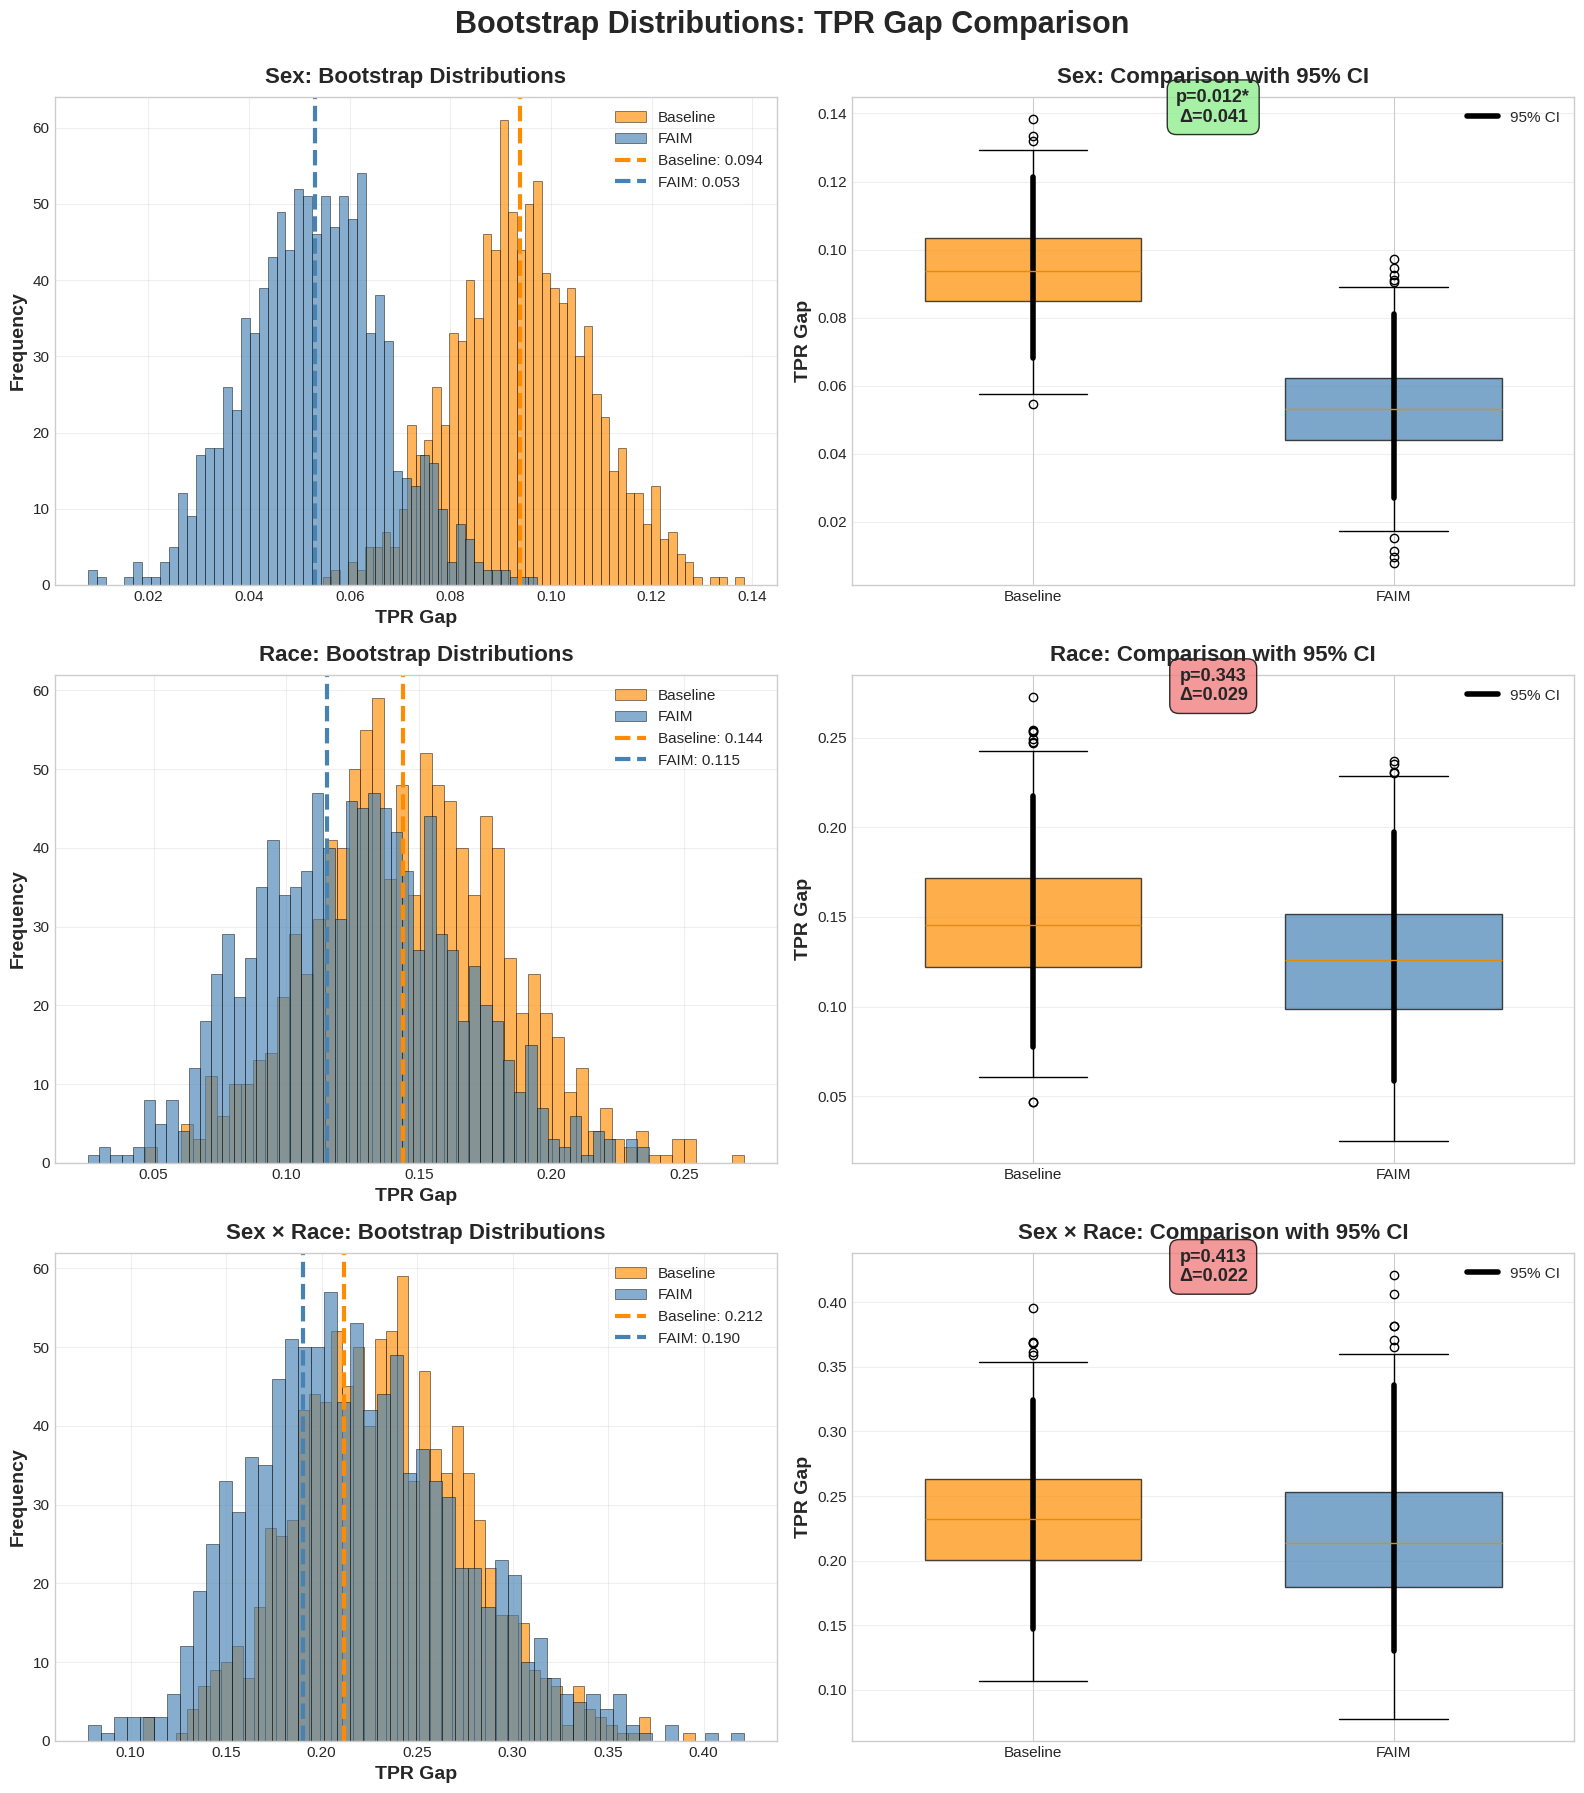

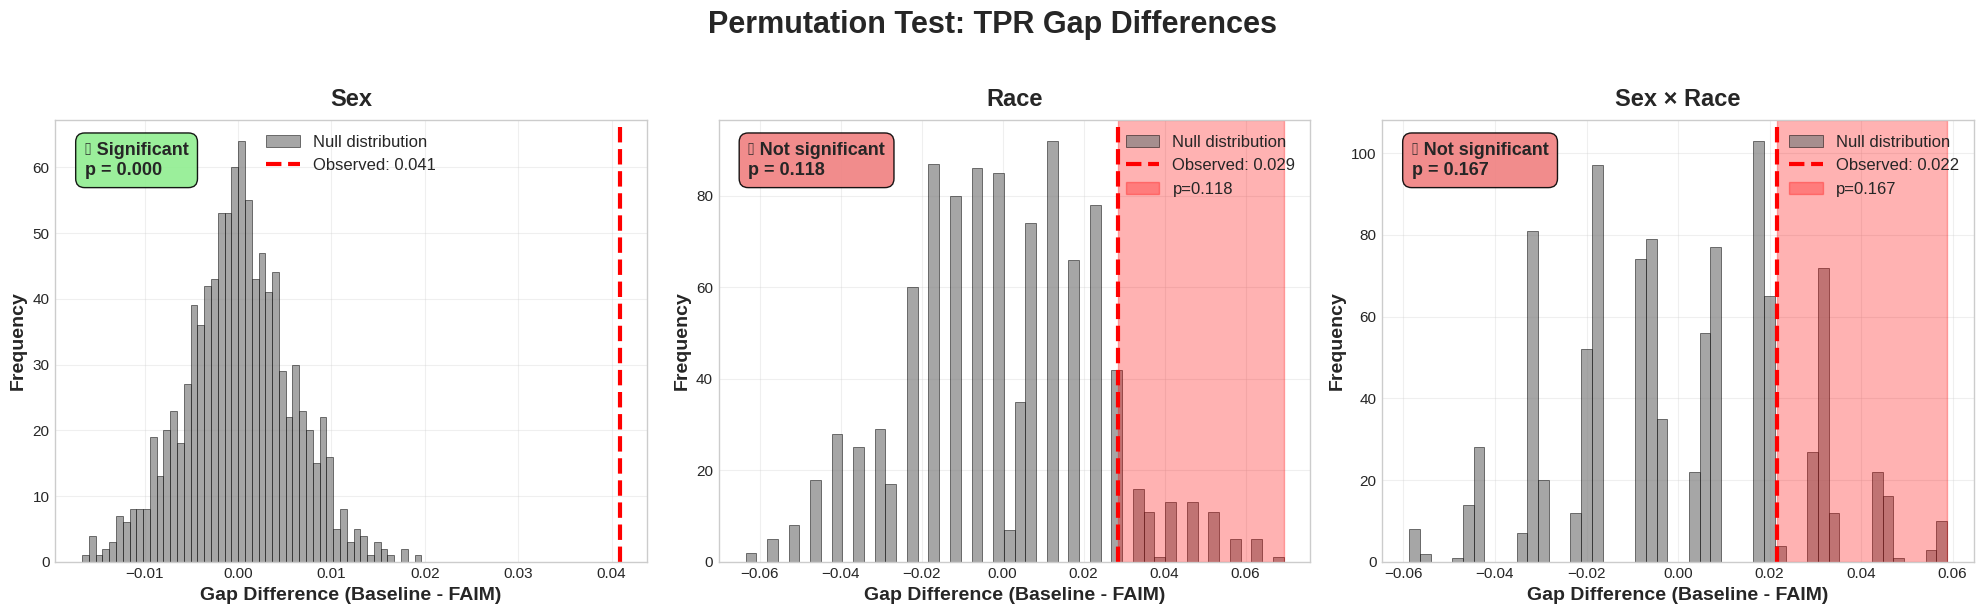

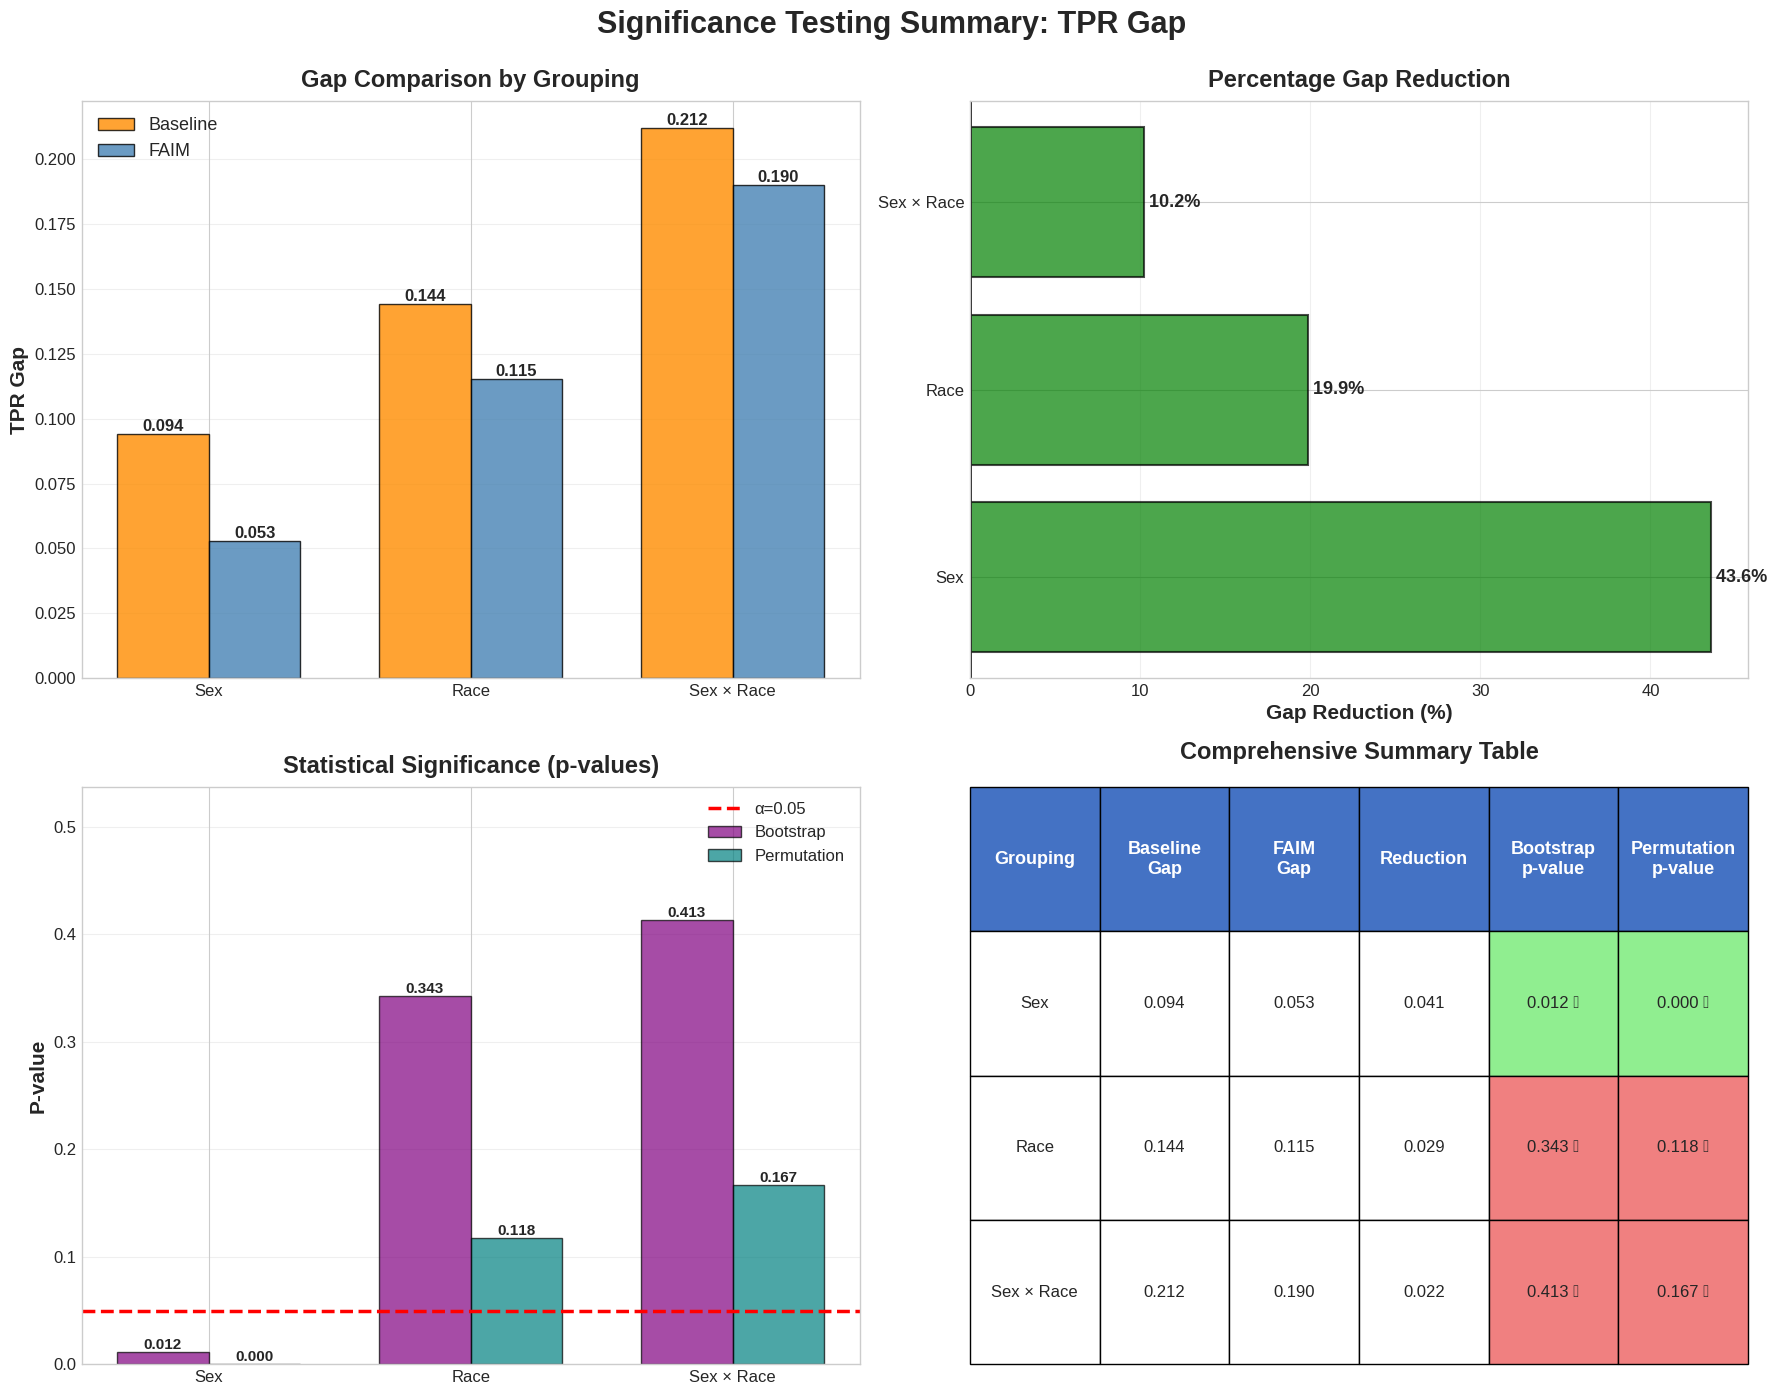


VISUALIZATION COMPLETE

Generated 3 figures:
  1. output/bootstrap_distributions.png
  2. output/permutation_tests.png
  3. output/significance_summary.png

✓ All significance testing complete!


In [ ]:
# ==========================================
# PERMUTATION TESTING + VISUALIZATIONS
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm

# ==========================================
# PERMUTATION TEST FUNCTION
# ==========================================

def permutation_test_fairness(y_true,
                              y_pred_prob_baseline, threshold_baseline,
                              y_pred_prob_faim, threshold_faim,
                              sen_var,
                              metric='tpr',
                              n_permutations=1000,
                              seed=42):
    """
    Permutation test to compare fairness gaps between baseline and FAIM

    H0: The two models have the same fairness gap
    H1: FAIM has smaller gap than baseline

    Returns p-value and permutation distribution
    """
    np.random.seed(seed)

    print(f"Running {n_permutations} permutations with fixed thresholds...")

    # Convert to binary predictions with FIXED thresholds
    y_pred_baseline = (y_pred_prob_baseline > threshold_baseline).astype(int)
    y_pred_faim = (y_pred_prob_faim > threshold_faim).astype(int)

    # Convert to numpy arrays
    y_true_arr = y_true.values if hasattr(y_true, 'values') else np.array(y_true)
    y_pred_baseline_arr = y_pred_baseline.values if hasattr(y_pred_baseline, 'values') else np.array(y_pred_baseline)
    y_pred_faim_arr = y_pred_faim.values if hasattr(y_pred_faim, 'values') else np.array(y_pred_faim)
    sen_var_arr = sen_var.values if hasattr(sen_var, 'values') else np.array(sen_var)

    # Function to calculate gap
    def calculate_gap(y_true, y_pred, sen_var, metric):
        groups = np.unique(sen_var)
        group_metrics = []

        for group in groups:
            mask = sen_var == group
            if mask.sum() < 10:
                continue

            y_true_g = y_true[mask]
            y_pred_g = y_pred[mask]

            if metric == 'tpr':
                n_pos = (y_true_g == 1).sum()
                if n_pos == 0:
                    continue
                tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
                val = tp / n_pos
            elif metric == 'ber':
                n_pos = (y_true_g == 1).sum()
                n_neg = (y_true_g == 0).sum()
                if n_pos == 0 or n_neg == 0:
                    continue
                tp = ((y_true_g == 1) & (y_pred_g == 1)).sum()
                fp = ((y_true_g == 0) & (y_pred_g == 1)).sum()
                tpr = tp / n_pos
                fpr = fp / n_neg
                val = 0.5 * (fpr + (1 - tpr))

            group_metrics.append(val)

        return max(group_metrics) - min(group_metrics) if len(group_metrics) >= 2 else 0

    # Calculate observed difference
    gap_baseline = calculate_gap(y_true_arr, y_pred_baseline_arr, sen_var_arr, metric)
    gap_faim = calculate_gap(y_true_arr, y_pred_faim_arr, sen_var_arr, metric)
    observed_diff = gap_baseline - gap_faim

    # Permutation test
    permuted_diffs = []

    for _ in tqdm(range(n_permutations), desc="Permutations"):
        # Randomly swap model labels for each observation
        swap = np.random.rand(len(y_true_arr)) > 0.5

        y_pred_perm1 = y_pred_baseline_arr.copy()
        y_pred_perm2 = y_pred_faim_arr.copy()

        # Swap predictions where swap is True
        y_pred_perm1[swap] = y_pred_faim_arr[swap]
        y_pred_perm2[swap] = y_pred_baseline_arr[swap]

        # Calculate gaps for permuted predictions
        gap1 = calculate_gap(y_true_arr, y_pred_perm1, sen_var_arr, metric)
        gap2 = calculate_gap(y_true_arr, y_pred_perm2, sen_var_arr, metric)

        permuted_diffs.append(gap1 - gap2)

    permuted_diffs = np.array(permuted_diffs)

    # Calculate p-value (one-sided: H1: baseline > FAIM)
    p_value_one_sided = np.mean(permuted_diffs >= observed_diff)

    # Two-sided p-value
    p_value_two_sided = np.mean(np.abs(permuted_diffs) >= np.abs(observed_diff))

    return {
        'observed_diff': observed_diff,
        'gap_baseline': gap_baseline,
        'gap_faim': gap_faim,
        'p_value_one_sided': p_value_one_sided,
        'p_value_two_sided': p_value_two_sided,
        'permuted_dist': permuted_diffs,
        'significant': p_value_one_sided < 0.05
    }


def comprehensive_permutation_test(y_true,
                                   y_pred_prob_baseline, threshold_baseline,
                                   y_pred_prob_faim, threshold_faim,
                                   dat_test,
                                   metric='tpr',
                                   n_permutations=1000):
    """
    Run permutation tests for sex, race, and intersections
    """

    results = {}

    # Reset indices
    y_true = y_true.reset_index(drop=True)
    dat_test_reset = dat_test.reset_index(drop=True)
    y_pred_prob_baseline = pd.Series(y_pred_prob_baseline).reset_index(drop=True)
    y_pred_prob_faim = pd.Series(y_pred_prob_faim).reset_index(drop=True)

    # Test 1: Sex
    print("\n" + "="*80)
    print("PERMUTATION TEST 1: SEX")
    print("="*80)

    perm_sex = permutation_test_fairness(
        y_true, y_pred_prob_baseline, threshold_baseline,
        y_pred_prob_faim, threshold_faim,
        dat_test_reset["sex"],
        metric=metric, n_permutations=n_permutations, seed=42
    )

    print(f"\nObserved baseline gap: {perm_sex['gap_baseline']:.4f}")
    print(f"Observed FAIM gap: {perm_sex['gap_faim']:.4f}")
    print(f"Observed difference: {perm_sex['observed_diff']:.4f}")
    print(f"P-value (one-sided): {perm_sex['p_value_one_sided']:.4f}")
    print(f"P-value (two-sided): {perm_sex['p_value_two_sided']:.4f}")

    if perm_sex['significant']:
        print("✓ SIGNIFICANT at α=0.05")
    else:
        print("✗ NOT significant at α=0.05")

    results['sex'] = perm_sex

    # Test 2: Race
    print("\n" + "="*80)
    print("PERMUTATION TEST 2: RACE")
    print("="*80)

    perm_race = permutation_test_fairness(
        y_true, y_pred_prob_baseline, threshold_baseline,
        y_pred_prob_faim, threshold_faim,
        dat_test_reset["race"],
        metric=metric, n_permutations=n_permutations, seed=43
    )

    print(f"\nObserved baseline gap: {perm_race['gap_baseline']:.4f}")
    print(f"Observed FAIM gap: {perm_race['gap_faim']:.4f}")
    print(f"Observed difference: {perm_race['observed_diff']:.4f}")
    print(f"P-value (one-sided): {perm_race['p_value_one_sided']:.4f}")
    print(f"P-value (two-sided): {perm_race['p_value_two_sided']:.4f}")

    if perm_race['significant']:
        print("✓ SIGNIFICANT at α=0.05")
    else:
        print("✗ NOT significant at α=0.05")

    results['race'] = perm_race

    # Test 3: Intersections
    print("\n" + "="*80)
    print("PERMUTATION TEST 3: INTERSECTIONS (SEX × RACE)")
    print("="*80)

    sen_intersect = dat_test_reset["sex"].astype(str) + "_" + dat_test_reset["race"].astype(str)

    perm_intersect = permutation_test_fairness(
        y_true, y_pred_prob_baseline, threshold_baseline,
        y_pred_prob_faim, threshold_faim,
        sen_intersect,
        metric=metric, n_permutations=n_permutations, seed=44
    )

    print(f"\nObserved baseline gap: {perm_intersect['gap_baseline']:.4f}")
    print(f"Observed FAIM gap: {perm_intersect['gap_faim']:.4f}")
    print(f"Observed difference: {perm_intersect['observed_diff']:.4f}")
    print(f"P-value (one-sided): {perm_intersect['p_value_one_sided']:.4f}")
    print(f"P-value (two-sided): {perm_intersect['p_value_two_sided']:.4f}")

    if perm_intersect['significant']:
        print("✓ SIGNIFICANT at α=0.05")
    else:
        print("✗ NOT significant at α=0.05")

    results['intersections'] = perm_intersect

    # Summary
    print("\n" + "="*80)
    print("PERMUTATION TEST SUMMARY")
    print("="*80)

    summary_df = pd.DataFrame({
        'Grouping': ['Sex', 'Race', 'Sex × Race'],
        'Baseline Gap': [perm_sex['gap_baseline'], perm_race['gap_baseline'], perm_intersect['gap_baseline']],
        'FAIM Gap': [perm_sex['gap_faim'], perm_race['gap_faim'], perm_intersect['gap_faim']],
        'Difference': [perm_sex['observed_diff'], perm_race['observed_diff'], perm_intersect['observed_diff']],
        'P-value': [perm_sex['p_value_one_sided'], perm_race['p_value_one_sided'], perm_intersect['p_value_one_sided']],
        'Significant': [perm_sex['significant'], perm_race['significant'], perm_intersect['significant']]
    })

    print("\n" + summary_df.to_string(index=False))

    n_significant = summary_df['Significant'].sum()
    print(f"\n{n_significant}/3 tests show significant improvement")

    return results, summary_df


# ==========================================
# COMPREHENSIVE VISUALIZATIONS
# ==========================================

def create_comprehensive_visualizations(bootstrap_results, permutation_results,
                                        metric='TPR', output_dir='output'):
    """
    Create publication-quality visualizations
    """
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("colorblind")

    groupings = ['sex', 'race', 'intersections']
    titles = ['Sex', 'Race', 'Sex × Race']

    # ==========================================
    # FIGURE 1: Bootstrap Distributions (3x2 grid)
    # ==========================================

    fig1, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig1.suptitle(f'Bootstrap Distributions: {metric} Gap Comparison',
                  fontsize=22, weight='bold', y=0.995)

    for i, (grouping, title) in enumerate(zip(groupings, titles)):
        # Get bootstrap distributions from results dict
        baseline_dist = bootstrap_results[grouping]['baseline']['bootstrap_dist']
        faim_dist = bootstrap_results[grouping]['faim']['bootstrap_dist']

        baseline_gap = bootstrap_results[grouping]['baseline']['observed_gap']
        faim_gap = bootstrap_results[grouping]['faim']['observed_gap']

        # Left: Histograms
        ax = axes[i, 0]
        ax.hist(baseline_dist, bins=50, alpha=0.65, label='Baseline', color='darkorange', edgecolor='black', linewidth=0.5)
        ax.hist(faim_dist, bins=50, alpha=0.65, label='FAIM', color='steelblue', edgecolor='black', linewidth=0.5)

        ax.axvline(baseline_gap, color='darkorange', linestyle='--', linewidth=3, label=f'Baseline: {baseline_gap:.3f}')
        ax.axvline(faim_gap, color='steelblue', linestyle='--', linewidth=3, label=f'FAIM: {faim_gap:.3f}')

        ax.set_xlabel(f'{metric} Gap', fontsize=14, weight='bold')
        ax.set_ylabel('Frequency', fontsize=14, weight='bold')
        ax.set_title(f'{title}: Bootstrap Distributions', fontsize=16, weight='bold', pad=10)
        ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=11)

        # Right: Box plots with CIs
        ax = axes[i, 1]

        data = [baseline_dist, faim_dist]
        bp = ax.boxplot(data, labels=['Baseline', 'FAIM'], patch_artist=True, widths=0.6)

        bp['boxes'][0].set_facecolor('darkorange')
        bp['boxes'][0].set_alpha(0.7)
        bp['boxes'][1].set_facecolor('steelblue')
        bp['boxes'][1].set_alpha(0.7)

        # Add CI markers
        baseline_ci_lower = bootstrap_results[grouping]['baseline']['ci_lower']
        baseline_ci_upper = bootstrap_results[grouping]['baseline']['ci_upper']
        faim_ci_lower = bootstrap_results[grouping]['faim']['ci_lower']
        faim_ci_upper = bootstrap_results[grouping]['faim']['ci_upper']

        ax.plot([1, 1], [baseline_ci_lower, baseline_ci_upper], 'k-', linewidth=4, label='95% CI')
        ax.plot([2, 2], [faim_ci_lower, faim_ci_upper], 'k-', linewidth=4)

        # Add significance annotation
        p_val = bootstrap_results[grouping]['p_value']
        reduction = baseline_gap - faim_gap
        sig_text = f"p={p_val:.3f}{'*' if p_val < 0.05 else ''}\nΔ={reduction:.3f}"
        ax.text(1.5, ax.get_ylim()[1]*0.95, sig_text,
               ha='center', fontsize=13, weight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen' if p_val < 0.05 else 'lightcoral', alpha=0.8))

        ax.set_ylabel(f'{metric} Gap', fontsize=14, weight='bold')
        ax.set_title(f'{title}: Comparison with 95% CI', fontsize=16, weight='bold', pad=10)
        ax.grid(alpha=0.3, axis='y')
        ax.tick_params(labelsize=11)
        ax.legend(fontsize=11)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/bootstrap_distributions.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}/bootstrap_distributions.png")

    # ==========================================
    # FIGURE 2: Permutation Test Distributions
    # ==========================================

    fig2, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig2.suptitle(f'Permutation Test: {metric} Gap Differences',
                  fontsize=22, weight='bold', y=1.02)

    for i, (grouping, title) in enumerate(zip(groupings, titles)):
        ax = axes[i]

        perm_dist = permutation_results[grouping]['permuted_dist']
        observed_diff = permutation_results[grouping]['observed_diff']
        p_val = permutation_results[grouping]['p_value_one_sided']

        # Histogram of permuted differences
        ax.hist(perm_dist, bins=50, color='gray', alpha=0.7, edgecolor='black', linewidth=0.5, label='Null distribution')

        # Observed difference
        ax.axvline(observed_diff, color='red', linestyle='--', linewidth=3,
                  label=f'Observed: {observed_diff:.3f}')

        # Shade significant region
        if observed_diff > 0:
            x_sig = perm_dist[perm_dist >= observed_diff]
            if len(x_sig) > 0:
                ax.axvspan(observed_diff, perm_dist.max(), alpha=0.3, color='red', label=f'p={p_val:.3f}')

        ax.set_xlabel('Gap Difference (Baseline - FAIM)', fontsize=14, weight='bold')
        ax.set_ylabel('Frequency', fontsize=14, weight='bold')
        ax.set_title(f'{title}', fontsize=17, weight='bold', pad=10)
        ax.legend(fontsize=12, framealpha=0.9)
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=11)

        # Add significance annotation
        sig_marker = '✓ Significant' if p_val < 0.05 else '✗ Not significant'
        ax.text(0.05, 0.95, f"{sig_marker}\np = {p_val:.3f}",
               transform=ax.transAxes, fontsize=13, weight='bold',
               verticalalignment='top',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen' if p_val < 0.05 else 'lightcoral', alpha=0.9))

    plt.tight_layout()
    plt.savefig(f'{output_dir}/permutation_tests.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}/permutation_tests.png")

    # ==========================================
    # FIGURE 3: Combined Summary (2x2 grid)
    # ==========================================

    fig3, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig3.suptitle(f'Significance Testing Summary: {metric} Gap',
                  fontsize=22, weight='bold', y=0.995)

    # Subplot 1: Gap comparison bar chart
    ax = axes[0, 0]

    x = np.arange(len(groupings))
    width = 0.35

    baseline_gaps = [bootstrap_results[g]['baseline']['observed_gap'] for g in groupings]
    faim_gaps = [bootstrap_results[g]['faim']['observed_gap'] for g in groupings]

    bars1 = ax.bar(x - width/2, baseline_gaps, width, label='Baseline', color='darkorange', alpha=0.8, edgecolor='black')
    bars2 = ax.bar(x + width/2, faim_gaps, width, label='FAIM', color='steelblue', alpha=0.8, edgecolor='black')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=12, weight='bold')

    ax.set_ylabel(f'{metric} Gap', fontsize=15, weight='bold')
    ax.set_title('Gap Comparison by Grouping', fontsize=17, weight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(titles, fontsize=13)
    ax.legend(fontsize=13, framealpha=0.9)
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(labelsize=12)

    # Subplot 2: Reduction percentages
    ax = axes[0, 1]

    reductions = [(b - f) / b * 100 for b, f in zip(baseline_gaps, faim_gaps)]
    colors = ['green' if r > 0 else 'red' for r in reductions]

    bars = ax.barh(titles, reductions, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

    for i, (bar, val) in enumerate(zip(bars, reductions)):
        ax.text(val, i, f' {val:.1f}%', va='center', ha='left' if val > 0 else 'right',
               fontsize=13, weight='bold')

    ax.set_xlabel('Gap Reduction (%)', fontsize=15, weight='bold')
    ax.set_title('Percentage Gap Reduction', fontsize=17, weight='bold', pad=10)
    ax.axvline(0, color='black', linewidth=2)
    ax.grid(alpha=0.3, axis='x')
    ax.tick_params(labelsize=12)

    # Subplot 3: P-values comparison
    ax = axes[1, 0]

    boot_pvals = [bootstrap_results[g]['p_value'] for g in groupings]
    perm_pvals = [permutation_results[g]['p_value_one_sided'] for g in groupings]

    x = np.arange(len(groupings))
    width = 0.35

    bars1 = ax.bar(x - width/2, boot_pvals, width, label='Bootstrap', color='purple', alpha=0.7, edgecolor='black')
    bars2 = ax.bar(x + width/2, perm_pvals, width, label='Permutation', color='teal', alpha=0.7, edgecolor='black')

    # Add significance line
    ax.axhline(0.05, color='red', linestyle='--', linewidth=2.5, label='α=0.05')

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=11, weight='bold')

    ax.set_ylabel('P-value', fontsize=15, weight='bold')
    ax.set_title('Statistical Significance (p-values)', fontsize=17, weight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(titles, fontsize=13)
    ax.set_ylim(0, max(max(boot_pvals), max(perm_pvals)) * 1.3)
    ax.legend(fontsize=12, framealpha=0.9)
    ax.grid(alpha=0.3, axis='y')
    ax.tick_params(labelsize=12)

    # Subplot 4: Summary table
    ax = axes[1, 1]
    ax.axis('off')

    # Create summary table
    table_data = []
    for i, (grouping, title) in enumerate(zip(groupings, titles)):
        boot_sig = '✓' if bootstrap_results[grouping]['significant'] else '✗'
        perm_sig = '✓' if permutation_results[grouping]['significant'] else '✗'

        row = [
            title,
            f"{baseline_gaps[i]:.3f}",
            f"{faim_gaps[i]:.3f}",
            f"{baseline_gaps[i] - faim_gaps[i]:.3f}",
            f"{boot_pvals[i]:.3f} {boot_sig}",
            f"{perm_pvals[i]:.3f} {perm_sig}"
        ]
        table_data.append(row)

    table = ax.table(cellText=table_data,
                    colLabels=['Grouping', 'Baseline\nGap', 'FAIM\nGap', 'Reduction',
                              'Bootstrap\np-value', 'Permutation\np-value'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 3.2)

    # Color code header
    for i in range(6):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white', fontsize=13)

    # Color code significance
    for i in range(1, 4):
        # Bootstrap
        if '✓' in table_data[i-1][4]:
            table[(i, 4)].set_facecolor('lightgreen')
        else:
            table[(i, 4)].set_facecolor('lightcoral')

        # Permutation
        if '✓' in table_data[i-1][5]:
            table[(i, 5)].set_facecolor('lightgreen')
        else:
            table[(i, 5)].set_facecolor('lightcoral')

    ax.set_title('Comprehensive Summary Table', fontsize=17, weight='bold', pad=20)

    plt.tight_layout()
    plt.savefig(f'{output_dir}/significance_summary.png', dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_dir}/significance_summary.png")

    plt.show()

    print("\n" + "="*80)
    print("VISUALIZATION COMPLETE")
    print("="*80)
    print(f"\nGenerated 3 figures:")
    print(f"  1. {output_dir}/bootstrap_distributions.png")
    print(f"  2. {output_dir}/permutation_tests.png")
    print(f"  3. {output_dir}/significance_summary.png")


# ==========================================
# RUN PERMUTATION TESTS
# ==========================================

print("="*80)
print("RUNNING PERMUTATION TESTS")
print("="*80)

# Run permutation tests (using same data as bootstrap)
permutation_results, permutation_summary = comprehensive_permutation_test(
    y_true,
    y_pred_prob_baseline, threshold_baseline,
    y_pred_prob_faim, threshold_faim,
    dat_test,
    metric='tpr',
    n_permutations=1000
)

# ==========================================
# CREATE VISUALIZATIONS
# ==========================================

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Reorganize bootstrap results for visualization
# (assuming you've already run the bootstrap tests from the previous cell)

bootstrap_vis = {
    'sex': {
        'baseline': bootstrap_gap_fixed_threshold(
            y_true, y_pred_prob_baseline, dat_test.reset_index(drop=True)["sex"],
            threshold_baseline, metric='tpr', n_bootstrap=1000, seed=42
        ),
        'faim': bootstrap_gap_fixed_threshold(
            y_true, y_pred_prob_faim, dat_test.reset_index(drop=True)["sex"],
            threshold_faim, metric='tpr', n_bootstrap=1000, seed=43
        ),
        'p_value': results['sex']['p_value'],
        'significant': results['sex']['significant']
    },
    'race': {
        'baseline': bootstrap_gap_fixed_threshold(
            y_true, y_pred_prob_baseline, dat_test.reset_index(drop=True)["race"],
            threshold_baseline, metric='tpr', n_bootstrap=1000, seed=44
        ),
        'faim': bootstrap_gap_fixed_threshold(
            y_true, y_pred_prob_faim, dat_test.reset_index(drop=True)["race"],
            threshold_faim, metric='tpr', n_bootstrap=1000, seed=45
        ),
        'p_value': results['race']['p_value'],
        'significant': results['race']['significant']
    },
    'intersections': {
        'baseline': bootstrap_gap_fixed_threshold(
            y_true, y_pred_prob_baseline,
            (dat_test.reset_index(drop=True)["sex"].astype(str) + "_" + dat_test.reset_index(drop=True)["race"].astype(str)),
            threshold_baseline, metric='tpr', n_bootstrap=1000, seed=46
        ),
        'faim': bootstrap_gap_fixed_threshold(
            y_true, y_pred_prob_faim,
            (dat_test.reset_index(drop=True)["sex"].astype(str) + "_" + dat_test.reset_index(drop=True)["race"].astype(str)),
            threshold_faim, metric='tpr', n_bootstrap=1000, seed=47
        ),
        'p_value': results['intersections']['p_value'],
        'significant': results['intersections']['significant']
    }
}

# Create comprehensive visualizations
create_comprehensive_visualizations(
    bootstrap_vis,
    permutation_results,
    metric='TPR',
    output_dir='output'
)

print("\n✓ All significance testing complete!")